# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


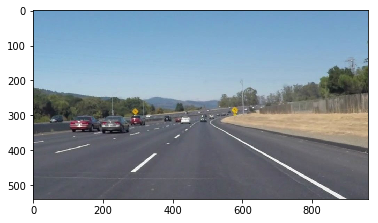

In [283]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [243]:
import math

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            print(x1,y1,x2,y2)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## New Functions

In [289]:
def extrapolate_and_average(lines, x_size, y_size):
    #print("Raw lines")
    #print(lines)
    # extract the individual points (y,x)
    pts = lines.reshape(len(lines)*2, 2)
    #print("Extracted pts")
    #print(pts)
    
    # sort them by increasing x value (first column)
    pts = pts[pts[:,0].argsort()]
    #print("Sorted pts")
    #print(pts)
    
    min_indices = np.argmin(pts, axis=0)
    
    # separate into left and right lanes (assume the min y-value (min_indices[1]) acts as the delineator)
    left_noisy = pts[:min_indices[1]-1]
    right_noisy = pts[min_indices[1]+1:]
        
    # perform a least squares polynomial fit on each lane
    deg = 3
    left_coeff = np.polyfit(left_noisy[:,0], left_noisy[:,1], deg)
    right_coeff = np.polyfit(right_noisy[:,0], right_noisy[:,1], deg)

    
    # calculate y values for linearly spaced x values along each lane
    left_X = np.linspace(left_noisy[0,0], left_noisy[len(left_noisy)-1,0], num=10)
    right_X = np.linspace(right_noisy[0,0], right_noisy[len(right_noisy)-1,0], num=10)

    
    left_Y = []
    for x in left_X:
        left_Y.append(left_coeff[0]*x**3 + left_coeff[1]*x**2 + left_coeff[2]*x + left_coeff[3])
    
    right_Y = []
    for x in right_X:
        right_Y.append(right_coeff[0]*x**3 + right_coeff[1]*x**2 + right_coeff[2]*x + right_coeff[3])
        
    left_lane = np.array([left_X, left_Y])
    left_lane = np.transpose(left_lane)
    right_lane = np.array([right_X, right_Y])
    right_lane = np.transpose(right_lane)
  
    return left_lane, right_lane

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

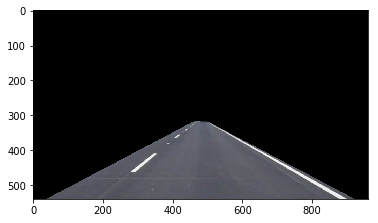

In [27]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply Gaussian smoothing to suppress noise/spurious gradients
kernel_size = 5
gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

# Canny Edge Detection
low_threshold = 60
high_threshold = 150
edges = cv2.Canny(gray, low_threshold, high_threshold)

# Region Masking
y_size = image.shape[0]
x_size = image.shape[1]
vertices = np.array([[(0.04*x_size,y_size),(0.48*x_size, 0.59*y_size), (0.52*x_size, 0.59*y_size), (0.96*x_size,y_size)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# Visualize the region mask (for optimizing the Canny parameters)
show_region = region_of_interest(image, vertices)
plt.imshow(show_region)



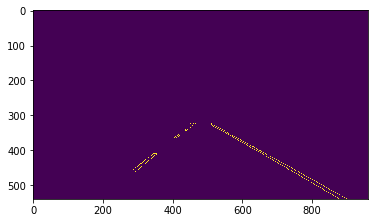

In [28]:
# Visualize the edges detected within the region mask
plt.imshow(masked_edges)

498 320 877 538
511 324 898 538
281 460 319 431
295 461 330 430
405 364 417 355
438 344 469 322
436 342 463 323
536 341 834 513
332 430 353 410
280 460 344 410
653 402 897 537
329 423 342 412
446 325 468 322
407 366 420 358
478 318 497 320
437 344 467 323
280 462 290 463
338 425 348 415
512 325 530 339
449 332 462 322
506 322 520 334
326 435 336 425
406 366 418 359
[[[498 320 877 538]]

 [[511 324 898 538]]

 [[281 460 319 431]]

 [[295 461 330 430]]

 [[405 364 417 355]]

 [[438 344 469 322]]

 [[436 342 463 323]]

 [[536 341 834 513]]

 [[332 430 353 410]]

 [[280 460 344 410]]

 [[653 402 897 537]]

 [[329 423 342 412]]

 [[446 325 468 322]]

 [[407 366 420 358]]

 [[478 318 497 320]]

 [[437 344 467 323]]

 [[280 462 290 463]]

 [[338 425 348 415]]

 [[512 325 530 339]]

 [[449 332 462 322]]

 [[506 322 520 334]]

 [[326 435 336 425]]

 [[406 366 418 359]]]


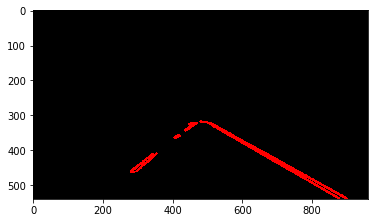

In [245]:
# Hough Transformation on the edge detected image to determine line segments
rho = 2                # distance resolution in pixels of the Hough grid
theta = np.pi/180      # angular resolution in radians of the Hough grid
threshold = 5         # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10   # minimum number of pixels making up a line
max_line_gap = 10      # maximum gap in pixels between connectable line segments

line_image, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
print(lines)

# Visualize the lines detected
plt.imshow(line_image)

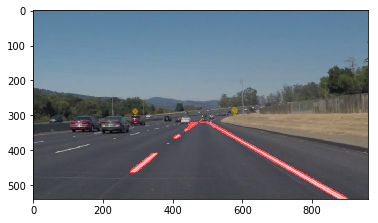

In [30]:
# Draw Lines on the original image
detected_lanes = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(detected_lanes)

In [284]:
# extrapolate the lines to delineate the entire lane
#print(lines)
left_lane, right_lane = extrapolate_and_average(lines, x_size, y_size)

Raw lines
[[[498 320 877 538]]

 [[511 324 898 538]]

 [[281 460 319 431]]

 [[295 461 330 430]]

 [[405 364 417 355]]

 [[438 344 469 322]]

 [[436 342 463 323]]

 [[536 341 834 513]]

 [[332 430 353 410]]

 [[280 460 344 410]]

 [[653 402 897 537]]

 [[329 423 342 412]]

 [[446 325 468 322]]

 [[407 366 420 358]]

 [[478 318 497 320]]

 [[437 344 467 323]]

 [[280 462 290 463]]

 [[338 425 348 415]]

 [[512 325 530 339]]

 [[449 332 462 322]]

 [[506 322 520 334]]

 [[326 435 336 425]]

 [[406 366 418 359]]]
Extracted pts
[[498 320]
 [877 538]
 [511 324]
 [898 538]
 [281 460]
 [319 431]
 [295 461]
 [330 430]
 [405 364]
 [417 355]
 [438 344]
 [469 322]
 [436 342]
 [463 323]
 [536 341]
 [834 513]
 [332 430]
 [353 410]
 [280 460]
 [344 410]
 [653 402]
 [897 537]
 [329 423]
 [342 412]
 [446 325]
 [468 322]
 [407 366]
 [420 358]
 [478 318]
 [497 320]
 [437 344]
 [467 323]
 [280 462]
 [290 463]
 [338 425]
 [348 415]
 [512 325]
 [530 339]
 [449 332]
 [462 322]
 [506 322]
 [520 334]
 [326 43

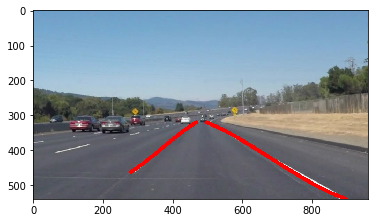

In [285]:
# Visualize the lanes detected
cv2.polylines(image, np.int32([left_lane, right_lane]), isClosed=False, color=[255,0,0], thickness=10)
plt.imshow(image)

###### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [286]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## The entire pipeline together

In [290]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian smoothing to suppress noise/spurious gradients
    kernel_size = 5
    gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Canny Edge Detection
    low_threshold = 60
    high_threshold = 150
    edges = cv2.Canny(gray, low_threshold, high_threshold)

    # Region Masking
    y_size = image.shape[0]
    x_size = image.shape[1]
    vertices = np.array([[(0.04*x_size,y_size),(0.48*x_size, 0.59*y_size), (0.52*x_size, 0.59*y_size), (0.96*x_size,y_size)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Line detection with Hough Transform
    rho = 2                # distance resolution in pixels of the Hough grid
    theta = np.pi/180      # angular resolution in radians of the Hough grid
    threshold = 5         # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10   # minimum number of pixels making up a line
    max_line_gap = 10      # maximum gap in pixels between connectable line segments

    line_image, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
   
    # extrapolate the lines to delineate the entire lane
    left_lane, right_lane = extrapolate_and_average(lines, x_size, y_size)
    
    # Draw detected lanes on the image
    cv2.polylines(image, np.int32([left_lane, right_lane]), isClosed=False, color=[255,0,0], thickness=10)

    return image

Let's try the one with the solid white lane on the right first ...

In [291]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

624 389 782 487
611 387 817 520
421 349 463 318
221 501 310 432
778 494 847 538
416 348 452 322
246 471 300 431
534 339 612 389
187 513 217 490
498 318 517 330
808 501 869 539
405 357 451 323
784 487 794 494
538 338 618 387
198 515 214 506
232 481 275 448
798 495 829 515
188 512 200 515
222 488 238 475
389 369 401 358
418 350 446 330
521 331 549 350
390 370 406 360
217 504 256 473
611 388 622 388
617 392 628 392
605 384 615 384
628 399 639 399
391 370 401 364
205 513 228 494
740 460 786 489
639 406 652 407
505 321 519 331
600 380 651 414
788 489 801 498
421 347 433 338
597 379 607 379
292 447 310 433
417 349 448 326
585 366 617 386
193 515 204 513
190 510 215 493
658 411 698 434
267 455 289 438
558 351 569 358
669 425 681 425
565 360 590 374
644 402 653 415
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                  | 0/222 [00:00<?, ?it/s]

538 347 791 499
586 364 704 433
755 478 817 516
199 515 325 423
832 530 850 538
366 394 418 354
416 357 439 339
780 497 810 515
494 320 573 369
619 384 732 450
237 491 250 481
446 335 456 323
819 522 841 531
583 362 595 368
453 330 463 318
820 518 846 539
717 442 750 461
824 525 845 534
703 449 717 453
746 476 779 495
811 517 821 519
453 329 461 319
588 365 612 378
742 473 756 465
494 321 507 330
368 392 378 384
701 447 801 509
626 400 645 412
596 382 611 392
394 373 404 365
505 328 517 336
606 388 616 395
236 487 284 452
700 447 713 451
591 379 603 387
833 527 844 538


  0%|▏                                         | 1/222 [00:00<02:15,  1.64it/s]

657 411 868 538
628 398 845 539
418 351 461 319
813 517 846 538
619 388 650 405
150 538 276 447
527 335 619 394
170 539 236 488
235 490 283 452
530 334 592 372
501 319 523 334
415 352 450 325
383 372 399 360
385 374 402 363
413 349 456 320
643 408 654 408
229 482 231 493
644 409 656 409
268 465 287 449
383 371 398 360
654 415 668 425
249 480 264 468
606 385 616 385
216 492 274 449
498 318 513 328
227 496 253 475
669 417 679 432
453 327 464 318
539 343 564 360
611 388 621 388
520 331 539 344
603 377 740 460
260 460 273 450
204 500 215 505
432 340 453 324
400 365 423 342
666 423 682 434
152 538 198 505
444 333 463 318
652 414 663 422
214 506 226 496
528 333 539 340
512 326 525 335
183 528 206 512
681 433 695 442
775 483 822 511


OSError: [Errno 22] Invalid argument

MoviePy error: FFMPEG encountered the following error while writing file test_videos_output/solidWhiteRight.mp4:

 b'test_videos_output/solidWhiteRight.mp4: No such file or directory\r\n'

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [294]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

106 537 416 350
666 425 774 495
658 427 759 497
207 487 373 380
382 376 456 326
142 527 164 514
364 387 402 362
417 348 443 332
536 340 551 350
523 331 536 339
170 509 205 488
408 360 453 329
447 328 463 318
541 340 554 349
156 518 175 507
538 338 563 357
105 539 172 498
563 360 578 369
563 359 576 363
658 428 757 497
126 538 155 520
564 360 581 367
187 498 214 482
322 412 332 415
319 408 327 418
440 333 457 325
449 326 462 318
218 478 242 464
414 350 430 341
658 425 672 428
351 395 361 388
538 341 552 350
211 473 222 477
250 451 260 452
356 385 366 385
437 335 457 324
667 425 697 444
105 538 316 411
714 457 748 479
337 404 350 395
316 416 328 418
259 453 300 426
368 378 394 363
358 384 369 383
435 342 449 332
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                  | 0/682 [00:00<?, ?it/s]

291 425 338 396
191 489 207 478
394 357 442 327
136 531 184 504
614 397 739 485
235 474 469 322
538 349 555 357
609 380 641 402
205 477 216 469
498 330 516 339
585 364 607 377
574 369 670 436
223 470 283 430
163 502 198 480
128 524 152 507
358 381 390 361
563 362 582 375
462 323 474 323
329 400 368 376
757 494 769 503
101 537 121 526
221 471 234 458
684 448 735 483
141 518 168 498
166 515 185 504
233 476 282 445
211 477 221 466
376 369 393 359
171 501 195 482
482 326 495 329
230 465 242 453
624 391 643 404
521 341 533 345
150 513 159 503
451 335 466 321
291 438 319 421
604 388 614 383
199 484 212 475
257 444 264 456
240 454 262 445
216 474 226 464
436 344 470 322
215 471 239 455
308 427 345 404
285 442 297 435
122 539 134 531
334 410 351 400
144 512 169 502
751 491 764 500
176 498 189 489
601 374 629 393
388 361 402 353
258 443 276 436
501 331 517 339
394 370 434 344
187 491 200 479
584 375 619 399
107 534 137 520
228 466 246 454
328 401 353 386
167 502 186 488
305 417 319 407
146 514 

  0%|                                          | 1/682 [00:01<12:46,  1.13s/it]

126 538 221 477
164 502 434 339
127 539 306 423
381 377 405 361
567 363 584 373
106 539 238 459
719 469 789 519
436 342 454 328
411 359 460 322
700 448 831 533
679 440 708 463
537 341 557 352
686 439 699 446
569 360 584 370
791 520 802 527
226 465 266 442
815 535 830 531
806 531 820 535
310 422 363 387
543 341 552 352
288 428 314 427
774 508 784 514
427 342 461 321
728 466 765 489
105 538 161 504
298 429 317 428
537 342 554 353
702 449 725 463
678 440 694 453
435 338 458 319
286 429 296 431
298 422 308 423
716 467 726 475
702 457 714 467
274 436 284 438
359 385 371 383
301 420 312 420
296 430 316 430
612 393 622 396
314 418 327 410
201 481 213 473
804 515 830 532
309 422 319 409
261 444 272 446
523 331 537 340
367 386 379 373
794 521 814 535
191 487 216 471
410 359 424 344
375 381 391 366
302 426 313 426
743 487 758 496
556 350 574 368
266 441 284 431
574 362 586 373
294 424 305 418
415 355 429 341
723 472 733 480
313 413 411 354
304 428 317 427
269 440 279 441
748 479 771 493
365 386 

  0%|                                          | 2/682 [00:02<12:12,  1.08s/it]

107 538 295 425
350 397 450 332
128 539 285 437
716 458 838 537
571 365 588 377
543 341 560 353
354 389 462 319
575 363 588 371
273 437 297 442
397 363 445 331
704 459 786 515
327 404 338 404
573 366 590 377
324 407 373 376
315 418 329 410
795 523 819 538
253 449 265 443
320 408 332 408
285 444 299 429
243 455 255 449
784 515 802 526
346 398 362 389
291 426 305 425
542 345 560 354
338 403 348 398
277 443 293 445
447 328 457 324
526 333 559 355
579 366 593 377
177 495 200 482
215 472 235 461
286 430 312 413
790 507 837 537
450 326 463 318
756 496 812 533
303 426 309 416
128 538 139 530
622 401 632 400
704 458 715 458
737 483 753 493
106 538 139 518
362 388 395 369
433 344 446 334
764 501 775 508
746 478 764 488
421 352 436 341
349 392 370 378
725 464 775 497
792 508 818 523


  0%|▏                                         | 3/682 [00:02<11:02,  1.03it/s]

356 389 388 368
739 483 811 533
132 538 375 381
402 364 431 346
257 450 329 404
750 480 840 538
575 369 596 382
129 528 187 491
376 377 439 336
377 381 392 366
579 366 594 375
743 485 820 539
214 476 246 455
346 394 366 388
111 538 125 529
199 485 210 477
181 496 197 485
444 337 458 323
582 373 600 379
541 344 562 357
437 342 456 320
526 332 563 357
250 454 261 464
240 460 277 436
543 342 560 354
634 412 648 412
453 329 463 318
117 535 138 521
388 374 401 360
326 406 337 406
252 461 271 460
262 464 272 464
362 384 374 378
347 393 361 385
131 538 244 465
331 403 342 403
579 371 592 374
434 344 445 330
638 409 648 411
746 480 756 483
342 396 356 394
414 356 452 330
775 495 822 526
407 356 431 341
290 428 323 409
398 368 416 356
331 404 341 404
419 348 434 339
811 518 828 530
347 400 357 393
547 344 561 354
587 371 599 379
442 338 449 327
189 491 205 480
127 529 137 522
203 483 223 469


  1%|▏                                         | 4/682 [00:03<09:44,  1.16it/s]

346 396 443 333
114 538 236 464
135 538 447 335
580 370 605 387
252 454 293 427
804 527 822 538
800 511 835 533
583 370 610 385
295 427 329 405
580 372 603 387
543 345 554 348
543 346 554 350
654 423 664 421
797 522 812 531
450 326 464 318
445 330 458 324
225 485 237 484
825 528 842 539
543 344 567 358
647 422 663 419
358 394 421 353
784 511 799 523
585 370 596 376
222 472 256 450
449 333 458 319
227 489 238 489
786 510 801 512
443 332 456 326
273 441 304 420
448 328 462 320
310 418 339 399
652 420 663 423
822 526 842 538
582 372 604 387
202 495 285 441
214 486 225 487
255 451 266 452
291 436 301 429
372 380 405 359
194 489 216 475
154 513 159 523
347 401 360 386
341 398 356 395
341 399 353 397
221 472 247 457
172 502 183 506


  1%|▎                                         | 5/682 [00:04<09:02,  1.25it/s]

117 538 355 390
364 386 447 330
136 538 441 340
591 374 619 391
586 376 610 393
138 538 176 514
442 333 461 321
589 377 611 393
670 436 680 432
547 348 557 350
173 515 193 518
118 539 406 359
439 340 452 331
178 523 194 523
197 500 197 489
592 374 618 393
191 493 193 503
195 490 196 501
519 328 534 337
450 326 463 319
453 324 464 318
546 345 556 351
380 375 397 374
187 495 190 505
170 517 182 518
279 445 302 430
668 435 678 432
210 491 227 481
194 491 195 501
402 365 446 336
601 385 612 393
594 375 608 384
168 507 179 512
305 422 333 404
204 495 242 471
377 377 388 376
375 378 386 377


  1%|▎                                         | 6/682 [00:04<07:39,  1.47it/s]

119 538 412 355
138 538 415 358
594 380 622 400
598 378 630 399
140 538 247 468
419 349 454 329
530 337 557 354
404 364 438 342
404 359 418 351
541 340 558 351
440 335 459 324
420 349 441 340
693 451 708 448
596 381 625 400
693 447 703 452
446 335 456 320
442 333 461 321
596 378 630 398
437 337 447 335
549 350 560 354
618 397 628 400
694 448 708 452
529 335 548 349
420 353 440 340
376 379 393 378
698 448 709 449
452 325 462 320
327 408 344 405


  1%|▍                                         | 7/682 [00:04<06:39,  1.69it/s]

120 538 392 368
140 539 283 443
376 377 408 357
415 357 456 325
605 382 643 406
529 335 559 355
389 375 404 363
368 389 387 375
600 382 632 406
433 340 454 321
545 342 563 355
424 351 445 336
310 419 320 420
724 466 735 471
 355
345 397 357 396
721 469 732 467
448 333 463 318
729 471 742 469
309 426 351 400
608 383 643 405
303 430 319 421
401 366 409 355
727 470 742 471
144 536 159 525
624 399 635 407
348 395 360 394
287 441 299 434
386 382 398 364
382 382 409 360
396 364 445 331
354 391 367 389
329 413 344 404
409 356 440 335
353 398 359 388
192 503 229 480
229 469 239 472
350 394 362 392
364 385 388 381
230 478 253 464
387 376 395 366
369 382 381 381
285 443 297 434
614 392 630 404
183 509 199 500
361 387 371 386
311 425 323 418
121 537 148 520
540 340 550 347
364 391 370 381
536 337 551 347


  1%|▍                                         | 8/682 [00:05<07:03,  1.59it/s]

266 456 297 434
121 538 364 386
313 425 439 340
171 517 210 493
613 387 658 414
394 365 421 348
619 396 652 417
218 486 248 468
538 338 554 348
611 387 626 393
434 343 449 325
446 334 461 318
531 335 553 349
120 538 159 513
212 490 228 481
760 494 785 497
140 538 158 527
330 406 387 371
159 525 181 512
758 493 784 493
760 490 770 497
261 459 262 449
438 336 452 324
618 395 628 401
365 384 393 367
263 458 273 450
528 829 539
532 335 557 350
360 387 394 366
175 515 191 506
395 364 421 348
283 445 436 342
666 420 676 425
619 396 638 407
642 411 656 419
815 531 835 528
625 393 658 413
545 344 555 350
141 538 151 532
440 333 458 322
441 333 451 329
439 334 450 330
353 392 373 390
356 390 372 389
435 337 446 334
825 533 842 534
661 424 671 422
828 534 841 529
555 351 568 359
411 353 425 345
373 391 386 370
196 502 207 495
172 507 187 497
360 394 372 391


  1%|▌                                        | 10/682 [00:07<07:51,  1.42it/s]

142 527 282 437
307 430 338 408
363 387 443 331
144 539 219 487
563 352 574 360
407 362 452 328
533 336 570 361
123 538 135 530
196 504 237 475
305 424 320 413
248 469 258 461
630 402 658 420
340 402 359 388
319 422 361 392
149 535 183 511
640 401 701 442
270 446 301 425
289 442 299 434
667 426 687 441
325 411 336 403
363 386 374 385
357 398 402 364
137 530 151 520
558 354 569 361
547 344 560 352
691 434 701 441
642 411 676 432
272 453 285 443
351 400 360 388
361 387 363 398
401 366 411 358
331 406 346 404
445 328 461 318
638 401 664 418
439 333 456427 348
708 445 767 481
274 443 364 386
411 353 434 338
377 376 398 363
370 386 439 339
681 428 707 443
564 358 580 367
441 331 454 325
674 430 711 456
402 359 423 346
536 338 566 356
739 476 754 484
659 420 675 432
126 539 169 510
571 357 584 367
447 332 458 319
747 470 767 482
738 475 748 480
663 419 683 428
280 448 295 439
436 335 447 331
329 415 343 414
165 514 193 495
439 338 446 327
441 337 449 324
569 356 584 365
390 367 413 353
755 4

  2%|▊                                        | 13/682 [00:08<06:48,  1.64it/s]

687 432 819 514
692 442 746 479
128 538 274 444
147 538 415 357
328 409 378 377
148 538 363 393
278 443 310 421
748 479 780 501
780 503 806 516
373 379 405 359
571 359 589 370
426 343 441 337
569 361 584 371
578 362 588 369
429 347 460 318381 384 373
447 325 460 318
248 472 260 463
423 345 440 337
237 469 247 462
718 460 734 469
199 504 235 481
294 432 307 440
366 384 378 381
713 448 806 504
735 471 772 495
317 417 329 409
372 385 433 343
320 422 328 410


  2%|▉                                        | 15/682 [00:09<06:36,  1.68it/s]

266 461 290 443
131 538 377 378
734 470 839 538
745 468 805 503
354 398 430 346
383 374 409 355
431 339 450 328
579 364 602 378
152 539 248 472
848 530 860 538
321 422 339 410
340 402 350 402
406 364 427 342
578 367 597 379
276 458 287 454
428 347 445 327
791 496 811 507
273 455 286 454
837 523 854 535
827 517 838 525
303 434 317 426
441 337 447 325
734 468 747 468
576 365 590 376
297 438 308 432
292 442 302 436
239 470 257 457
806 505 818 512
418 349 430 341
404 365 412 354
133 538 239 469
443 335 458 320
799 511 840 538
400 361 410 355
323 421 333 415
639 407 649 405
339 409 349 403
353 399 370 388
338 403 358 390
152 538 164 529
445 332 458 319
257 467 276 452
411 354 433 343
254 460 266 452
167 527 231 485
739 467 749 469
262 454 273 447
590 371 602 379
413 357 431592 376
335 406 351 401
784 502 794 509
152 538 162 531
441 336 453 325
291 435 301 428
380 381 393 367
186 516 197 508
391 373 401 361
386 372 398 369


  2%|█                                        | 17/682 [00:11<07:20,  1.51it/s]

280 451 436 341
248 465 417 351
155 538 271 459
432 338 459 319
591 372 619 389
260 465 275 456
201 496 246 465
586 374 611 390
545 343 570 360
427 342 437 335
135 538 166 519
587 374 615 390
850 531 862 538
393 366 421 348
285 448 316 427
438 339 447 325
414 352 425 345
202 505 219 504
190 503 208 490
197 510 211 510
167 517 179 510
543 343 554 350
832 530 847 530
325 412 335 413
267 452 297 431
440 337 448 325
411 360 430 346
667 428 680 430
156 538 199 509
251 471 278 454
252 462 266 452
377 377 389 375
243 468 258 457
203 509 221 509
851 531 863 538
593 372 617 387
666 428 680 424
604 385 618 390
424 349 437 339
382 374 399 371
374 379 387 377
384 379 392 367
209 490 221 506
152 527 164 520
211 488 230 477
269 459 298 440
602 379 615 387
167 518 178 510
228 478 242 468
380 375 392 373
359 389 403 360
339 410 378 383
544 343 554 348 403
328 416 364 392
550 345 561 351
221 492 237 482
548 347 558 353
136 538 165 518
256 467 307 432
712 455 727 461
622 395 633 403
609 387 623 397
437 

  3%|█▏                                       | 20/682 [00:13<06:05,  1.81it/s]

203 493 415 350
161 520 175 512
612 384 631 394
154 538 420 351
550 348 560 354
609 386 632 402
644 410 654 408
628 393 658 410
426 340 437 332
753 478 763 484
550 347 562 354
418 346 447 328
190 502 265 450
540 340 564 352
628 398 642 409
750 478 775 480
162 520 180 507
274 445 287 435
155 538 279 451
185 505 195 497
135 539 146 530
423 347 436 338
409 353 420 346
301 426 311 427
764 484 775 482
291 433 301 434
435 333 448 327
383 382 386 369
305 424 329 407
646 411 658 412
616 390 644 409
375 382 385 381
292 432 302 433
440 328 453 322
331 406 373 378
192 500 203 492
646 404 657 411
302 425 312 426
339 407 374 383
280 441 299 427



  3%|█▎                                       | 22/682 [00:14<07:58,  1.38it/s]

152 538 423 348
133 538 324 410
328 409 432 336
673 427 687 436
634 397 697 436
433 340 450 323
650 412 686 436
629 398 676 431
629 399 646 411
558 349 572 357
287 436 348 394
534 336 556 350
556 352 568 359
427 344 437 330
153 539 241 477
635 397 672 419
556 351 569 359
134 537 157 521
354 390 370 392
420 350 429 338
557 349 572 359
672 420 697 434
421 348 431 341
281 440 296 429
372 378 382 378
637 398 653 407
344 397 354 398
330 407 344 405
395 369 405 356
685 436 696 435
257 456 287 435
357 388 389 368


  3%|█▍                                       | 23/682 [00:15<07:02,  1.56it/s]

411 356 434 339
153 538 210 497
132 539 351 392
228 486 270 455
358 389 418 347
642 407 713 453
352 398 409 359
648 405 725 453
420 344 430 337
265 460 289 442
198 507 223 488
651 406 692 431
288 444 302 433
547 345 576 360
416 347 439 334
337 410 346 396
534 336 576 359
437 330 447 327
431 335 445 329
132 538 157 521
695 435 708 443
304 433 321 420
218 493 229 484
559 354 575 362
340 408 355 395
709 452 721 453
152 538 166 528
280 441 304 424
429 337 441 328
402 363 414 355
329
338 403 349 402
534 336 551 347
343 405 385 377
275 454 277 443
205 492 221 480
181 508 191 500
319 416 330 415
333 406 350 409
721 458 742 472
421 345 433 334
372 380 382 374
352 393 363 387
140 535 152 526
155 538 174 524
567 355 580 366
695 435 705 440
727 455 757 472
671 426 681 425
325 412 351 395
226 477 240 469
316 418 329 416
340 401 352 406
264 461 328 417
667 417 678 423
198 508 210 499
168 529 178 521
135 538 146 531
322 414 333 413
696 442 743 473
208 501 218 493
173 513 185 504
400 365 410 359


  4%|█▌                                       | 25/682 [00:16<07:49,  1.40it/s]

690 440 737 469
273 458 315 427
427 345 438 337
204 493 262 456
157 539 224 491
324 422 353 400
720 451 806 503
401 367 413 356
390 370 446 325
682 428 718 448
727 464 792 503
566 359 583 370
296 432 323 415
137 538 156 525
310 432 322 422
173 515 203 494
351 395 365 387
373 387 395 370
573 359 586 368
790 492 806 502
536 338 554 350
324 414 339 418
229 489 242 478
155 527 173 514
257 469 274 456
215 499 227 489
281 442 310 424
707 443 732 457
567 361 579 368
421 350 431 343
357 330
316 432 318 417
810 513 822 521
623 394 633 393
835 529 845 537
376 378 387 376
764 484 788 500
221 483 232 475
855 528 870 537
578 361 591 369
343 400 353 400
715 454 738 469
315 419 363 387


  4%|█▌                                       | 27/682 [00:17<07:13,  1.51it/s]

321 424 344 406
139 538 391 368
743 469 851 539
374 386 429 343
737 458 844 522
577 364 596 376
159 539 278 455
539 339 561 351
378 376 400 361
258 468 298 442
352 402 376 383
728 459 778 493
580 362 599 374
839 518 872 538
418 346 429 338
428 338 448 326
291 444 322 423
728 460 739 468
402 358 416 349
299 430 306 445
741 459 753 466
583 363 600 374
435 338 440 328
785 486 834 515
384 378 405 361
342 401 352 401
241 480 266 463
293 434 304 443
289 446 304 446
833 526 852 538
339 403 350 403
779 493 791 488
736 458 751 465
330 409 341 409
765 474 796 492
393 365 404 358
850 523 865 535
346 398 356 398
140 537 162 522
576 364 590 373
343 400 354 400
285 449 304 442
160 537 208 504
237 473 251 464
359 397 379 381
301 438 312 429
310 432 333 414
308 425 319 424
294 433 305 445
801 507 811 512


  4%|█▋                                       | 28/682 [00:18<06:42,  1.62it/s]

845 518 865 530
233 485 248 485
158 527 171 517
354 399 365 385
182 510 192 517
349 396 364 393
821 510 828 520
590 367 611 380
370 382 409 352
358 390 369 389
351 401 357 391
335 406 349 403
354 393 367 390
161 538 173 531
230 489 250 489
184 508 195 514
187 506 199 511
601 379 612 385
288 438 304 428
186 507 197 512
228 478 238 482
264 465 283 450
831 511 841 517
234 484 247 484
817 514 830 511


  4%|█▊                                       | 30/682 [00:19<06:26,  1.69it/s]

172 518 283 441
597 370 627 388
306 427 427 339
267 462 367 391
607 382 621 390
593 372 607 381
188 518 258 470
415 354 450 323
141 538 157 528
300 431 326 412
686 433 702 430
256 470 279 455
162 538 194 517
377 382 394 370
686 432 700 430
275 448 295 433
183 523 206 523
186 520 201 517
596 370 626 390
173 517 192 503
692 434 703 432
168 533 182 524
396 367 406 361
196 501 209 520
602 379 612 384
219 498 235 485
285 441 314 420
252 473 265 465
212 503 225 492
290 446 301 439
363 387 375 385
141 539 154 529
336 405 348 398
434 338 449 324
186 508 236 473
324 421 354 399
241 471 255 461
399 361 217 487
393 370 407 353
143 539 160 526
388 374 396 362
195 503 205 495
633 398 646 405
184 510 196 515
175 517 185 509
406 360 418 349
166 537 213 502
398 365 411 350
354 399 373 386
376 376 405 356
268 462 334 415
217 500 235 486
619 388 642 404
616 382 633 392
245 468 257 471
269 453 366 385


  5%|█▉                                       | 33/682 [00:21<05:30,  1.97it/s]

144 538 299 433
378 376 433 333
232 489 374 385
621 385 653 403
282 443 330 411
363 392 410 357
206 508 282 454
181 526 226 495
553 346 564 352
615 387 660 415
403 361 417 351
786 495 811 493
427 343 446 325
164 538 180 528
798 500 813 497
644 399 670 413
373 385 388 381
286 451 297 442
359 390 373 378
788 496 803 498
428 342 439 331
300 432 342 401
635 398 660 414
377 382 391 372
338 413 350 402
145 538 200 501
189 521 200 514
654 405 667 412
284 442 301 431
372 386 388 382
414 347 425 339
616 387 627 393
273 460 283 452
801 493 812 495
625 386 637 393
250 465 275 449
228 480 238 474
241 484 263 467


  5%|██                                       | 34/682 [00:21<05:30,  1.96it/s]

146 539 382 373
255 474 406 360
415 351 439 332
632 391 690 427
213 503 244 482
844 529 858
155 532 167 523
362 392 372 392


  5%|██▏                                      | 36/682 [00:22<05:03,  2.13it/s]

270 453 340 401
302 439 430 339
727 448 740 454
377 376 431 333
166 538 294 445
692 435 730 459
243 472 276 447
685 429 734 460
147 538 163 526
184 513 218 488
165 526 185 511
716 442 745 457
658 407 690 426
562 351 577 360
659 414 669 419
298 433 402 357
217 490 235 476
689 424 702 433
158 531 170 521
663 409 687 423
283 452 299 441
226 484 238 474
685 430 702 441
339 402 360 400
260 460 275 448
298 441 308 434
187 510 200 502
687 424 707 435
252 475 269 463
379 373 390 365
353 392 365 391
338 403 364 403
652 409 664 417
406 359 421 345
357 397 412 354
343 399 355 402
169 537 183 527
271 461 287 450
223 486 255 462
404 354 417 345
279 446 296 433
221 486 238 475


  5%|██▏                                      | 37/682 [00:22<04:59,  2.15it/s]

668 418 757 476
261 470 440 330
247 469 400 358
677 418 741 455
164 527 198 502
717 442 786 481
220 488 249 466
570 357 580 363
738 462 770 483
167 538 225 497
209 496 221 486
405 354 417 343
348 404 367 388
235 488 246 481
223 497 234 490
564 353 583 363
161 529 171 521
193 507 204 498
410172 520 301 427
165 539 408 355
723 445 884 538
323 413 425 336
745 465 863 538
715 447 762 477
159 529 188 507
362 385 399 357
726 446 828 505
572 357 593 369
417 348 427 338
152 534 170 520
302 436 324 433
715 446 777 486
385 372 425 341
177 516 191 505
800 501 863 539
321 436 322 413
286 439 311 420
420 339 436 332
357 387 367 387
349 393 360 393
168 537 225 495
345 396 356 396
332 405 344 405
230 491 241 482
748 467 782 489
799 500 812 507
245 479 256 471
348 402 387 372
319 436 320 423
868 530 878 535
326 419 329 408
716 448 733 459
834 510 852 520
221 484 231 478
323 421 351 399


  6%|██▍                                      | 40/682 [00:24<05:04,  2.11it/s]

338 402 423 338
195 517 234 486
240 470 316 418
747 468 863 538
760 466 884 538
263 466 346 402
369 386 427 338
145 539 199 499
583 365 599 374
320 415 335 403
205 495 239 472
398 363 432 334
165 538 193 518
250 474 269 461
339 400 350 400
233 487 245 479
166 538 183 526
832 509 870 530
429 338 440 328
281 451 293 453
336 403 346 403
748 468 772 482
303 426 314 419
245 467 256 460
144 538 154 532
361 392
606 374 621 384
427 338 440 328
286 439 297 430
294 433 306 433
856 528 869 530
318 424 322 412
679 425 690 425
603 377 615 385
850 528 860 538
297 431 307 423
297 440 308 432
227 499 241 501
171 519 183 510
849 528 859 538
676 424 690 422
164 539 177 528
238 483 281 452
679 422 689 420
330 415 374 380
218 485 240 471
671 424 690 421
411 346 423 337
191 505 201 497
190 520 201 511
366 380 399 357
165 523 175 530
610 376 621 383
587 367 600 375
397 362 418 346


  6%|██▌                                      | 43/682 [00:25<05:24,  1.97it/s]

143 539 344 398
204 510 374 382
143 538 367 381
424 341 438 331
372 376 390 364
594 373 627 393
385 366 408 350
164 538 176 530
599 370 623 386
368 385 407 356
594 372 628 393
415 343 427 335
400 355 412 347
196 514 214 502
408 355 420 339
174 530 194 517
704 436 714 437
621 384 632 393
383 373 423 343
597 370 619 384
221 497 281 451
192 517 202 511
354 396 380 377
365 381 398 358
702 436 712 439
207 506 217 500
430 336 442 328
609 383 624 392
276 455 302 436
346 395 379 372


  6%|██▋                                      | 44/682 [00:26<04:58,  2.14it/s]

166 538 426 342
231 479 417 344
601 378 637 401
184417 349 429 338


  7%|██▊                                      | 46/682 [00:27<04:35,  2.31it/s]

217 501 367 388
145 538 381 372
181 526 214 503
623 388 678 421
348 394 411 349
618 391 668 422
372 382 424 344
808 510 826 509
812 508 827 514
166 538 198 515
434 336 447 325
530 334 564 355
357 388 381 384
400 356 423 340
417 349 428 339
222 497 222 485
364 389 397 365
818 511 835 509
818 513 835 514
800 505 810 511
346 396 357 395
430 338 444 327
796 507 807 507
413 346 425 338
551 348 566 355
244 470 254 462
541 340 552 346
380 385 380 372
621 392 655 413
207 507 218 500
359 393 367 381
625 388 678 420
332 406 348 395
800 510 813 509
220 486 223 496
347 402 364 390
145 539 181 514
369 380 385 369
285 441 308 423
639 398 662 412
306 426 322 413
301 437 352 399
354 390 365 389


  7%|██▊                                      | 47/682 [00:27<04:40,  2.26it/s]

427 340 447 325
146 538 209 495
166 539 425 343
630 398 690 435
320 416 431 333
554 350 566 357
247 468 276 446
635 395 699 433
281 444 304 426
230 480 241 471
188 523 379 379
554 349 569 357
295 434 337 402
634 395 662 412
530 334 570 355
210 494 228 480
656 415 689 435
633 400 643 407
409 
664 411 761 469
267 451 387 366
681 428 748 471
403 354 431 333
168 535 281 452
213 491 263 454
162 527 208 493
654 412 666 420
561 354 574 357
561 352 575 362
662 411 738 456
171 533 204 510
429 339 442 327
196 503 211 491
145 539 170 520
657 412 677 427
677 426 687 433
206 496 218 486
375 381 403 358
563 355 576 362
350 406 362 390
534 336 549 344
279 453 280 442
165 538 192 519
742 457 760 468
398 363 417 347
385 366 396 359
332 406 355 404
278 444 290 445
751 471 762 469
264 464 278 454
145 538 157 529
273 447 293 434
411 353 421 344
282 451 305 433
347 406 356 395
193 517 206 508
690 434 709 447
339 401 351 399
326 410 339 408
318 416 340 400
737 463 750 471
656 414 733 462
226 480 237 474
215

  7%|███                                      | 50/682 [00:28<05:13,  2.02it/s]

167 523 299 428
164 538 444 327
683 423 747 460
673 423 709 447
144 539 203 496
717 452 766 481
682 423 773 477
566 353 585 363
338 402 429 334
564 354 582 366
340 399 343 416
783 481 809 498
770 485 784 492
228 492 241 481
236 486 249 475
308 422 323 420
263 466 273 457
789 
277 445 308 422
418 348 443 327
288 445 301 437
857 537 867 536
717 452 727 450
748 462 758 467
318 415 331 414
215 500 232 489
703 442 722 454
269 460 281 452
238 473 239 484
838 526 844 516
385 373 402 359


  8%|███▏                                     | 52/682 [00:30<06:04,  1.73it/s]

321 422 419 346
722 455 769 485
735 455 828 510
251 463 332 405
723 455 856 538
143 538 178 513
213 490 236 472
344 405 448 324
252 473 308 430
164 539 221 495
572 362 595 374
284 440 433 332
579 362 596 372
842 518 878 538
176 516 197 500
255 460 265 452
581 368 597 374
231 477 242 468
242 479 255 470
297 442 308 444
154 531 174 516
820 504 830 511
297 439 311 442
302 436 312 427
722 457 740 456
203 497 215 487
163 525 177 514
737 455 786 484
536 337 559 349
823 517 852 535
543 342 559 350
573 363 593 374
810 499 836 513
173 531 200 512
265 462 290 445
359 387 369 378
849 521 877 539
805 496 818 503


  8%|███▏                                     | 53/682 [00:30<06:21,  1.65it/s]

255 471 437 334
438 332 450 323
193 517 215 499
273 448 435 331
143 539 223 481
758 479 856 538
265 462 288 462
773 478 877 538
263 455 277 444
167 535 179 527
268 460 288 459
580258 469 445 328
142 539 394 362
188 519 224 494
581 369 606 384
838 528 855 538
162 538 187 521
806 507 856 538
825 509 877 538
586 367 612 384
587 367 601 375
396 359 425 339
247 487 258 487
432 337 449 324
371 377 381 376
218 497 235 486
242 486 252 472
809 512 824 508
408 350 435 331
600 375 612 383
388 365 401 357
540 341 550 346
142 538 166 521
171 518 176 528
190 518 202 510
241 480 259 468
357 387 369 385
236 484 255 482
350 392 362 390
230 488 246 487
334 404 344 404
822 509 836 514
584 370 597 378
809 508 840 529
370 384 379 372
169 519 173 530
239 483 249 482
813 512 828 522
835 514 848 521
335 403 345 403
267 452 279 453
363 383 374 381
301 427 315 427
318 415 329 415
173 516 179 526
431 338 442 330
307 424 317 424
325 410 336 410
585 367 612 382
336 402 361 385


  8%|███▎                                     | 55/682 [00:32<06:34,  1.59it/s]

233 487 448 325
273 448 435 331
212 502 420 346
142 539 200 497
199 499 219 484
587 373 605 383
161 538 174 530
267 452 292 433
257 459 275 445
592 371 622 388
192 504 218 519
215 488 239 470
598 380 617 390
199 520
406 352 416 346
606 380 620 388
200 510 214 501
283 449 323 420
739 462 749 466
425 338 440 332
435 331 445 328
544 346 554 352
142 538 170 518
242 479 272 458
428 336 441 331
366 381 376 374
282 440 295 441
381 370 395 361
343 397 355 395
162 539 198 513
603 383 633 403


  9%|███▍                                     | 58/682 [00:33<05:05,  2.05it/s]

141 538 430 335
201 510 409 354
403 360 436 333
614 385 662 415
626 397 640 407
617 385 661 413
161 538 194 515
610 386 652 414
770 489 788 486
299 437 441 330
525 332 561 352
548 347 561 354
611 388 621 395
170 519 200 497
639 405 654 415
226 480 237 471
549 349 560 354
189 506 210 490
780 486 792 491
307 423 320 413
263 454 273 446
162 539 176 527
550 345 560 351
343 398 407 352
610 385 624 397
431 334 442 329
203 496 220 483
215 499 229 488
318 415 364 382
167 535 180 524
275 445 287 446
286 437 296 438
287 436 297 437
613 385 630 394
277 443 288 444


  9%|███▌                                     | 59/682 [00:33<04:50,  2.15it/s]

140 538 430 335
167 534 318 421
526 332 565 354
624 392 681 424
415 351 450 323
357 394 413 351
824 519 835 525
549 349 560 356
618 392 671 426
822 522 837 520
834 458
639 407 675 430


  9%|███▋                                     | 61/682 [00:34<04:49,  2.14it/s]

138 538 302 424
157 538 425 343
351 390 387 366
649 407 730 455
644 409 723 458
426 341 450 323
294 431 324 409
420 341 433 332
557 351 573 359
158 538 186 518
652 408 675 421
644 410 666 424
558 355 571 362
528 334 547 344
683 435 721 458
533 338 543 344
394 360 407 352
722 449 733 456
336 401 355 400
396 364 412 347
346 394 356 393
329 406 356 403
555 352 572 361
139 537 157 524
368 378 422 341
341 397 355 395
266 450 288 434
334 402 350 403
325 409 337 408
343 396 353 390
342 403 443 329
685 436 695 433
693 432 717 447
317 415 327 407
530 336 544 344
408 350 419 351
295 430 398 358
152 528 184 505


  9%|███▋                                     | 62/682 [00:35<04:59,  2.07it/s]

283 447 321 418
203 493 433 332
428 339 450 323
136 539 180 507
667 417 771 479
662 420 752 478
559 353 578 363
156 539 178 523
383 374 444 328
184 517 226 488
252 468 280 449
562 353 578 362
529 335 559 354
238 478 258 465
276 443 416 345
560 355 577 365
188 503 198 495
323 410 342 412
207 490 227 475
558 355 571 362
172 526 182 520
732 464 757 480
380 376 446 325703 446 850 538
568 358 589 370
711 445 820 508
376 373 421 342
137 537 342 398
826 513 864 534
156 538 446 327
567 361 586 372
713 445 758 471
411 348 426 338
567 360 578 367
703 447 750 477
298 427 405 354
806 499 816 507
821 510 831 515
293 439 314 436
303 432 315 434
427 336 444 328
430 334 448 325
774 492 841 533
534 339 552 350
570 358 582 365
152 527 155 538
136 539 149 530
347 393 357 393
819 520 849 538
782 487 809 502
833 516 859 531
288 443 298 436
533 338 549 347
740 470 752 478
136 538 177 511
354 388 364 388


 10%|███▉                                     | 65/682 [00:36<04:43,  2.17it/s]

156 539 435 336
747 465 858 531
257 457 424 340
734 466 809 514
574 361 597 374
145 533 249 461
571 362 588 375
426 337 445 328
829 525 849 538
534 339 552 350
797 505 822 522
245 465 261 453
278 451 291 450
535 337 557 350
139 537 155 525
430 334 450 324
413 347 437 334
231 475 294 430
734 465 744 464
836 530 849 539
425 338 442 330
274 454 294 451
733 466 748 476
753 467 767 478
859 531 871 538
571 364 582 370
329 406 340 406
341 398 351 398
352 390 362 390
584 368869 538
226 479 285 437
581 371 607 387
586 369 613 387
210 500 230 504
424 345 437 330
192 502 205 492
158 538 439 334
660 424 676 421
223 481 240 468
200 497 211 488
539 342 559 354
538 340 548 344
338 402 408 353
144 535 158 524
829 527 849 538
595 374 613 386
210 490 221 481
541 344 559 356
667 425 677 422
827 525 838 531
425 339 440 333
829 522 839 522
582 371 595 379
602 378 613 385
203 505 231 503
830 527 848 539
275 445 323 411
140 537 164 520
162 522 173 528


 10%|████                                     | 68/682 [00:38<04:47,  2.14it/s]

226 490 308 429
178 512 329 407
327 417 357 394
201 508 275 453
431 336 442 327
306 432 322 419
386 373 432 340
429 341 439 334
601 378 624 393
369 387 379 378
591 377 614 393
309 422 422 343
147 533 167 518
599 377 624 394
164 539 176 537
688 439 700 438
178 523 195 512
175 514 189 503
682 434 696 439
593 379 603 386
542 341 552 348
593 373 607 383
687 437 699 435
157 538 173 528
540 343 551 349
138 538 151 529
381 377 411 356
687 435 700 437
186 506 279 441
367 388 380 372
343 398 356 396
303 434 305 424
353 391 366 389 181 508
256 468 424 346
606 382 649 407
289 436 419 345
609 390 640 409
230 476 278 442
602 384 642 409
740 475 760 472
160 524 190 502
604 382 647 406
195 500 213 486
524 333 554 348
753 478 763 476
211 489 228 476
433 333 444 326
752 477 764 474
736 474 747 472
544 347 558 353
524 332 549 345
231 475 241 467
429 336 440 329
545 347 557 350
633 399 647 407
739 470 751 476
535 337 546 345
138 538 149 530
609 389 621 397
421 348 440 332
205 493 220 481


 10%|████▎                                    | 71/682 [00:39<05:08,  1.98it/s]

418 349 441 333
273 456 423 347
181 509 275 444
610 390 658 420
160 537 223 490
525 334 548 347
243 477 262 462
298 430 343 398
616 388 666 420
143 535 163 520
221 493 238 479
638 401 666 419
338 403 444 326
777 502 810 505
550 351 561 353
162 522 179 509
270 449 290 434
515 326 562 354
789 500 799 506
287 437 297 438
350 394 362 385
409 357 454 321
289 444 296 430
372 378 377 388
137 539 154 526
547 349 561 356
165 533 188 515
172 515 182 507
254 459 267 460
635 407 656 420
787 500 799 507
782 502 805 500
335 405 352 392
437 330 451 356 402 371 379
365 383 375 383
139 537 149 530
351 393 363 392
553 354 566 361
346 397 357 396
697 447 711 448
355 390 367 389
338 402 350 401
345 404 362 401
652 417 666 427
410 357 417 347
528 333 553 351
404 355 415 348
328 409 340 408
363 385 373 384
317 425 327 417
699 439 709 445
276 454 349 402
358 388 369 387
395 368 408 357
183 520 199 508
359 399 360 387
361 386 371 386
357 389 368 388
341 400 356 399
349 395 359 394
179 511 195 499
344 405 354 

 11%|████▍                                    | 74/682 [00:41<05:24,  1.87it/s]

138 538 353 393
370 387 443 332
653 412 742 467
645 414 731 467
446 328 457 320
376 377 423 341
171 528 207 504
340 409 401 362
240 479 270 459
188 516 224 492
272 456 323 421
559 353 574 362
529 337 542 346
516 327 543 346
556 356 573 364
436 336 453 324
343 410 357 389
725 455 742 466
222 492 239 481
164 533 181 522
429 342 437 331
364 391 378 374
300 436 324 420
530 335 556 353
381 372 417 347
341 401 351 407
532 335 557 353
337 411 347 402
341 400 357 390
559 358 570 364
165 533 176 526
418 346 431 335
716 460 397 362
395 367 408 359
179 524 199 509
746 470 764 480
685 433 698 439


 11%|████▌                                    | 76/682 [00:42<05:51,  1.72it/s]

140 539 224 480
692 437 839 525
734 472 822 527
219 496 285 447
282 442 419 346
384 375 437 337
509 323 549 350
295 440 318 428
173 529 186 518
564 362 583 372
565 358 583 369
263 455 308 423
421 343 444 327
228 479 258 457
681 437 738 473
311 428 365 391
140 538 177 512
439 334 451 326
191 516 207 503
241 470 253 461
707 455 771 494
681 439 691 437
416 347 442 333
609 392 619 392
247 466 261 455
536 343 552 348
191 504 210 490
444 330 455 322
296 432 323 432
169 532 179 523
209 503 221 493
200 498 213 488
819 526 840 527
390 371 420 350
520 330 540 340
366 390 376 381
292 442 337 411
809 508 819 511
275 455 294 442
433 334 448 324
683 439 693 446
695 437 704 452
356 390 367 388
808 518 820 513
823 516 833 522
571 361 581 367
755 485 766 480
803 515 818 524
248 475 283 450
785 503 796 512
340 401 355 392
703 452 736 472


 11%|████▋                                    | 77/682 [00:43<06:08,  1.64it/s]

138 538 351 394
710 456 800 514
299 438 406 358
778 489 860 537
533 339 552 351
260 466 334 588 371
145 534 159 523
577 370 594 379
256 459 268 450
821 527 840 538
413 348 430 337
151 530 162 521
588 372 598 377
168 531 183 519
738 475 758 486
262 464 280 464
263 462 279 460
240 470 250 462
629 405 643 404
164 521 179 510
511 324 521 331
569 365 580 371
163 521 211 489
842 528 859 538
761 479 774 487
241 468 268 451
398 364 455 321
203 494 213 487
347 403 419 350
189 515 248 473
284 439 294 433
271 448 281 442
383 371 398 359
313 420 327 410


 12%|████▋                                    | 79/682 [00:44<05:49,  1.72it/s]

219 495 289 443
186 506 300 427
155 527 233 473
302 427 372 377
582 367 606 383
348 402 369 385
189 516 243 476
780 502 840 538
366 383 396 360
401 358 429 336
811 509 860 539
800 502 831 520
574 366 598 384
405 360 456 320
149 531 166 518
157 539 187 516
541 340 558 355
536 341 547 346
648 412 658 413
368 387 388 371
536 342 546 346
296 438 329 416
386 374 400 362
580 366 605 384
283 440 309 421
390 365 403 367
647 414 658 415
380 373 402 356
232 475 251 485
537 340 556 355
187 504 198 509
397 367 414 352
781 501 836 535
236 487 245 


 12%|████▊                                    | 81/682 [00:45<05:37,  1.78it/s]

248 473 438 335
585 375 618 396
236 471 444 326
183 518 234 483
142 535 253 458
522 332 549 349
608 383 625 394
680 439 693 436
376 380 382 370
683 441 696 436
155 538 181 521
439 334 456 320
136 538 147 530
513 325 547 344
185 517 195 511
356 388 369 385
590 373 603 380
413 353 452 322
612 387 625 395
390 375 398 359
512 325 550 347
225 488 239 479
389 375 394 362
352 391 363 389
230 475 252 459
527 333 551 349
249 471 263 462
336 408 385 373
588 373 609 384
136 539 162 520
378 373 391 372
392 374 400 358
373 377 383 370
181 507 192 501
350 393 369 379
263 461 329 414
585 374 619 396
413 352 427 337
299 428 309 428
256 467 268 458
343 397 355 395


 12%|████▉                                    | 82/682 [00:46<06:22,  1.57it/s]

181 520 455 321
380 372 442 327
522 332 554 351
176 511 237 469
155 539 190 512
610 392 631 404
258 456 292 431
601 379 636 402
271 447 327 407
135 538 193 498
242 467 272 445
393 362 404 360
536 337 554 349
592 379 605 387
715 454 726 456
596 377 623 394
330 405 354 390
543 347 553 351
374 381 388 377
592 380 614 393
706 454 724 457
358 556 351
261 453 280 439
136 537 148 528
738 476 760 475
626 401 641 412
234 472 245 463
305 423 320 412
525 334 545 345
428 342 443 331
360 385 381 383
277 442 292 431
333 404 391 364
545 348 557 353
254 458 271 445
428 336 440 328


 12%|█████                                    | 84/682 [00:47<06:04,  1.64it/s]

233 470 426 339
216 482 243 465
155 539 456 320
615 388 665 420
514 326 558 355
784 507 802 504
607 388 656 422
147 530 185 503
427 343 436 331
539 339 560 355
781 503 796 513
190 501 200 493
134 539 154 524
345 395 374 388
785 503 793 513
625 400 659 423
546 348 556 355
526 332 549 346
430 335 444 330
789 510 809 509
622 392 669 421
182 506 194 497
250 460 263 450
525 334 557 352
306 422 324 409
404 353 442 327
782 505 792 512
297 428 312 417
395 366 412 353
282 438 293 430
247 462 257 454
782 504 797 504
286 443 299 435
256 456 269 446
358 386 371 385
421 347 449 326
388 371 397 358
352 390 372 388
342 397 353 396
267 457 277 451
364 382 374 386
228 475 241 465
393 361 406 352
339 399 349 399
525 332 537 340
361 384 371 383
322 411 337 408


 12%|█████                                    | 85/682 [00:48<05:42,  1.74it/s]

154 539 340385 381 370
218 492 231 481


 13%|█████▏                                   | 87/682 [00:48<04:58,  1.99it/s]

301 431 444 330
130 538 440 329
697 447 717 462
654 412 751 472
511 324 568 359
668 428 695 447
150 539 295 437
706 453 722 465
658 415 702 443
642 411 666 428
529 337 555 353
307 427 334 409
556 356 571 363
246 470 272 453
736 474 749 474
364 386 450 325
185 513 219 490
228 483 246 471
302 431 308 419
270 454 286 442
336 401 348 399
719 462 736 473
707 446 742 467
166 513 177 506
330 411 340 411
344 407 350 397
167 526 192 509
694 445 712 459
178 505 200 492
304 430 323 417
666 427 685 441
195 494 212 484
398 357 433 333
233 479 256 464
734 463 750 472
152 537 164 528


 13%|█████▎                                   | 88/682 [00:49<04:43,  2.09it/s]

149 538 393 367
671 422 796 500
265 447 363 383
717 460 779 501
209 486 246 460
378 376 438 335
129 539 184 501
658 421 758 488
531 335 560 355
191 498 204 488
535 340 573 366
395 359 436 332
564 355 577 364
666 422 682 429
559 358 570 365
149 539 313 424
206 488 216 480
442 332 452 322
340 397 351 396
360 390 371 376
242 463 276 441
669 422 796 501
427 337 441 328
374 380 391 362
133 536 483 241 475
299 434 315 434
690 439 701 441
764 479 777 489
324 416 333 403
390 368 400 361


 13%|█████▍                                   | 90/682 [00:50<05:18,  1.86it/s]

131 539 321 411
720 454 856 539
787 509 814 524
333 411 457 321
167 528 259 462
338 401 445 326
534 341 552 353
732 461 856 538
570 361 589 374
703 454 783 504
566 363 587 375
290 433 327 407
507 322 554 352
271 455 294 437
384 375 446 330
314 424 326 408
703 452 728 468
318 421 333 403
797 513 832 537
252 468 282 445
314 417 327 415
395 362 438 332
283 449 303 431
524 331 537 340
704 456 719 454
150 538 168 527
576 364 587 372
566 364 585 375
509 324 522 333
536 339 555 352
305 430 312 418
836 525 857 538
289 446 295 429
705 452 719 460
289 442 301 432
769 496 782 504
618 399 631 397
130 538 171 511
817 526 835 538
313 425 321 412
273 444 295 447
151 539 169 525
182 516 200 505
704 452 720 455
731 470 742 479
278 441 305 422
183 516 193 508
203 501 228 485
261 462 279 448
711 458 732 471


 13%|█████▍                                   | 91/682 [00:51<05:20,  1.84it/s]

452 325 462 318
754 477 854 537
153 538 438 338
223 479 297 428
573 365 595 379
331 407 451 323
164 518 499
258 465 442 336
210 500 237 498
220 493 238 497
790 508 802 516
272 447 286 437
149 529 164 518
259 456 274 445
821 519 835 528
170 515 182 520
135 539 147 529
428 341 441 336
820 530 832 539
547 350 558 359
546 348 562 359
443 329 456 320
168 517 179 522
805 520 805 508
240 469 252 460
227 488 231 499
789 510 800 507
393 365 412 353
217 495 233 494
200 495 211 487
776 503 786 508
509 326 521 333
581 370 603 384
383 372 402 360
831 525 846 534
804 508 814 516
779 502 789 508
341 400 351 401


 14%|█████▌                                   | 93/682 [00:52<05:41,  1.72it/s]

268 451 352 393
155 538 439 339
505 323 527 337
512 329 526 338
584 373 612 389
371 380 427 343
172 515 234 472
177 537 192 534
580 376 597 386
229 477 251 461
136 539 168 516
323 420 446 333
541 345 565 362
418 348 435 337
431 339 444 330
594 385 607 392
663 431 676 429
241 469 269 449
158 537 199 509
341 401 400 362
163 521 173 513
502 320 515 329
501 319 516 329
515 326 528 336
173 531 186 530
224 480 236 471
429 347 452 327
510 327 527 338
177 511 191 501
256 459 284 439
306 426 317 426
308327 457 324
506 324 524 336
594 385 604 392
448 326 458 319
718 465 731 464
156 538 171 529
499 318 530 339
180 521 192 514
137 538 207 491
316 427 366 390
415 357 443 336
182 521 196 510
328 411 348 396
360 388 371 387
449 326 465 318
300 430 310 422
264 463 279 452
307 424 318 425
608 388 624 399
337 405 350 395
413 352 430 341
374 385 384 372
323 413 333 414


 14%|█████▊                                   | 96/682 [00:53<05:43,  1.71it/s]

510 324 532 338
137 538 432 339
305 434 454 326
200 507 270 459
607 387 647 411
600 389 641 414
155 538 198 510
601 389 624 403
512 328 531 340
434 336 450 325
279 451 309 431
746 486 761 483
547 353 559 357
546 351 559 355
752 487 764 483
378 382 443 335
251 471 277 454
419 347 433 338
448 325 463 318
181 520 205 505
503 320 532 340
622 397 647 412
757 488 769 486
311 428 338 410
241 469 414 352
443 329 460 321
193 512 208 503
290 443 324 420
616 393 626 399
445 327 464 318
517 327 530 336
369 387 379 389
433 337 453 326
166 532 177 523
137 537 207 492


 14%|█████▊                                   | 97/682 [00:54<05:13,  1.86it/s]

308 430 331 415
445 331 462 319
610 394 657 424
404 362 432 343
361 392 
791 510 806 519
194 500 211 489
422 351 432 342
359 395 370 390
157 539 188 516
516 327 528 339
419 353 429 344
180 521 190 515
519 329 530 336
515 330 526 335
307 431 317 425


 14%|█████▉                                   | 98/682 [00:55<05:54,  1.65it/s]

173 515 287 436
166 533 364 390
429 339 452 322
138 539 247 463
435 339 462 318
550 354 561 361
515 329 552 352
634 410 675 436
626 398 684 435
342 399 383 373
366 390 381 378
258 457 299 428
375 377 409 355
505 321 566 359
406 362 434 340
157 538 176 524
356 391 366 401
396 369 414 350
620 401 648 418
309 421 332 407
333 405 363 397
551 354 564 361
660 418 683 434
179 522 189 516
346 397 364 401
343 399 361 397
425 342 444 333
140 537 174 513
367 388 380 380
160 537 197 509
423 344 441 336
413 356 421 346
204 505 221 492
138 538 149 530
225 490 239 479
517 331 543 347
527 338 552 353
354 392 364 391
429 345 435 335
304 425 321 422
300 437 303 426
327 409 342 400
351 394 362 393
516 327 544 344
630 399 641 407
178 524 206 503
292 443 294 432
352 393 363 392
363 385 375 384
273 447 287 437
532 337 563 358
358 433
180 521 191 514
135 538 150 528
652 415 663 420
196 510 206 504
441 335 447 325
334 412 346 418
233 484 245 476
705 447 721 456
725 460 741 470
424 349 454 324


 15%|█████▉                                  | 101/682 [00:56<05:39,  1.71it/s]

325 419 453 326
274 455 297 437
135 538 348 395
662 428 767 496
508 323 551 350
194 512 252 469
320 415 447 326
697 442 782 493
565 358 580 368
155 538 180 522
308 423 330 429
689 437 709 448
532 340 577 369
681 432 703 443
448 324 459 321
314 418 331 427
273 455 276 444
379 381 438 338
670 425 685 433
432 341 455 324
312 420 327 429
560 360 571 366
768 496 782 495
313 427 320 414
724 467 735 463
207 503 347 402
533 338 552 348
185 517 195 511
720 464 754 487
669 432 692 446
714 452 735 464
323 412 335 411
320 422 332 429
507 322 522 330
365 385 425 343
663 425 679 428
191 501 201 495
669 425 701 443
188 516 209 500
220 482 264 452
703 454 715 461
567 360 580 369
325 429 326 418
351 393 362 393
683 441 704 454


 15%|█████▉                                  | 102/682 [00:57<05:21,  1.80it/s]

682 441 821 531
356 391 426 342
155 538 386 376
507 322 555 352
134 538 238 470
721 457 839 528
564 362 581 373
448 324
728 459 764 483
192 511 204 504
570 363 591 374
134 538 152 527
182 518 197 509
155 523 165 518
376 383 388 373
197 497 217 482
569 365 589 377
243 475 262 463
278 442 288 456
279 442 292 460
168 516 190 500
163 533 173 524
422 345 432 336
434 341 446 330
723 457 745 472
271 447 282 455
537 340 558 352
568 365 583 375
239 478 252 470
270 456 286 460
440 330 455 324
269 449 303 425
708 457 718 456
270 448 290 460
574 364 592 374
510 324 524 331
362 393 378 380
348 403 367 388
841 531 854 539
369 388 381 378
535 342 556 354
273 455 284 446
352 392 402 359
781 493 791 500
775 490 817 516
324 411 336 411
321 413 333 413
436 333 446 327
268 458 280 456
327 409 339 409
507 322 525 333
744 471 758 480
212 497 224 490
322 412 335 412
342 399 352 399
419 352 442 334
820 531 832 539
285 446 321 422
245 465 292 432
344 398 354 398


 15%|██████                                  | 104/682 [00:58<06:15,  1.54it/s]

153 538 420 351
288 436 405 357
576 365 598 380
133 538 272 445
752 476 856 538
741 479 822 530
537 343 557 356
446 331 458 320
509 323 521 330
432 342 439 330 333
205 490 223 507
147 529 173 511
437 332 453 325
377 375 389 368
805 507 837 528
578 369 596 382
226 488 238 478
144 531 155 523
220 492 234 481
592 374 605 383
656 418 666 420
264 452 274 454
345 398 386 369
188 530 198 524
212 511 222 507
197 507 210 509
256 457 266 460
239 478 250 470
412 351 445 327
304 425 315 417
161 533 191 512
274 445 285 446
581 373 591 374
203 504 218 492
272 446 283 447
268 449 279 450
269 448 281 449
265 451 277 452
443 332 458 320
549 348 559 355
431 341 441 333
288 436 299 428
257 455 267 459
266 450 278 451
549 349 559 356


 16%|██████▏                                 | 106/682 [01:00<06:19,  1.52it/s]

152 538 224 488
246 464 412 352
292 442 463 318
234 483 331 413
133 538 257 455
507 322 523 332
430 337 444 328
583 373 608 391
589 373 616 390
585 375 597 384
540 344 567 361
177 521 187 516
413 350 432 337
190 513 210 498
199 507 209 499
225 477 236 481
402 358 413 356
399 360 412 357
587 373 616 391
389 367 399 366
232 484 243 475
670 431 680 434
274 445 292 432
542 344 552 351
512 326 526 336
395 363 405 362
134 537 169 513
156 539 250 471
217 496 328 416
376 382 412 358
134 539 295 431
297 431 361 387
340 409 362 392
507 323 531 338
600 382 639 405
342 401 383 372
597 384 632 407
353 394 424 344
426 341 439 333
415 349 425 343
433 342 463 318
544 350 554 356
437 338 446 326
134 538 150 527
410 359 420 350
545 349 555 352
724 468 737 465
604 383 627 397
722 467 734 465
279 443 297 430
506 322 525 334
411 352 423 349
328 409 338 410
442 334 456 323
545 350 555 356
327 417 337 411
267 451 278 443
370 388 403 363
444 334 459 322
608 387 639 407
243 467 254 459
141 534 185 504
337 404 

 16%|██████▍                                 | 109/682 [01:01<06:04,  1.57it/s]

156 538 400 367
277 445 403 360
407 362 440 336
610 388 654 416
134 538 205 491
607 391 643 416
760 491 773 496
420 346 438 334
251 462 305 425
207 491 237 470
442 330 461 321
501 319 541 343
528 339 560 359
626 397 654 415
632 407 646 417
760 489 776 495
444 334 451 323
769 496 784 493
509 325

 16%|██████▍                                 | 110/682 [01:02<07:05,  1.34it/s]

135 539 230 475
228 489 339 409
448 330 465 318
518 328 565 361
425 344 458 319
323 422 462 321
634 402 668 424
614 397 664 428
174 527 217 495
303 428 337 404
249 464 265 452
258 458 277 444
550 354 562 361
276 446 286 438
318 418 444 330
813 525 836 523
209 502 226 489
621 395 646 411
508 323 538 346
615 397 653 421
203 494 223 480
235 473 245 465
825 533 841 528
824 532 841 525
156 539 168 529
829 534 837 524
352 400 368 398
503 320 513 328
811 525 831 530
242 478 244 466
815 522 828 534
361 394 372 381
348 398 368 395
175 525 190 514
229 477 239 469
199 509 216 496
813 526 825 534
276 445 291 436
527 338 542 346
357 392 367 391
342 408 360 394
539 346 551 353
377 378 391 368
619 394 632 401
513 325 529 336
386 372 417 348
551 352 561 356
654 414 664 421
135 538 151 527
501 319 543 346
331 415 349 402
614 396 624 402
553 355 563 361


 16%|██████▌                                 | 111/682 [01:03<07:24,  1.28it/s]

156 538 411 359
156 526 421 347
627 404 685 441
424 348 451 329
136 539 249 463
157 538 397 370
630 401 671 424
532 337 569 363
425 343 443 331
405 378 383 386 372
343 400 356 399
337 404 350 403
137 539 159 523
355 393 365 392
321 422 346 410
709 458 722 458
346 398 358 397
530 339 560 356
162 535 189 517
559 360 570 366
156 538 206 505
392 372 450 330
698 442 722 455
172 515 183 507
535 343 545 349
677 437 706 456
343 414 358 391
331 415 342 413
225 479 239 471


 17%|██████▋                                 | 113/682 [01:04<06:04,  1.56it/s]

516 329 579 367
260 467 466 318
392 366 460 318
711 450 757 477
332 409 358 390
190 516 204 505
158 538 169 530
671 433 744 479
203 495 267 451
560 360 575 369
272 449 309 423
669 422 708 448
236 484 255 469
269 460 286 447
653 421 712 458
532 341 548 351
305 427 444 330
176 513 198 497
137 539 153 527
158 525 171 515
200 497 210 489
505 321 551 348
323 414 337 423
182 522 194 512
209 503 221 493
312 422 322 414
735 465 758 479
662 419 677 429
243 479 254 470
177 512 187 504
702 443 713 451
378 377 389 375
229 478 243 468
661 425 671 424
737 476 749 479
322 423 335 423
146 533 162 521
307 425 335 424
332 416 449 331
199 510 209 502
325 419 335 420
666 421 723 456
567 359354 394 364 386
539 341 556 353
536 342 553 354
286 447 304 436
619 399 631 399
507 322 522 333
210 501 220 495
618 398 628 396
215 486 227 479
313 429 323 414
150 529 164 521
828 521 855 537
416 350 450 324
273 447 285 449
192 501 206 493
706 445 718 452
694 447 774 499
278 454 293 442
159 523 173 515
444 333 461 322
2

 17%|██████▊                                 | 116/682 [01:06<05:43,  1.65it/s]

157 538 374 386
162 522 389 369
724 466 836 539
136 539 350 395
513 325 560 355
812 511 857 537
540 341 560 354
338 410 380 381
578 365 598 380
431 344 465 318
733 463 861 539
509 323 554 353
421 351 447 326
395 370 414 350
808 519 837 538
573 368 595 380
417 354 434 336
387 376 396 363
630 406 640 408
632 404 644 406
394 370 401 359
425 348 438 333
136 538 158 523
384 378 394 364
254 469 278 469
259 466 277 466
449 329 462 321
587 371 598 379
538 344 554 354
725 466 747 480
244 476 295 441


 17%|██████▊                                 | 117/682 [01:06<05:05,  1.85it/s]

137  396 391 373
827 519 860 538
586 372 615 389
173 528 193 530
812 521 832 535
181 528 191 524
390 373 400 360
401 359 437 335
541 344 566 360
373 379 385 377
384 371 394 370
663 425 677 427
663 427 676 424
367 383 380 380
177 525 196 524
186 506 193 524
827 531 839 539
394 364 404 363
441 331 456 325
376 383 381 373
661 426 677 428
380 374 392 372
316 426 338 411
812 522 822 529
812 520 824 519
552 350 563 360
381 379 390 367
377 376 388 375
391 366 402 365
445 333 460 318
298 430 354 393
588 372 599 379
157 539 175 527
350 402 369 389
370 381 390 368
396 363 406 362
173 515 186 524
363 386 374 384


 17%|██████▉                                 | 119/682 [01:07<05:05,  1.84it/s]

138 539 392 367
242 480 466 318
361 387 440 333
158 538 221 495
594 376 626 396
589 378 619 397
590 379 618 397
683 440 695 438
198 510 215 499
216 497 232 487
507 322 527 335
438 333 461 318
686 441 699 438
548 346 565 362
606 384 619 392
141 536 152 528
226 490 240 481
237 482 257 469
592 379 620 397
684 437 700 442
162 536 193 515
370 381 381 380
434 336 456 326
600 379 613 387
298 439 321
505 321 552 350
617 391 670 422
368 384 386 370
392 366 402 365
613 393 662 424
161 538 199 512
449 331 462 318
528 337 551 351
531 335 564 357
200 510 210 504
784 504 802 506
388 370 405 357
369 383 379 375
298 442 317 426
410 359 418 348
382 379 392 373
787 506 806 511
309 434 325 420
551 352 564 358
407 362 414 351
395 369 436 341
268 463 282 452
551 353 564 359
293 445 304 436
653 413 670 423
792 509 802 511
190 517 200 511
288 449 297 433
631 398 648 408
328 410 347 398
140 539 312 423
232 487 263 467
794 507 805 506
221 495 238 484
372 387 383 373
376 384 389 368
443 330 457 322
281 454 301 

 18%|███████▏                                | 123/682 [01:10<05:07,  1.82it/s]

294 445 385 377
632 399 691 436
141 538 353 395
624 401 681 438
161 538 291 447
361 388 415 352
390 375 452 329
413 352 463 318
498 318 554 352
554 355 568 362
558 353 568 361
444 336 468 318
520 329 568 360
363 387 377 384
342 374 386
262 458 285 441
377 377 387 377
371 381 381 381
357 391 368 390
367 384 377 384
666 427 677 427
373 387 401 366


 18%|███████▎                                | 125/682 [01:11<05:12,  1.78it/s]

143 539 317 418
164 538 466 319
650 416 736 474
659 416 747 471
353 395 463 318
737 463 750 471
322 416 374 379
651 418 670 431
560 358 572 367
695 446 737 474
501 319 551 348
522 333 578 366
429 347 468 318
660 416 750 472
326 412 341 417
143 538 178 514
300 431 320 416
329 410 346 414
453 330 469 318
499 318 523 333
409 355 457 322
274 449 310 423
370 389 378 377
564 356 578 365
335 406 348 405
651 416 666 428
332 417 344 417
677 435 687 442
560 359 574 367
322 415 344 413
345 399 358 398
342 401 355 400
366 385 376 385
437 335 461 319
534 341 560 357
348 397 361 396
326 413 336 405
376 378 386 378
336 416 346 415
738 474 751 474
188 520 222 497
255 462 300 430
539 340 551 349


 18%|███████▍                                | 126/682 [01:11<04:54,  1.89it/s]

212 504 298 440
677 428 796 499
198 500 406 359
667 428 781 502
348 404 468 319
499 318 554 350
172 518 200 500
301 438 332 417
435 337 464 318
564 361 580 371
568 359 582 369
389 369 420
348 398 362 395
144 538 177 516
356 399 372 389
338 405 349 405
266 454 280 445
230 478 246 468
330 419 341 410
839 527 849 533
772 497 779 487
304 441 316 428
249 476 270 462
814 524 837 538
436 337 456 324
688 442 729 468
394 367 408 358
290 448 301 438
537 344 552 353
366 386 376 380
753 485 810 520
541 342 552 352
693 442 704 443
295 435 310 438
384 379 397 371
420 353 437 342
266 464 303 441
293 446 304 436
709 447 746 469
824 518 835 521


 19%|███████▌                                | 128/682 [01:12<05:13,  1.77it/s]

164 539 448 333
715 459 838 538
325 415 464 318
729 460 860 538
200 500 314 421
500 319 539 342
290 448 470 318
149 535 180 512
313 423 361 389
171 520 191 505
720 463 733 472
201 499 214 489
571 367 592 379
576 365 595 377
453 331 469 319
372 383 432 341
278 455 293 455
721 464 758 488
264 455 291 459
580 373 590 379
537 344 558 356
542 342 557 353
306 428 340 403
737 464 775 486
143 539 160 526
847 530 857 536
269 453 281 453
540 342 559 355
234 476 258 459
574 365 591 375
272 451 287 440
297 434 310 424
747 480 771 496
515 326 528 335
572 


 19%|███████▌                                | 130/682 [01:14<05:42,  1.61it/s]

451 328 464 318
164 539 469 318
245 481 470 318
309 426 462 319
551 351 566 360
187 509 298 432
586 371 611 386
545 344 566 359
581 373 603 388
201 499 232 509
149 535 205 495
796 512 839 539
818 513 860 538
290 439 320 417
496 318 531 337
546 345 562 360
146 537 173 517
583 374 606 388
203 510 229 510
143 539 154 530
822 527 839 538
253 464 271 451
169 535 187 521
366 387 465 318
207 494 230 507
658 423 668 420
278 447 304 428
584 371 608 385
803 513 815 512
530 334 542 344
519 328 547 351
812 512 822 514
214 506 227 505
800 514 820 526
143 538 163 524
221 497 233 488
808 519 835 536
265 456 277 447
313 423 323 415


 19%|███████▋                                | 131/682 [01:14<05:22,  1.71it/s]

168 536 469 318
200 500 314 421
360 391 438 335
592 375 620 392
160 527 186 508
163 538 181 525
587 375 612 393
587 376 600 386
447 335 465 322
291 438 339 404
191 506 211 491
147 536 177 514
496 318 532 338
411 356 464 318
515 329 531 338
328 413 358 391
519 328 532 337
544 346 554 350
315 430 468 319
543 348 553 352
148 535 164 523
185 510 196 501
344 402 367 385
217 408
617 389 630 397
519 328 533 339
453 326 464 318
308 435 354 401


 20%|███████▊                                | 133/682 [01:15<05:30,  1.66it/s]

142 538 407 359
357 400 439 339
608 384 644 406
615 394 638 409
601 386 634 408
199 512 332 418
497 319 533 340
236 474 425 346
607 384 644 408
436 337 468 320
549 348 560 356
178 527 194 517
168 534 178 528
548 350 559 353
419 349 429 343
443 338 469 319
319 426 350 405
512 325 535 338
204 509 221 498
547 351 560 355
427 343 445 336
415 358 426 349
442 333 461 321
163 538 173 532
725 468 743 465
506 323 519 331
366 392 408 363
600 384 637 409
457 323 469 318
448 330 459 327
283 452 299 441
435 339 446 335
334 415 354 402
448 334 462 319
214 502 230 491
298 441 316 429
232 488 242 483


 20%|███████▊                                | 134/682 [01:16<05:34,  1.64it/s]

168 536 447 334
228 481 332 409
340 405 366 386
242 483 470 318
416 351 461 321
499 320 512 328
504 322 532 340
614 389 659 415
153 532 179 513
610 391 636 409
165 524 217 487
767 490 777 496
522 330 563 357
764 492 778 490
772 496 787 495
515 326 551 350
544 343 563 356
609 389 648 417
551 352 563 358
369 384 414 354
617 390 628 396 443 314 431
555 352 567 359
493 318 537 340
383 380 469 319
164 538 244 482
815 526 842 524
553 354 567 361
329 419 340 412
831 535 844 525
258 460 273 451
509 323 524 331
305 436 328 421
414 353 437 338
150 534 169 520
394 367 407 364
419 349 454 326
381 376 399 370
824 525 830 535
521 330 532 341
393 368 403 367
633 406 668 429
390 370 401 368
372 389 380 377
247 478 272 461
362 395 374 388
627 396 658 415
522 334 537 339
506 325 520 332
364 388 375 387
830 534 837 524
822 527 832 534
433 339 461 321
453 332 463 319
171 519 184 511
818 523 837 530
309 425 322 417
386 378 426 350
159 527 172 519
431 345 458 328
210 492 227 481
322 424 332 418


 20%|███████▉                                | 136/682 [01:18<06:24,  1.42it/s]

144 538 388 373
165 539 445 336
503 320 571 362
636 403 701 442
630 405 690 444
428 343 462 321
496 319 569 364
504 323 556 355
453 331 465 323
404 360 457 325
555 357 567 364
430 346 456 330
403 361 423 348
384 381 393 368
676 428 700 442
560 356 570 362
436 343 449 335
320 418 368 386
509 325 548 349
691 444 702 442
632 406 654 420
145 538 332 420
731 469 752 483
517 327 567 364
753 483 767 481
313 422 339 424
277 448 295 434
658 422 672 423
333 424 338 405
439 341 460 322
674 425 677 438
329 419 375 387
515 326 534 342
164 539 189 519
300 432 322 416
188 508 202 498
666 421 686 432
509 323 521 334
353 395 363 395
450 333 467 319
569 361 580 369
142 538 186 508
366 386 376 386
660 421 672 438
662 421 674 438
709 447 725 456
351 403 387 378
197 502 209 493
219 487 229 479
717 460 745 479
323 416 339 422
689 435 705 444
692 444 706 455
673 436 685 440


 20%|████████▏                               | 139/682 [01:19<05:58,  1.52it/s]

246 467 328 413
685 433 816 511
677 435 800 514
266 465 468 319
509 323 566 360
162 538 230 489
178 528 237 484
364 388 434 338
247 477 260 469
494 318 508 326
149 534 197 500
195 503 225 481
510 325 552 353
519 328 555 351
565 362 581 372
570 360 586 372
440 334 450 333
445 332 461 319
248 466 258 460
311 431 322 433
332 410 346 399
227 480 241 472
341 410 352 395
753 483 776 498
696 454 706 454
272 460 282 452
354 395 375 379
299 431 314 436
189 507 200 498
428 347 442 333162 538 185 523
295 452 307 435
291 451 305 451
804 515 837 537
182 511 195 503
714 450 741 465
158 527 173 518
541 342 558 354
507 322 518 332
310 424 324 423
501 319 511 328
433 340 448 329
772 484 844 528
183 523 198 513
316 429 336 413
357 393 376 379
249 476 265 466
540 345 557 355
277 456 294 448
713 449 726 456
393 367 412 359
207 506 239 485
214 490 255 461
290 446 317 428
345 401 355 401
394 372 403 360
409 356 420 353
277 447 288 448
833 521 859 537
366 393 399 368
289 447 302 448
342 403 352 403
569 365 5

 21%|████████▎                               | 141/682 [01:21<06:31,  1.38it/s]

255 463 429 342
164 539 437 341
500 322 526 337
235 488 399 369
804 505 863 539
161 527 265 455
745 478 793 510
499 318 560 357
389 371 441 334
743 468 802 502
812 522 832 534
580 367 598 381
544 344 562 357
155 531 200 499
448 335 468 319
573 368 595 381
439 341 462 319
731 470 743 478
491 318 507 327
789 496 803 503
143 538 153 531
266 472 279 472
446 336 453 326
539 346 558 357
767 492 809 520
733 468600 385
847 529 860 537
233 493 244 493
329 411 340 411
512 325 528 338
810 519 831 533
442 339 463 323
505 321 530 336
328 412 339 412


 21%|████████▍                               | 143/682 [01:22<05:59,  1.50it/s]

163 538 252 474
262 458 433 339
585 372 615 389
351 402 466 321
188 507 217 489
511 327 529 339
491 318 504 325
219 486 233 478
267 463 322 425
827 526 844 527
583 374 607 390
499 318 530 338
437 338 462 320
313 430 341 411
143 539 164 523
663 426 678 425
825 529 841 538
246 469 276 447
184 532 194 528
667 429 678 427
584 372 615 388
547 346 564 361
179 513 191 506
243 471 263 456
587 372 598 378
599 384 610 391
244 480 280 455
514 326 530 339
328 419 364 394
844 528 862 539
527 334 550 352
828 532 840 538
451 327 463 319
504 324 526 338
664 428 678 426
154 531 167 521
393 373 410 359
418 354 432 340
185 533 202 533
411 359 422 347
181 526 204 529
167 536 211 505
552 349 564 359
442 339 454 330
195 503 209 493
281 454 297 443
312 431 323 424
401 362 419 349


 21%|████████▍                               | 144/682 [01:23<05:40,  1.58it/s]

165 538 434 343
409 360 422 351
213 492 417 350
593 377 625 396
438 342 465 322
166 524 290 249 477 260 470
358 391 371 389
366 385 386 383
517 330 527 336
509 327 532 340
362 388 373 387
187 508 199 501
303 430 337 405
316 428 326 422
368 391 410 360
373 381 385 378
167 522 183 512


 21%|████████▌                               | 146/682 [01:24<05:13,  1.71it/s]

212 504 373 387
417 351 463 319
408 360 452 332
340 404 374 379
604 388 643 413
549 351 561 358
190 505 269 453
609 386 652 411
277 446 308 426
379 385 387 370
493 319 520 333
511 325 533 341
314 429 326 421
380 386 397 363
751 482 766 481
213 503 235 486
376 378 386 377
163 525 204 496
318 419 348 397
162 538 181 526
302 429 313 430
632 405 644 413
335 413 348 405
551 350 562 356
745 478 755 484
744 478 764 477
267 453 283 443
399 362 416 351
610 386 623 393
158 528 168 520
550 353 562 358
498 318 533 338
175 529 185 523
309 433 313 421
376 384 384 373
392 367 407 362
358 390 380 388
224 495 238 484
439 341 463 322
295 435 308 425
160 527 180 512
349 397 360 396
253 474 264 465
373 380 385 378
300 430 314 421
398 363 413 358
392 373 406 358
337 406 349 404
303 437 319 426
404 358 414 352
370 383319
207 495 237 473
314 430 338 411
649 410 667 420
663 425 679 436
346 399 365 400
624 399 652 419
653 413 689 434
555 356 568 363
162 538 180 527
651 417 664 427
172 531 183 525
340 404 403 3

 22%|████████▋                               | 149/682 [01:26<05:42,  1.56it/s]

141 538 453 327
276 457 430 346
635 406 702 451
643 406 689 433
173 530 266 464
492 319 574 362
419 355 467 320
450 328 463 319
500 320 524 333
644 406 664 417
659 416 716 449
366 391 379 376
335 414 346 404
558 357 573 365
349 408 363 393
142 538 303 429
684 438 703 451
355 407 356 392
270392 368 409 362
414 353 426 350
701 450 713 457
327 412 343 415
700 441 711 445
446 332 465 322
690 443 704 451
154 531 166 522
401 367 408 357
371 383 406 358
541 343 553 350
652 415 664 417
249 465 263 457
493 320 513 327
566 359 580 368
283 443 298 432
657 421 670 430
731 460 749 469
346 407 370 389
261 467 297 443


 22%|████████▊                               | 151/682 [01:27<05:32,  1.60it/s]

142 538 464 320
163 538 296 444
688 434 791 494
412 361 456 330
668 428 775 497
733 461 792 495
320 424 353 402
504 325 537 344
281 453 313 431
566 363 581 372
169 534 208 507
552 352 585 369
340 410 423 352
495 318 526 335
567 363 583 372
450 329 464 319
697 439 720 452
315 428 338 413
304 429 329 429
722 462 763 489
143 538 154 531
681 437 715 459
493 320 539 346
689 434 699 439
242 481 267 464
499 318 527 335
777 498 792 496
164 538 189 521
209 493 231 479
540 342 552 351
427 350 456 329
166 522 184 511
285 451 300 441
672 431 682 438
306 428 318 427
320 417 331 428
272 460 274 450
351 396 361 396
307 434 324 425
178 514 194 504
390 369 432 343
401 368 415 358
694 437 354 467 320
540 346 560 358
496 318 529 338
247 469 271 451
442 337 464 320
808 517 842 538
580 372 593 379
282 445 312 423
434 347 467 321
419 357 439 338
527 335 543 349
574 366 592 378
270 452 291 460
494 321 528 338
234 478 245 469
586 371 599 379
274 450 287 460
386 374 413 355
504 322 529 336
448 337 467 322
468 

 23%|█████████                               | 154/682 [01:29<05:22,  1.64it/s]

261 459 468 319
766 480 865 539
753 481 832 532
146 538 450 332
246 479 377 387
579 371 601 384
498 323 529 340
348 406 448 338
769 491 843 539
233 489 278 458
581 369 606 382
190 521 259 472
167 538 182 528
515 330 530 338
183 526 195 519
193 519 203 513
529 336 541 348
452 335 463 325
456 320 474 319
518 333 530 340
586 370 607 382
816 520 843 538
580 369 594 375
579 370 602 384
456 326 466 324
518 330 528 336
812 506 863 537
768 480 782 488
495 322 527 340
647 414 657 412
304 438 
415 356 439 341


 23%|█████████▏                              | 156/682 [01:30<05:21,  1.64it/s]

224 486 468 321
168 538 271 465
256 474 456 333
547 351 557 357
451 336 478 318
591 380 613 394
159 532 179 517
486 318 532 343
201 503 223 487
195 507 205 499
516 332 533 342
547 350 557 356
591 378 617 396
597 378 625 396
169 538 207 511
684 438 696 437
450 323 467 324
596 378 608 386
228 485 242 474
148 538 175 521
405 365 448 335
681 435 696 435
269 465 321 429
519 332 532 340
176 520 186 512
455 321 466 325
458 326 478 319
234 490 253 477
609 390 619 396
254 467 276 451
497 318 503 328
462 319 472 319
518 332 530 339
463 320 478 320
393 376 413 363
454 321 465 325
371 387 381 385
615 388 625 395
380 381 390 379
362 398 373 391
494 323 516 335
416 362 438 347
161 529 179 518


 23%|█████████▏                              | 157/682 [01:30<05:05,  1.72it/s]

151 537 445 338
234 491 360 402
486 318 532 344
403 372 473 320
598 384 631 404
603 383 630 399
170 538 228 497
517 333 530 340
222 500 250 481
371 387 382 386
462 319 485 319
605 383 635 401
293 440 409 362
463 323 498 318
306 439 364 399
424 358 467 325
520 333 535 342
153 537 168 526
607310 438
373 392 419 362
345 412 359 403


 23%|█████████▎                              | 159/682 [01:31<04:54,  1.78it/s]

172 539 394 378
461 329 473 321
288 446 340 409
455 334 478 318
354 401 471 319
615 396 659 422
207 502 270 457
169 528 221 491
520 334 568 362
269 459 293 441
619 393 667 420
408 370 423 354
153 539 173 524
522 338 566 364
787 503 800 497
446 325 468 320
453 322 463 322
424 353 444 344
423 359 437 344
462 318 494 319
402 374 420 356
327 419 349 403
449 340 456 321
491 320 518 337
266 460 280 461
789 503 802 497
411 368 448 341
781 499 793 496
554 358 565 364
453 336 467 319
493 323 519 337
785 500 798 496
358 397 375 395
532 345 548 351
615 395 629 403
345 414 353 401
777 495 788 496
490 320 513 333
346 406 356 406
364 393 375 392
347 405 359 404
253 470 277 452
631 399 649 409
452 337 463 320
537 343 568 361
399 376 407 365
296 439 307 440
308 431 320 432
172 538 361 401
360 396 371 395
357 398 376 396
650 411 666 420
380 389 385 379
414 365 434 350
519 335 531 344
160 534 176 522
289 445 309 430
443 340 454 336
339 411 351 402
434 346 450 339
388 379 471 319
637 409 701 447
534 345 

 24%|█████████▌                              | 162/682 [01:33<05:19,  1.63it/s]

174 538 385 385
167 529 406 367
494 318 555 353
652 416 662 422
236 481 428 351
496 320 582 370
652 417 731 464
362 403 408 369
704 440 742 462
486 318 506 329
421 361 473 319
403 374 419 361
660 415 742 464
564 362 580 370
448 336 467 318
569 360 582 368
175 538 213 511
417 364 433 346
162 534 173 525
510 330 524 338
458 327 478 319
460  396
371 396 379 384
668 424 681 425
573 363 587 370
309 433 347 406
231 497 294 452
335 424 346 414
498 324 524 338
347 407 366 393
329 426 339 424
720 458 731 464
294 443 304 444


 24%|█████████▌                              | 164/682 [01:35<06:36,  1.31it/s]

176 538 448 340
282 452 445 338
790 500 817 516
489 318 513 332
689 437 729 463
156 538 271 458
698 436 833 514
576 364 593 373
785 497 797 503
453 336 463 320
572 366 590 376
514 330 525 338
305 435 319 440
733 464 767 486
309 433 327 439
456 333 458 319
306 434 326 439
447 335 472 318
516 330 528 336
314 429 320 440
512 330 524 338
266 463 280 452
820 505 834 514
456 320 478 320
352 404 429 350
434 345 446 337
821 516 831 516
468 319 479 319
734 466 734 455
748 473 818 516
708 449 723 459
464 326 478 318
203 519 221 504
575 364 593 375
312 430 325 436
488 318 500 319
296 442 313 429
502 325 519 335
293 443 303 436
337 413 348 412
310 440 321 436
347 406 357 406
738 460 761 473
751 475 777 492
225 491 243 478
426 357 453 335
360 397 371 397
335 414 347 413
328 419 340 418
323 423 334 422
318 426 330 425
 274 456
721 457 775 490
302 445 305 435
551 350 564 356
280 453 292 444
447 339 457 331
842 531 855 538
580 366 600 379
819 503 833 514
314 429 326 428
316 428 327 427
322 424 333 423

 24%|█████████▋                              | 166/682 [01:36<05:58,  1.44it/s]

174 539 447 340
182 521 363 395
359 399 450 333
760 470 878 538
746 472 857 539
494 321 528 339
155 539 255 469
582 371 602 383
584 368 607 381
543 346 567 357
452 330 473 318
543 347 554 349
440 344 465 325
176 538 424 358
517 329 531 337
548 347 564 357
747 472 775 488
468 318 478 318
442 338 458 330
855 526 875 537
543 348 553 352
448 333 464 325
264 474 284 474
831 522 857 538
582 369 603 383
823 507 848 522
757 469 789 488
588 369 599 376
268 471 279 470
497 319 518 333
347 407 369 391
808 508 818 501
342 410 352 410
161 535 313 429
279 454 290 455
331 418 341 418
273 471 284 471
780 491 799 503
328 420 338 420
519 331 531 338
771 477 800 494
447 334 463 326
817 514 821 503
326 421 337 421


 24%|█████████▊                              | 167/682 [01:37<05:57,  1.44it/s]

157 539 352 403
176 539 428 355
338 414 455 329
788 497 857 538
546 347 571 361
811 499 877318
451 337 468 320
454 333 466 325
608 387 621 393
187 518 197 536
191 516 210 533
294 445 319 426
195 536 205 531
265 465 283 451
178 539 204 520
847 529 860 529
548 348 559 352
181 536 210 536
518 330 534 341
452 330 468 319
497 322 515 332
343 410 353 411
336 416 359 399
462 327 475 319
244 479 263 465
325 422 338 422
679 429 691 427
595 379 606 385
315 430 327 430
332 417 343 417
682 431 692 430
405 366 422 355
437 343 449 338
367 401 382 383
251 484 261 478
198 511 210 503
594 375 607 380
314 431 328 420
386 380 398 377
616 387 626 393
301 449 333 424
286 449 298 451
224 492 331 419
423 359 433 350


 25%|█████████▉                              | 169/682 [01:38<05:37,  1.52it/s]

213 512 435 350
158 539 318 427
368 394 468 319
497 318 535 340
453 335 468 321
600 381 632 400
604 379 637 399
494 321 535 341
326 423 356 401
178 539 210 516
179 537 255 483
605 379 636 397
703 444 714 441
550 351 563 356
252 485 263 476
701 442 717 441
550 350 561 354
447 340 457 326
385 386 410 368
601 381 613 388
358 400 375 395
288 449 307 435
369 393 380 384
401 374 422 359
429 373
416 359 447 335
732 461 745 457
399 377 426 355
160 538 188 519
450 331 468 320
366 395 399 370
196 526 208 518
360 405 395 380


 25%|██████████                              | 171/682 [01:39<05:13,  1.63it/s]

387 379 468 320
428 353 451 336
190 532 210 516
617 391 657 415
385 386 407 371
188 520 230 489
616 390 658 415
621 388 647 402
494 321 521 334
214 513 267 475
375 388 388 391
300 451 317 437
508 323 538 342
219 498 237 484
419 360 435 349
266 464 297 444
268 474 284 461
338 423 348 414
556 355 569 358
376 393 389 388
182 524 193 515
311 433 322 434
769 478 789 480
180 538 195 527
639 399 664 411
381 385 394 374
462 328 472 318
297 453 310 442
307 437 349 406
764 480 787 483
505 325 516 331
250 475 266 465
501 320 538 343
556 352 567 356
361 405 378 393
235 487 246 478
765 478 776 479
455 333 468 319
405 371 416 364
767 482 779 484
283 452 301 441
443 343 450 332
451 335 463 321
405 366 417 363
233 500 251 486
379 392 391 388
619 391 634 400
496 318 509 325
455 328 467 322
449 336 461 328
395 374 412 362
430 352 440 345
635 396 648 403
262 467 278 457
529 218 498
448 332 467 321
638 402 673 424
162 538 178 526
539 341 574 360
361 398 378 402
690 427 700 438
447 337 467 322
354 403 370 

 26%|██████████▏                             | 174/682 [01:41<05:00,  1.69it/s]

190 534 242 494
222 498 442 338
658 408 735 451
320 437 466 323
652 410 724 453
192 519 300 441
274 472 404 371
248 490 259 483
498 321 543 344
186 523 197 514
444 335 468 319
497 321 523 335
565 356 583 364
496 318 526 332
565 359 583 366
163 538 174 530
276 469 286 462
350 406 367 411
566 356 578 366
720 443 729 453
668 413 681 420
707 444 721 452
706 436 735 452
434 343 444 336
653 410 698 437
322 427 332 419
261 480 273 472
163 539 173 531
356 402 367 401
397 372 407 370
516 327 526 333
286 461 298 453
200 526 223 508
500 319 511 324
347 409 361463
496 321 516 330
272 463 285 453
415 359 425 350
339 414 351 413
568 361 586 369
327 432 356 409
361 406 377 393
689 431 699 429
704 434 728 446
433 344 452 330


 26%|██████████▎                             | 176/682 [01:42<05:11,  1.62it/s]

323 436 442 343
264 481 318 438
168 539 426 351
573 363 590 372
195 532 218 516
687 431 761 474
495 321 557 351
419 355 436 343
713 439 762 464
762 476 805 500
764 468 810 492
452 329 475 318
224 510 260 484
574 361 594 370
461 327 476 318
774 474 819 498
499 318 548 346
693 428 728 446
573 361 594 371
333 428 387 385
452 335 468 319
538 344 557 352
342 420 346 431
168 538 214 504
752 460 757 472
802 500 814 500
445 339 457 331
428 348 460 324
267 477 285 465
558 351 573 364
245 494 255 487
326 425 342 428
584 370 594 372
448 332 464 320
496 321 539 342
258 474 397 373
741 455 763 466
805 488 815 497
212 519 222 513
314 434 345 430
764 477 776 483
687 428 699 430
401 374 429 353
329 430 344 428
687 430 710 443
306 449 324 434
808 489 815 500
518 331 529 334
773 482 791 492
325 426 336 425
237 488 256 474


 26%|██████████▍                             | 177/682 [01:43<05:19,  1.58it/s]

722 443 858 521
311 462
794 494 818 507
495 322 531 338
390 379 467 319
741 460 751 460
542 346 567 357
260 473 270 467
878 531 889 539
354 404 365 404
171 537 204 515
190 539 203 528
403 375 474 318
283 458 312 435
231 508 249 493
502 321 530 339
284 466 313 445
880 532 890 538
299 446 320 429
221 501 247 484
199 532 225 511
853 518 864 520
253 478 265 482
819 509 833 516
547 350 567 358
493 318 517 333
865 521 878 532
255 477 266 481
198 518 208 512
514 328 527 335
256 476 267 480
861 519 876 531
387 386 399 378
760 465 781 476
814 506 828 513
742 463 765 477
300 463 311 463
281 459 293 449
213 522 229 509
851 528 869 538
252 479 263 472


 26%|██████████▍                             | 179/682 [01:44<05:21,  1.56it/s]

235 493 346 410
245 498 304 451
361 408 473 318
306 451 345 419
203 530 251 492
377 389 467 319
795 484 892 538
780 485 871 538
491 318 531 340
171 539 237 490
588 370 614 382
190 538 206 526
302 454 314 443
587 372 612 386
426 357 463 327
506 323 532 340
519 330 532 339
191 539 227 510
263 483 284 482
544 346 555 350
660 415 670 415
348 409 359 402
456 320 475 320832 514 852 526
409 363 421 355
396 373 407 366
833 513 845 512
259 475 286 454
360 401 403 368


 27%|██████████▌                             | 181/682 [01:45<04:59,  1.67it/s]

192 539 427 355
172 537 409 364
383 382 426 351
495 318 535 340
600 376 637 394
504 325 532 340
412 360 432 346
398 376 462 327
435 347 474 318
550 347 560 353
600 379 633 396
430 346 462 322
503 322 534 338
602 376 624 387
549 350 560 354
456 320 466 323
611 386 631 396
697 436 711 433
195 521 208 526
174 536 233 494
496 318 516 328
697 433 712 436
462 321 474 319
599 378 610 384
344 419 365 403
498 322 517 333
286 455 300 443
436 342 450 332
331 429 341 422
383 388 414 365
339 416 359 400
313 443 324 435
369 393 379 392
344 411 402 369
367 401 383 389
293 450 307 438


 27%|██████████▋                             | 182/682 [01:46<04:36,  1.81it/s]

406 366 463 320
193 538 428 354
432 349 474 318
180 533 231 494
607 383 642 403
497 322 535 341
263 472 296 446
317 432 364 396
383 382 394 380
550 352 561 357
498 318 535 339
229 497 247 482
256 477 269 466
611 381 622 386
373 391 416 357
553 349 563 355
609 381 633 392
302 443 329 422
722 451 736 448
171 539 182 530
462 
304 451 318 441
332 429 342 422
408 370 432 349
417 357 433 349
452 335 465 324
352 407 370 392
206 513 228 498
432 346 459 324
615 388 631 397
318 432 328 424
221 517 232 507
373 390 386 387
352 413 373 398
619 386 630 392


 27%|██████████▊                             | 184/682 [01:47<04:37,  1.80it/s]

278 462 469 319
204 515 233 495
330 431 390 385
646 402 676 418
228 511 309 449
797 494 818 493
312 445 338 426
487 318 505 324
198 534 221 518
523 333 570 361
626 392 681 420
379 392 427 355
623 394 674 422
174 539 203 516
231 495 247 485
555 356 568 362
531 342 570 359
463 319 473 320
428 348 469 318
494 323 513 328
800 497 818 498
250 481 264 472
497 319 516 334
445 341 470 319
628 392 645 400
428 354 438 345
370 394 388 392
543 348 570 360
249 482 259 476
307 449 327 435
515 329 531 341
284 467 298 457
223 515 262 486
295 449 318 431
177 536 188 527
283 458 294 449
503 327 522 333
192 524 214 509
360 407 392 383
347 411 424 353
438 346 451 335
454 334 472 319
661 416 673 422
507 325 518 335
644 406 656 406
624 395 670 421
223 501 237 492
384 391 388 379
405  357
277 474 435 347
173 539 197 520
441 344 465 323
508 330 551 352
194 537 208 528
561 360 574 367
462 319 473 319
696 430 727 446
498 320 578 366
450 337 462 326
285 457 337 417
347 410 372 407
415 359 426 355
200 532 214 523

 27%|██████████▉                             | 187/682 [01:49<04:49,  1.71it/s]

224 502 468 319
666 414 759 463
493 318 564 359
266 481 421 359
417 356 467 318
688 431 746 465
195 538 294 460
509 330 551 353
661 415 709 444
191 526 234 493
423 356 473 318
174 538 185 529
568 359 583 368
564 362 579 369
253 480 277 461
514 331 525 335
412 365 459 329
748 466 759 466
335 418 362 416
352 412 363 414
238 503 290 463
563 361 583 369
 413 365
398 372 424 350
437 340 468 318
194 538 206 528
499 322 525 336
791 489 802 487
246 497 260 487
338 423 348 427
208 512 225 501
181 533 192 524
428 348 439 340
279 461 314 434
684 425 712 438
720 449 781 485
420 359 458 330
684 429 702 439


 28%|███████████                             | 189/682 [01:50<05:14,  1.57it/s]

309 446 459 328
707 437 860 518
174 539 464 321
222 515 290 463
700 439 843 521
174 538 294 448
269 478 305 451
484 318 559 354
537 346 559 356
507 327 526 336
194 538 233 508
571 363 581 372
340 422 396 379
409 367 462 325
500 319 525 339
577 364 594 375
576 364 594 374
486 318 507 326
319 439 334 437
317 440 336 439
325 425 331 436
328 424 332 436
543 345 555 353
577 369 591 376
711 438 725 445
323 436 334 440
308 447 343 421
316 442 330 440
816 496 831 504
736 460 748 457
513 333 525 336
292 460 314 444
492 319 504 324
332 421 344 420
211 524 251 494
434 342 457 325
803 497 841 519
840 506 853 516
336 418 348 417
350 408 377 387
498 325 519 336
722 444 791 481
353 405 363 405
792 483 834 505
348 409 359 408
331 422 342 421
321 428 334 264 482 300 455
191 526 204 515
579 371 594 380
245 485 260 475
493 320 528 338
342 412 359 401
173 539 189 526
377 386 388 379
289 462 315 443
460 320 471 318
767 473 783 477
265 470 276 463
594 375 607 381
863 522 894 538
540 349 550 352
579 369 597 

 28%|███████████▎                            | 192/682 [01:52<05:27,  1.49it/s]

381 382 465 318
395 377 420 358
204 516 269 466
230 508 398 376
543 347 553 351
584 373 610 388
822 499 895 538
492 323 526 340
317 430 397 371
518 332 529 339
807 502 875 538
283 457 293 448
253 503 263 500
664 419 676 417
173 539 195 521
192 538 246 497
587 372 615 385
425 354 439 342
239 502 260 499
541 348 553 353
445 339 331 429
495 319 515 331
193 537 216 520
442 340 463 321
335 426 353 410
238 501 264 482
245 484 287 452
307 437 318 439
289 452 299 453
493 319 508 328
336 424 349 414
310 435 321 437
311 434 322 436


 28%|███████████▍                            | 194/682 [01:53<05:00,  1.62it/s]

255 475 371 390
191 539 299 452
171 538 261 472
487 318 558 355
271 476 318 437
490 318 558 354
306 448 467 318
599 382 631 399
403 363 466 318
603 378 636 397
706 442 722 445
602 378 636 399
442 340 459 319
373 387 384 386
392 372 432 343
546 351 556 355
713 445 725 442
349 405 372 389
496 320 508 326
609 387 619 392
442 334 452 332
438 343 451 327
623 389 633 395
441 335 451 333
499 325 553 355
419 356 431 348
335 424 348 415
382 380 404 368
235 490 288 452
539 342 558 353
207 525 247 495
446 336 459 320
596 380 612 388
445 338 452 326
251 479 262 483
312 443 322 434
518 331 540 343
410 363 426 352
345 408 356 407
318 428 330 428
601 378 616 387
402 365 424 349


 29%|███████████▍                            | 195/682 [01:54<04:38,  1.75it/s]

257 487 432 346
172 538 465 318
494 318 560 357
171 538 291 448
609 388 641 406
310 445 467 318
487 318 558 357
540 343 561
626 397 658 415
389 374 400 365


 29%|███████████▌                            | 197/682 [01:55<04:29,  1.80it/s]

622 396 676 427
171 539 301 441
228 510 408 365
422 356 444 333
334 418 362 395
490 323 535 342
433 346 443 340
191 539 212 521
431 343 446 337
629 395 663 412
493 319 534 345
648 406 684 425
388 375 437 340
234 505 250 491
210 524 226 510
552 356 567 362
451 333 464 319
545 347 559 356
315 431 326 424
824 513 853 512
284 455 311 434
276 461 296 445
278 471 432 347
528 342 568 361
448 336 458 319
374 396 377 385
840 520 855 515
513 334 534 342
408 360 443 335
533 342 544 349
192 537 204 527
490 320 500 319
331 419 342 412
557 354 567 360
654 409 681 422
836 515 847 517
830 516 840 518
673 426 684 427
346 409 371 389
175 535 185 527
647 405 662 411
498 326 520 334
424 348 437 339
828 511 840 519
624 395 645 402
628 400 671 425
366 392 376 386


 29%|███████████▌                            | 198/682 [01:55<04:20,  1.86it/s]

250 492 414 360
203 529 295 455
170 538 253 476
196 520 461 321
633 402 697 439
483 318 556 355
491 319 557 355
677 420 690 429
420 357 433 346
641 401 666 416
547 348 572 363
440 342 465 319
698 439 708 437
450337 452 327
402 370 419 359
349 404 361 403
478 318 495 319
391 373 433 343
689 435 709 448
482 318 492 324
345 415 358 405
715 444 730 450
297 443 315 431
197 517 240 486


 29%|███████████▋                            | 200/682 [01:56<04:20,  1.85it/s]

374 390 446 337
203 513 419 351
667 418 772 476
662 419 757 476
188 539 264 478
167 538 188 524
671 419 772 475
441 335 468 318
277 468 333 425
565 360 582 370
449 334 458 320
507 329 522 336
562 361 572 368
343 415 371 394
663 421 698 442
505 330 540 345
569 361 582 368
335 422 353 418
417 354 446 332
551 351 577 370
490 320 502 320
760 467 772 474
334 423 353 420
488 319 501 319
508 328 522 335
204 512 217 501
188 538 223 510
328 420 351 417
506 331 519 337
564 362 578 370
320 434 348 413
284 463 312 442
566 360 581 367
382 378 392 378
481 318 495 318
378 381 388 381
363 392 373 392
233 490 243 482
388 380 398 367
681 431 700 443
403 368 446 336
418 353 429 344
724 457 735 462
366 390 376 390
371 386 383 384
354 408 380 386
571 367 581 370
340 411 350 402


 29%|███████████▊                            | 201/682 [01:57<04:35,  1.75it/s]

197 531 276 468
179 530 407 359
442 335 453 325
689 430  593 374
249 478 259 469
225 496 239 484
509 329 520 335
535 347 556 357
821 503 862 526
268 464 282 452
866 526 884 539
839 525 863 538
573 364 593 375
535 344 553 354
741 468 769 483
307 434 310 446
205 511 219 499
436 338 465 319
444 332 464 319
716 445 730 452
253 475 271 460
572 364 593 376
869 527 882 537
448 335 457 320
167 538 193 518
510 329 524 336
834 522 848 529
293 444 308 434
489 319 499 318
416 359 454 329
507 329 524 337
307 444 322 443
339 409 350 409
303 447 319 447
739 458 761 468
344 405 355 405
348 402 359 402
286 449 297 442
799 491 809 493
350 401 360 401
570 365 588 377
362 392 372 392
332 414 345 413
450 333 461 320
302 448 322 445
273 459 283 463
402 363 412 366
359 394 369 394
771 485 781 490
326 420 337 419
804 505 832 520
544 348 557 356
321 424 332 423
308 433 321 433
872 528 884 538
318 426 329 425
327 419 338 418
864 526 877 535
319 425 331 424
343 406 354 406
340 408 351 408
358 395 368 395
719 455

 30%|███████████▉                            | 203/682 [01:59<05:32,  1.44it/s]

186 538 468 
811 510 857 538
592 377 608 385
218 501 229 491
189 521 196 531
493 325 521 338
582 375 599 386
238 486 255 472
867 532 878 538
188 538 201 528
804 497 814 502
467 318 499 319
823 508 840 516
311 430 323 430
254 485 273 471
786 487 802 493
187 523 192 534
451 327 467 320
481 319 504 331
189 522 195 532
860 526 879 538
445 332 456 327
285 451 296 442
257 472 267 463
322 422 335 422
479 319 489 324
495 322 522 337
221 511 263 479
788 488 803 494
314 429 326 429
187 538 214 518


 30%|████████████                            | 205/682 [02:00<04:58,  1.60it/s]

420 353 461 319
186 538 412 362
351 410 467 320
166 539 300 438
827 520 857 538
865 531 878 539
588 375 616 390
378 383 411 358
540 349 550 353
328 419 357 397
845 519 865 530
585 377 611 392
473 318 527 341
290 447 318 425
346 406 368 389
486 321 498 319
225 509 236 522
833 517 853 524
219 523 229 518
540 352 550 356
455 323 466 321
213 518 232 518
320 424 331 424
460 318 498 318
223 524 233 524
416 355 426 353
287 449 303 436
442 341 459 325
834 518 848 521
671 428 683 426
510 335 527 342
595 384 610 392
858 307 434 317 434
217 500 268 461
610 388 627 396


 30%|████████████▏                           | 207/682 [02:01<04:43,  1.67it/s]

183 539 369 394
313 428 423 350
244 478 357 398
597 384 630 404
600 383 639 403
603 383 639 402
388 382 435 344
427 352 444 337
446 337 460 323
513 332 524 339
164 539 217 498
493 319 525 342
429 344 462 320
724 453 734 455
482 318 510 335
219 498 236 484
163 538 187 520
485 318 510 332
344 414 358 404
716 453 729 457
486 320 497 320
545 352 555 359
431 344 461 319
498 318 506 332
220 496 253 473
427 346 441 341
356 405 373 391
327 428 329 417
597 385 612 394
368 390 391 385
721 457 735 456
475 318 513 335
496 322 529 342
546 352 556 356
385 385 394 375
391 383 401 370
339 418 349 411
417 354 442 334
388 386 405 362
372 387 391 384
183 538 305 443
363 392 373 392
253 472 265 464
361 395 371 394
308 442 331 425
319 424 330 425
348 404 359 402
621 398 631 404


 30%|████████████▏                           | 208/682 [02:01<04:27,  1.77it/s]

183 538 358 402
162 538 460 322
605 389 643 412
368 396 406 366
494 325 530 344
435 345 465 319
750 475 768 472
607 387 653 410
548 353 560 360
546 355 557 360
514 332 531 342
496 
298 440 309 441
230 489 254 471
446 331 458 325
803 504 813 504
191 530 201 523
366 391 389 374


 31%|████████████▎                           | 210/682 [02:02<04:19,  1.82it/s]

335 413 351 400
180 539 261 476
624 399 680 434
194 513 314 428
386 382 453 330
541 349 567 363
336 420 384 382
420 350 467 319
273 467 288 457
477 318 544 349
318 434 338 417
854 534 868 538
630 399 651 409
378 382 416 353
166 533 200 510
627 399 652 410
280 463 304 443
665 417 687 434
440 335 464 319
857 538 883 536
321 423 337 410
310 440 320 431
624 400 639 410
162 536 172 530
363 402 383 383
551 358 567 364
217 511 256 480
528 344 544 351
451 326 461 319
207 504 217 498
193 514 203 508
467 318 486 318
418 353 433 342
307 441 310 430
649 416 659 415
678 425 688 433
646 414 657 413
322 422 344 405
359 395 370 401
855 536 867 539
391 373 401 365
371 387 383 377
296 451 306 442
675 430 685 428
874 537 887 539
359 401 371 393
402 369 413 362
314 437 325 427
674 423 690 432
554 359 565 364
641 411 653 411
670 427 682 434
653 412 664 417
657 421 681 434
188 532 202 521


 31%|████████████▍                           | 211/682 [02:03<04:36,  1.71it/s]

179 538 448 335
643324 510 331
724 461 734 468
565 362 576 368
492 326 504 327
529 345 546 355
329 416 348 416
485 320 497 319
651 416 669 421
446 331 456 326
336 411 349 403
449 328 459 322
408 361 419 351
340 415 365 398
401 365 415 360
659 416 672 424
212 500 254 471
558 363 574 370
160 538 185 519
369 394 388 381
246 487 266 473
508 333 518 335
328 417 345 420
419 357 435 339
681 428 706 443
322 421 342 408
179 538 203 521
709 443 723 453
487 324 504 331
272 457 290 445
733 468 747 468
392 378 440 340
237 494 248 487
654 420 665 419
270 469 281 461
441 336 451 326
677 427 707 443
325 427 336 420
309 439 319 433
662 425 673 424
212 514 245 488
349 419 351 401


 31%|████████████▍                           | 213/682 [02:04<05:06,  1.53it/s]

178 538 450 333
159 539 348 402
530 347 548 357
530 345 549 357
314 428 364 391
667 429 763 485
677 427 775 483
411 357 440 337
535 345 563 363
158 538 251 471
505 333 517 335
438 337 453 330
443 333 456 327
488 324 498 329
562 366 580 374
472 318 485 318
494 323 519 337
725 464 754 480
776 493 787 489
780 493 790 490
754 481 775 493
339 410 446396
441 335 451 325
274 465 286 457
480 319 491 326
312 440 318 424
492 322 520 339
780 496 826 524
836 515 846 525
190 514 204 505
413 366 418 352
701 449 752 479
202 519 224 504
233 496 248 486
212 498 229 487
375 389 389 379
394 371 405 361
407 365 427 351
833 515 837 526
567 365 581 373
499 328 518 339
309 438 320 431
447 335 453 325
835 526 847 525
398 372 409 366
225 502 236 495


 32%|████████████▌                           | 215/682 [02:06<06:25,  1.21it/s]

332 414 350 400
176 538 452 330
715 458 849 538
570 367 593 379
782 488 871 538
191 514 327 416
371 387 458 322
491 325 515 338
747 468 791 492
576 374 591 381
498 324 520 337
739 463 751 469
485 320 495 319
497 327 518 339
155 539 173 525
569 369 583 377
168 530 193 511
279 451 295 461
446 329 457 325
577 369 593 378
358 395 368 395
203 505 217 494
722 455 746 466
282 458 297 457
727 456 738 461
716 457 739 471
534 346 551 359
352 407 401 370
356 396 366 396
420 351 440 336
283 449 337 409
351 400 361 400
443 338 452 324
339 409 360 393
176 539 207 516
288 458 298 458
839 521 870 538
379 380 390 378
426175 539 448 333
224 490 345 403
761 476 870 538
350 401 451 325
750 479 848 538
574 372 594 384
154 538 189 513
576 370 600 384
397 371 453 328
640 412 651 410
487 319 521 337
250 482 270 482
225 489 253 468
480 318 521 339
584 373 601 384
178 522 199 506
175 538 364 396
535 347 545 351
198 508 215 495
491 318 517 339
204 504 214 496
768 479 808 502
578 370 591 378
754 481 772 491
435 3

 32%|████████████▋                           | 217/682 [02:08<06:15,  1.24it/s]

229 486 339 407
174 538 322 427
175 538 451 330
795 505 849 538
832 517 870 538
174 525 224 488
405 361 442 333
582 373 608 387
579 376 601 389
497 323 522 338
344 405 430 341
496 326 522 339
321 421 342 405
175 524 199 506
831 516 857 530
493 325 521 340
237 480 255 466
154 539 165 530
538 348 563 363
805 503 826 512
492 321 511 332
212 498 223 489
223 506 236 507
658 423152 538 426 346
173 538 277 462
490 318 526 340
302 442 361 400
153 539 385 376
494 322 526 341
492 325 523 341
593 381 630 400
328 423 415 359
592 383 617 399
420 349 458 323
440 334 458 322
387 378 449 332
263 471 291 452
596 381 607 386
699 447 709 451
446 329 458 321
484 319 495 318
592 381 621 401
703 450 717 447
304 441 326 426
386 379 439 341
247 483 259 475
479 318 493 326
701 446 712 451
300 445 302 434
284 455 311 437
449 331 454 321
477 318 490 325
406 359 437 338
498 327 519 338
250 480 270 467
229 496 241 488
174 538 194 524
595 381 610 388
391 376 398 365
493 322 518 337


 32%|████████████▉                           | 220/682 [02:09<04:30,  1.71it/s]

203 503 384 376
172 539 281 457
397 365 420 350
619 394 643 407
347 410 457 324
601 388 625 402
151 539 165 529
169 525 195 508
490 323 558 357
284 455 309 438
602 385 618 392
511 331 538 346
599 388 637 409
336 418 389 376
153 536 174 523
192 509 214 495
434 344 440 334
426 344 442 338
485 318 498 318
732 469 749 469
276 461 286 455
310 436 321 429
485 319 499 319
386 373 399 365
544 353 555 359
198 506410 356
525 338 538 348
158 533 177 519


 33%|█████████████                           | 222/682 [02:11<04:24,  1.74it/s]

151 539 424 347
171 538 356 403
619 398 668 429
624 396 677 426
491 320 526 342
330 421 425 351
388 377 441 339
172 538 225 500
368 386 441 334
530 340 565 361
506 326 558 362
484 318 497 326
444 330 462 318
838 532 854 527
525 338 562 360
822 524 844 528
827 522 838 528
354 397 376 395
489 323 500 323
623 396 677 427
442 338 451 324
826 526 842 523
358 401 376 394
836 532 848 528
487 319 498 318
267 459 287 444
172 539 183 531
444 336 452 324
307 431 327 416
450 330 456 320
290 442 304 442
550 356 562 363
362 392 376 393
501 324 528 343
238 479 257 465
834 525 844 523
337 410 347 409
504 329 523 341
277 462 291 450
302 434 317 423
415 357 443 337
352 399 362 398
836 531 846 528
337 409 351 400
543 347 560 363
254 468 264 460
151 538 162 530
633 408 645 414
539 347 550 354
643 414 655 420


 33%|█████████████                           | 223/682 [02:11<04:46,  1.60it/s]

630 405 689 442
151 538 438 337
171 538 352 406
500 323 570 363
386 380 466 318
497 325 554 357
645 409 685 431
425 345 463 318
172 539 198 520
368 392 379  530 200 505
650 412 707 444
643 414 658 422
497 322 544 352
206 502 227 486
686 439 720 460
557 361 570 368
502 324 513 335
563 359 575 367
153 539 184 516
447 328 462 318
549 350 572 368
514 332 534 343
489 318 509 332
703 443 727 456
645 412 664 427
442 332 464 318
178 534 190 526
348 401 359 410
427 350 447 334
154 538 167 528
549 351 569 364
271 457 285 446
516 332 527 340
497 318 515 335
189 514 199 506
415 359 423 348
184 531 261 473
341 414 354 408
278 452 299 436
501 328 511 329
675 433 687 441
644 415 655 421
338 408 350 407
397 367 407 365
253 468 267 458
357 410 359 393
561 358 575 366
556 360 571 368
423 352 439 335
267 470 309 438
195 522 208 512


 33%|█████████████▏                          | 225/682 [02:13<05:02,  1.51it/s]

301 436 443 333
660 424 751 481
174 539 425 350
561 363 575 371
732 460 767 479
228 487 357 394
163 532 234 481
490 318 551 353
705 444 731 458
499 326 561 360
434 345 456 321
667 422 698 438
410 363 466 318
487 318 500 327
568 362 580 370
564 360 576 368
302 443 318 432
710 454 744 476
160 534 187 514
248 472 263 461
327 416  395 621 392
175 523 186 514
445 329 460 318
766 479 818 508
307 430 333 430
805 510 818 510
570 362 585 373
612 395 623 394
436 337 452 328
253 469 265 459
515 332 538 343
699 446 748 477
187 528 203 515
302 434 312 435
323 427 335 426
270 467 271 455
759 483 799 510
184 530 195 521
738 462 762 474
492 319 506 328
165 530 178 520
783 498 797 507
295 438 309 438
275 452 276 462
239 490 328 423
326 429 337 429
415 352 426 344
512 328 530 340
680 434 690 434
280 450 291 441
315 424 326 423


 33%|█████████████▎                          | 227/682 [02:14<05:04,  1.49it/s]

191 510 282 448
229 497 453 328
495 318 541 347
329 414 353 396
787 490 869 539
723 452 867 539
571 364 592 375
776 495 847 538
391 371 460 319
570 364 583 376
171 538 207 513
351 399 386 373
740 473 778 495
705 451 739 471
499 322 537 347
294 438 319 443
160 533 181 517
449 326 459 321
209 510 219 504
297 437 327 414
487 321 499 326
439 334 459 322
497 321 517 336
325 423 336 416
714 448 749 469
488 318 500 326
623 402 634 399
340 412 352 404
378 380 412 354
492 319 502 327
298 444 320 440
157 535 325 515 329
240 476 270 454
279 449 298 456
182 516 197 507
204 514 216 506
795 505 849 538
221 490 238 477
803 500 820 509
740 473 754 480
582 370 599 381
422 348 456 320
221 502 237 489
635 407 649 408
497 324 521 334
340 413 350 404
830 516 855 530
817 520 847 538
434 339 444 331
226 499 239 488
581 368 591 374


 34%|█████████████▍                          | 229/682 [02:15<05:22,  1.41it/s]

363 394 450 330
233 493 321 425
150 538 431 341
778 495 847 537
508 328 522 336
579 371 605 386
500 321 523 334
190 523 239 488
791 492 867 537
591 374 608 384
383 381 443 336
648 418 662 419
433 338 458 323
438 334 461 318
579 369 589 373
493 318 508 329
388 372 411 354
320 426 376 386
252 477 270 476
585 376 600 385
170 538 186 528
189 524 199 518
248 480 273 480
777 493 790 492
500 325 511 326
413 353 425 345
652 416 665 416
535 343 545 346
425 344 436 337
275 459 334 417
581 369 608 385
249 479 261 471
368 385 381 382
260 460 274 477
591 379 604 385
836 531 848 538
347 406 380 383
269 454 270 464
182 517 289 440
514 328 524 334
589 378 599 378
388 377 396 365
372 388 379 197 504
373 382 384 380
513 330 524 337


 34%|█████████████▌                          | 231/682 [02:17<04:53,  1.54it/s]

212 506 318 427
148 539 440 334
390 376 459 322
591 380 621 398
538 347 548 352
539 346 550 352
514 328 525 335
599 378 628 396
539 345 551 350
175 532 197 517
433 338 461 318
367 386 387 378
511 330 523 338
596 377 627 397
329 419 368 392
413 359 449 331
148 538 218 488
594 377 620 393
593 381 607 389
147 538 157 531
692 442 706 441
190 521 204 512
493 322 526 336
221 499 221 486
373 382 383 381
698 445 708 444
316 430 328 420
360 391 372 389
220 499 253 475
426 345 451 324
231 480 247 468
331 419 341 410
511 327 524 335
241 483 283 454
304 430 315 430
351 403 359 392
298 443 308 435
492 322 526 338
390 375 397 365
598 383 615 394
331 410 342 404
349 399 360 397
381 377 427 344
241 473 263 457
435 337 448 326
334 417 344 408
348 405 368 391
266 465 290 449


 34%|█████████████▌                          | 232/682 [02:17<04:54,  1.53it/s]

166 538 444 336
343 404 461 319
494 323 525 339
605 383 639 406
598 384 608 390
617 389 640 405
331 412 357 393
147 539 210 494
272 453 335 408
606 390 622 399
502 326 528 339
193 507 223767 487 778 484
766 489 778 486
192 508 211 494
410 356 422 348
618 398 646 415
457 324 467 318
753 481 764 488
167 539 206 511
514 332 543 350
182 515 192 507
252 477 271 464
277 459 293 448


 34%|█████████████▋                          | 234/682 [02:18<04:06,  1.82it/s]

167 539 432 346
198 504 445 331
509 331 556 359
615 395 661 425
622 394 655 413
430 346 455 327
157 532 187 510
446 329 465 318
176 519 196 504
656 415 672 424
512 332 559 357
803 513 813 515
802 514 817 522
452 324 462 318
512 330 559 356
147 539 171 521
441 333 457 325
619 393 632 401
340 407 371 384
813 518 831 517
816 513 829 513
634 402 653 411
205 499 218 489
641 406 651 411
818 522 831 515
516 333 545 350
389 372 431 342
181 528 208 508
508 331 526 342
417 356 451 331
266 456 279 457
337 414 400 369
529 342 558 359
654 421 668 421
526 337 537 343
422 349 433 345
212 494 250 467
347 401 365 389
310 427 324 417


 34%|█████████████▊                          | 235/682 [02:19<03:54,  1.90it/s]

165 538 444 335
176 518 350 397
166 539 428 348
145 539 271 451
539 343 561 357
627 401 660 422
439 333 456 320
524 339 536 346
436 340 455 326
424 345 437 336
643 406 693 435
653 422 351
145 539 160 527
375 379 401 362
363 404 368 384
704 441 708 451
357 404 361 389
437 335 448 325
408 356 425 349
690 431 717 451
360 404 365 386
342 409 356 399
414 352 426 348
204 497 214 491
364 393 375 385
640 408 663 424
411 354 421 355
372 381 384 378
655 411 672 420


 35%|█████████████▉                          | 237/682 [02:20<03:56,  1.88it/s]

258 461 435 337
164 538 447 332
661 415 697 436
656 419 741 472
527 340 544 345
144 539 253 463
438 333 455 325
553 355 564 357
557 358 571 364
498 325 510 326
509 325 554 353
164 539 197 515
708 444 732 457
703 441 720 449
723 453 753 469
531 338 544 346
249 467 262 457
432 338 442 335
530 342 540 348
665 424 688 438
146 537 165 523
447 326 460 318
339 404 353 411
349 397 354 412
441 331 456 324
555 353 571 362
496 324 508 325
436 335 453 327
297 442 316 429
656 415 669 418
214 491 256 461
272 461 274 449
354 410 356 392
527 339 542 348
352 403 449 330
698 438 719 447
411 360 432 344
531 342 541 348
743 472 753 470
359 390 369 390
264 466 279 456
332 409 350 412
419 348 432 339
444 333 454 321
178 514 211 493451 292 436
412 354 427 347
401 366 409 356
319 419 331 410
324 422 339 419


 35%|██████████████                          | 239/682 [02:21<04:32,  1.62it/s]

206 509 280 454
318 420 381 375
510 329 548 351
705 441 847 526
289 449 323 423
144 539 213 491
412 355 453 323
708 450 820 522
395 367 427 342
335 416 457 324
240 474 303 429
164 539 191 518
488 321 521 332
218 489 252 464
771 490 841 535
564 358 582 368
311 425 345 400
405 365 436 342
694 441 720 459
534 340 569 366
509 326 549 350
150 534 162 525
203 499 216 489
200 513 222 496
495 320 511 331
302 430 324 435
386 373 396 365
316 435 317 420
448 326 461 318
847 535 861 533
828 514 848 526
311 433 323 431
373 382 387 371
320 427 330 418
425 344 436 341
532 344 549 349
786 490 796 492
720 458 745 475
333 417 349 404
499 326 510 327
816 518 840 534
348 398 358 398
563 358 573 367
290 439 301 431
434 337 455 325
520 334 545 349
566 360 578 367
424 350 433 338
318 419 332 409
305 436 320 435
227 494 243 482
719 450 741 463
164 537 184 524
428 342 439 339
715 455 737 470
754 471 784 489
345 408 356 399
757 482 767483
772 481 871 538
760 482 850 538
354 402 466 318
295 436 435 338
144 538 2

 35%|██████████████▏                         | 242/682 [02:24<05:08,  1.43it/s]

164 539 456 326
273 451 440 334
502 327 521 337
245 481 420 354
183 512 317 419
143 539 179 513
576 366 599 379
583 375 593 381
821 511 860 531
489 321 505 329
810 512 850 539
488 318 524 335
538 343 557 357
668 359
488 322 524 338
580 369 610 387
90 534 100 528
455 327 465 318
540 345 556 359
509 329 522 338
185 510 189 520
321 418 343 402
181 513 192 505
176 516 190 527
448 327 467 318
498 326 524 335
586 372 609 386


 36%|██████████████▎                         | 244/682 [02:25<04:42,  1.55it/s]

168 537 442 338
199 502 333 409
165 539 452 330
332 411 432 341
583 376 615 394
538 349 550 353
145 538 204 497
438 335 463 318
586 373 619 393
512 330 526 338
510 333 526 340
178 516 200 500
423 346 437 337
203 499 219 487
714 455 727 452
438 336 448 332
310 426 336 407
486 319 497 319
714 452 726 457
507 331 525 336
538 347 550 351
200 501 210 493
712 455 728 457
585 373 596 378
329 413 351 397
236 476 249 466
597 385 611 393
513 332 526 339
407 358 417 351
364 388 379 385
599 380 614 389
590 376 600 382


 36%|██████████████▎                         | 245/682 [02:25<04:25,  1.65it/s]

295 446 428 350
308 428 438 337
433 339 461 319
173 534 185 524
187 524 210 506
589 380 624 401
591 377 628 398
145 538 315 423
502 326 535 343
236 487 263 469
431 345 457 326
507 332 552 354
751 478 765 479
315 422 326 423
247 479 267 466
254 474 299 443
747 474 768 475 802 502
538 344 555 357
390 371 402 363
445 330 456 327
789 501 800 503
513 331 554 357
621 395 635 402
807 502 818 506
219 500 265 466
622 400 639 408
371 385 381 384
423 351 436 342
353 396 367 394
375 381 386 380
410 356 420 350
146 537 182 513
344 402 357 400
299 442 323 424


 36%|██████████████▍                         | 247/682 [02:26<04:12,  1.73it/s]

227 481 410 357
408 362 454 328
175 530 338 415
344 409 374 389
205 496 281 446
165 538 246 481
490 318 556 359
606 386 659 417
454 327 466 319
444 330 461 318
607 392 650 417
358 399 397 372
167 523 177 515
144 539 158 528
527 338 558 357
316 429 349 407
486 319 550 356
397 365 433 340
636 402 657 415
420 348 441 334
170 521 189 507
403 366 421 355
355 395 370 386
603 389 619 398
210 493 231 480
489 323 504 331
308 435 325 424
197 503 207 495
443 331 463 318
394 373 405 366
526 338 558 359
309 426 321 419
265 466 279 456
333 411 352 397
281 445 306 429
438 335 449 331
353 397 374 395
645 415 657 414
412 354 425 355
492 321 503 330
507 328 545 351
359 393 373 392
370 385 381 384
624 401 649 416
510 329 531 143 538 382 377
193 517 343 411
624 401 689 441
427 344 455 321
488 318 551 354
415 353 432 339
351 409 369 391
515 332 566 362
374 388 390 370
551 356 563 363
432 345 465 318
489 323 505 331
399 363 424 351
626 399 668 421
247 478 377 386
165 537 213 504
398 364 409 362
678 428 696 

 37%|██████████████▋                         | 250/682 [02:28<03:58,  1.81it/s]

165 539 442 337
202 499 276 448
343 404 462 318
641 406 728 456
500 324 566 365
532 340 570 365
272 452 288 440
635 409 717 458
324 417 351 397
146 537 191 505
278 448 297 434
636 409 701 448
553 358 567 366
299 434 319 419
199 501 209 493
327 422 346 415
441 332 451 330
143 539 167 521
488 323 519 334
335 416 345 415
193 505 203 497
443 336
563 360 573 368
275 450 276 460
691 443 720 462
651 419 663 427
264 468 265 457


 37%|██████████████▊                         | 252/682 [02:29<04:05,  1.75it/s]

665 428 766 491
145 539 209 495
227 496 305 438
167 538 201 513
365 394 452 330
532 342 550 352
417 350 463 319
498 327 516 337
217 491 434 339
696 439 755 475
676 427 709 448
560 363 574 372
565 361 580 370
533 345 546 354
743 466 778 488
202 501 224 485
747 478 784 502
478 318 505 332
304 444 319 428
485 319 508 329
518 334 535 347
795 509 812 507
771 483 793 497
676 433 686 434
352 404 375 388
203 512 216 504
295 446 310 441
530 342 576 372
208 508 220 501
436 336 460 320
449 332 462 318
319 429 323 418
196 517 207 510
330 413 343 412
509 330 519 337
477 318 496 319
337 416 349 400
236 489 253 476
183 514 215 491
665 427 677 427
791 505 802 500
798 498 812 509
337 415 359 400
719 461 733 470
168 537 192 521
506 329 518 337
563 361 577 369
211 506 228 495
747 469 761 478
442 336 453 329
296 445 317 444
375 382 391 369
699 441 714 451
402 366 465 319
735 471 760 487
164 527 202 500
801 499 812 508
242 538 345 556 355
730 468 843 539
481 318 522 336
756 476 850 529
479 318 497 328
388 

 37%|██████████████▉                         | 255/682 [02:31<04:16,  1.66it/s]

181 517 408 358
169 538 361 398
484 319 508 333
149 539 265 458
385 380 418 354
539 345 559 357
772 495 782 500
781 490 833 519
170 538 328 423
777 498 802 512
417 350 463 319
834 521 862 536
575 368 599 381
409 356 423 347
486 319 506 328
412 360 466 318
826 527 843 539
761 478 771 494
365 395 375 386
573 371 590 382
437 335 462 318
386 379 455 283 457
188 525 203 515
799 508 811 507
491 321 501 330
581 376 602 388
310 427 323 427
296 437 307 439
308 429 318 421
802 512 817 512
319 421 331 421
315 424 325 416
317 422 327 424
430 347 453 329
796 506 807 508
233 493 243 486
824 527 843 539
847 529 863 538
342 404 352 405


 38%|███████████████                         | 257/682 [02:32<04:13,  1.68it/s]

191 525 466 318
286 445 454 323
586 375 615 391
362 391 462 319
491 324 509 334
238 479 288 442
259 475 454 328
584 378 612 393
541 347 551 352
160 533 190 511
231 484 243 474
195 509 219 491
276 452 291 440
484 318 508 329
196 507 209 511
540 348 565 363
151 539 161 531
588 375 616 391
502 328 513 332
492 321 511 331
583 377 593 382
301 434 319 420
670 432 682 429
540 347 566 363
287 444 298 435
491 325 523 337
154 536 181 517
494 323 507 332
323 418 340 405
208 512 218 504


 38%|███████████████▏                        | 258/682 [02:33<03:45,  1.88it/s]

151 538 422 348
172 539 394 372
426 350 433 338
593 379 627 397
488 318 527 341
614 396 625 399
286 443 463 319
440 339 466 318
545 348 569 366
590 381 603 388
434 343 442 332
506 332 527 338
604 390 619 399
188 514 202 503
496 326431 313 432
368 385 379 384
305 430 315 431
302 432 312 433
301 441 318 430
249 482 268 466


 38%|███████████████▏                        | 260/682 [02:34<03:44,  1.88it/s]

151 539 401 363
224 500 457 325
611 388 655 413
150 538 428 343
606 391 647 416
487 322 527 342
547 354 560 359
350 406 455 327
171 539 189 526
487 318 531 341
490 320 524 338
171 538 221 502
754 485 770 482
550 351 561 358
424 345 459 321
242 485 265 469
765 489 776 486
623 400 648 416
484 318 530 342
258 473 277 460
606 390 616 396
215 505 225 499
443 331 458 321
762 489 775 483
606 389 621 399
358 392 371 398
610 388 654 415
219 502 237 490
270 464 282 456
294 446 314 432
234 491 253 478
492 324 514 335
173 537 201 517


 38%|███████████████▎                        | 261/682 [02:34<03:28,  2.02it/s]

175 537 432 344
151 538 427 345
487 319 542 347
484 319 513 336
300 444 456 327
635 403 645 408
646 415 664 427
305 430 459 322
807 517 817 523
661 419 673 425
615 395 643 415
476 318 492 326
555 354 565 361
806 513 819 520
550 356 564 362
617 395 630 399
646 410 658 416
551 357 562 362
803 516 826 514
427 343 452 326
171 538 193 523
525 342 542 346
444 337 454 329
172 538  538 273 463
697 447 712 455
502 329 545 351
318 428 455 328
531 341 547 349
557 359 570 366
488 318 557 356
482 318 498 328
218 502 288 452
562 357 572 364
647 409 723 455
677 435 700 448
324 425 338 427
487 319 506 332
255 475 269 465
312 425 322 427
488 323 498 324
500 329 511 330
313 424 337 428
425 344 448 328
157 532 180 516
533 341 547 350
279 458 293 448
499 328 509 329


 39%|███████████████▍                        | 264/682 [02:36<03:06,  2.24it/s]

148 539 459 321
232 491 425 350
664 418 757 473
514 331 548 352
199 515 238 488
656 420 706 452
172 535 190 523
535 341 551 350
486 321 519 336
690 440 715 457
732 468 750 475
563 357 579 367
503 325 530 343
198 516 208 510
451 331 456 320
389 375 452 330
293 438 420 349
493 320 515 336
560 360 578 368
168 538 178 532
183 527 193 521
297 435 322 437
668 419 759 473
224 497 245 483
710 453 743 475
533 341 562 358
565 363 579 368
305 438 317 436
450 326 460 321
303 440 322 439
742 474 757 475
278 448 289 450
257 473 277 459
442 337 456 325
430 340 446 329
500 328 517 336
510 329 520 335
412 358 455 327
535 346 433 344 439 334
219 500 229 494
298 434 310 426
484 318 494 318
440 338 450 332
170 523 180 516
227 494 240 486
278 457 289 450
734 470 759 484
277 448 290 440
494 324 521 335
742 463 787 490


 39%|███████████████▌                        | 266/682 [02:37<04:00,  1.73it/s]

228 494 454 329
148 539 328 413
196 506 460 322
699 447 845 538
706 444 843 523
191 521 233 492
817 509 869 538
183 527 214 506
572 363 593 374
488 318 523 336
172 535 182 529
378 384 456 327
487 322 557 353
576 370 590 376
231 492 267 467
278 458 294 447
509 333 520 338
832 531 842 537
427 343 447 330
727 455 754 470
807 513 830 528
710 445 730 456
262 476 276 475
700 447 762 485
512 331 522 338
194 507 199 517
340 405 352 405
258 473 270 479
168 538 178 532
522 336 534 345
219 501 230 494
450 327 460 321
777 497 794 505
176 532 186 526
271 463 289 451
343 404 353 404
252 477 264 478
250 468 261 471
510 333 520 335
300 442 360 399
733 469 750 478
851 529 863 534
360 391 370 391
498 324 521 336


 39%|███████████████▋                        | 267/682 [02:38<04:00,  1.73it/s]

168 538 454 330
184 514 460 321
511 330 524 338
574 369 596 381
743 464 868 539
577 366 599 380
729  869 539
291 441 311 426
280 448 290 450
231 493 247 482
407 359 422 349
483 319 496 319
510 334 526 340
489 323 504 331
403 362 413 361
212 507 222 500
341 414 351 405
277 450 289 451
579 370 603 385
322 419 337 408
385 375 405 373
400 364 410 363
784 488 839 520
149 538 163 528
389 372 404 371
780 496 811 515
417 352 440 337
232 480 246 472
409 358 423 353
259 463 281 447
212 494 224 487
828 528 838 534
170 538 187 525
310 435 343 411
207 511 217 503
240 486 265 469
360 400 379 386
585 370 599 378


 39%|███████████████▊                        | 269/682 [02:39<05:17,  1.30it/s]

196 505 361 393
183 528 457 328
586 375 609 390
171 538 381 385
590 373 617 388
586 374 613 391
379 379 443 335
822 522 849 538
837 519 871 538
478 318 528 341
444 333 469 318
489 319 528 339
178 519 198 504
447 335 460 325
155 535 170 523
517 337 527 341
375 382 400 376
454 325 465 318
840 520 860 531
372 384 386 381
383 377 400 374
312 427 346 402
593 375 617 389
829 528 829 518
213 495 226 485
150 538 163 528
207 499 220 489
406 365 416 359
483 319 497 318
666 427 678 428
368 388 452  629 395
490 323 513 335
443 340 460 325
380 379 395 381
295 439 355 396
592 378 623 397
408 359 420 351
688 439 698 437
508 331 529 342
374 389 420 355
287 444 297 447
225 497 235 490
317 432 359 401
172 537 185 528


 40%|███████████████▉                        | 271/682 [02:40<04:10,  1.64it/s]

266 470 393 375
171 525 467 318
491 318 523 337
600 384 632 403
437 344 468 318
619 390 642 402
216 505 255 478
200 516 220 503
169 538 210 511
602 381 625 392
503 328 524 339
350 408 392 376
151 538 189 511
481 318 525 342
518 333 531 341
604 381 617 387
546 350 558 354
402 370 435 344
248 472 411 358
720 458 732 454
546 352 559 357
599 383 611 389
257 475 280 459
443 334 454 326
453 326 466 318
717 457 730 453
389 383 404 367
443 340 469 318
195 508 211 496
600 382 635 404
252 479 267 469
480 318 496 322
715 455 729 453
192 522 202 516
390 383 402 363
722 458 733 456
519 338 529 342
193 509 204 514
171 538 184 529
150 538 161 530
484 318 495 321
506 329 521 339
285 455 303 443
618 394 628 394
629 395 641 401
500 324 514 333


 40%|███████████████▉                        | 272/682 [02:41<03:49,  1.79it/s]

169 527 461 323
172 538 403 370
608 389 647813 509 823 505
411 362 455 330
646 404 661 413
367 390 377 397
356 403 406 367
802 505 816 503
490 323 501 329
809 509 819 503


 40%|████████████████                        | 274/682 [02:42<03:39,  1.86it/s]

324 428 434 346
153 539 468 319
635 399 695 434
492 319 567 364
153 538 344 405
194 522 257 477
629 400 685 435
173 538 214 509
249 482 285 457
476 318 498 319
555 355 567 360
483 319 532 346
410 358 420 357
444 340 456 324
436 346 469 319
491 324 501 325
273 464 301 445
501 328 522 340
288 453 309 439
520 335 555 356
353 400 369 401
628 401 657 419
413 356 423 355
428 346 465 318
504 329 533 346
557 359 569 364
632 398 656 410
401 365 414 355
352 401 366 404
413 362 424 348
423 356 433 347
560 356 570 362
382 380 408 359
504 327 543 351
320 431 363 398
434 347 446 333
178 534 247 485
260 473 287 455
545 348 564 359
362 394 374 384
656 418 668 424


 40%|████████████████▏                       | 275/682 [02:42<03:27,  1.96it/s]

172 538 359 402
170 525 295 440
351 401 413 355
376 388 403 369
482 318 533 346
365 396 379 387
647 406 722 447
416 353 440 343
510 329 572 366
641 408 708 449
312 428 346 403
166 528 192 511
393 375 452 333
344 426 684 432
445 338 460 324
741 459 754 465
451 327 461 321
151 539 163 529
209 510 228 497
195 520 205 514
200 505 263 460
187 514 208 498
509 329 521 334
377 365 390 364
706 446 718 454
739 458 749 462
332 412 348 419
507 330 517 336
533 346 552 352
418 351 436 340
437 344 457 321
202 515 212 509
743 469 756 468
491 318 501 328
325 417 341 421
158 534 172 523
335 410 346 421
699 435 711 441
549 350 563 358
513 331 523 336
311 427 322 428
531 344 548 352
657 415 690 437
689 435 702 445
425 346 440 337
447 331 469 318
221 501 233 493
330 414 342 413
171 539 189 526
321 420 348 420
372 384 394 369
262 471 290 452
291 441 303 442
335 418 345 417
324 418 336 417
501 327 512 332
371 385 381 385


 41%|████████████████▏                       | 277/682 [02:44<04:16,  1.58it/s]

151 539 461 322
170 538 450 334
510 330 552 355
675 426 785 495
752 466 801 493
702 437 750 463
570 361 585 369
150 538 231 482
675 428 717 454
521 335 551 354
695 433 718 444
255 467 392 371
568 365 585 372
506 329 537 348
681 425 692 430
426 347 447 332
484 318 494 325
538 344 549 352
374 371 405
847 532 862 530
484 319 497 318
265 470 280 460
214 508 246 485
574 365 586 372
701 439 709 449
373 374 394 374
300 445 311 444
442 335 455 329
295 448 315 446
697 442 725 458
720 448 739 459
400 364 410 362
378 371 395 373
483 318 512 331
401 363 413 360
770 488 780 483
247 483 296 448
178 520 193 509
397 366 409 363
507 332 517 334
722 448 745 461
751 474 765 484
396 367 406 365


 41%|████████████████▎                       | 279/682 [02:45<03:52,  1.73it/s]

450 329 460 321
153 537 297 439
366 397 418 357
381 380 401 364
725 460 854 538
735 458 875 539
328 425 340 415
438 343 448 337
171 538 249 483
576 367 599 379
411 357 435 347
478 318 523 342
278 465 291 451
490 319 521 340
539 347 559 360
507 329 540 352
369 394 369 376
432 343 452 333
307 432 345 404
296 447 298 437
335 420 353 405
240 488 266 470
292 451 308 438
299 445 302 434
573 368 588 379
440 337 458 327
417 353 440 343
383 376 393 375
364 392 377 381
152 538 232 484
726 460 767 485
409 360 426 353
294 449 295 439
276 453 281 467
364 376 387 380
845 520 876 538
282 448 299 437
522 338 542 352
447 511 336
335 419 338 409
351 400 364 391


 41%|████████████████▍                       | 281/682 [02:46<04:18,  1.55it/s]

154 538 469 318
583 377 609 392
355 404 453 332
173 538 348 411
539 350 549 356
585 375 614 391
811 512 828 522
819 519 854 538
486 320 528 342
477 319 522 340
588 375 614 390
427 353 449 336
827 511 874 539
487 324 526 344
830 512 874 538
346 385 358 388
210 526 222 521
359 385 391 388
355 385 372 392
338 386 375 390
276 462 349 410
101 528 111 523
355 397 412 357
204 525 214 520
544 351 564 365
213 526 223 522
484 321 497 318
338 417 358 403
840 531 853 538
818 518 829 523
456 323 476 319
396 376 413 362
449 330 470 318
425 354 434 343
378 388 400 388
401 366 401 387
316 426 326 426
414 362 424 354
595 383 610 392
277 453 288 454
197 522 218 520
496 324 507 330
426 349 444 336
382 383 399 371
333 421 339 410
313 428 323 428
326 419 336 419


 41%|████████████████▌                       | 282/682 [02:47<04:18,  1.55it/s]

155 538 445 335
174 538 332 423
476 319 525 345
173 538 373 393
486 321 529 344
375 389 451 335
488 320 529 343
449 330 469 319
362 394 396 394
589 382 600 387
435 346 450 335
590 379 625 396
596 386 619 266 461
601 389 627 404
378 388 391 385
379 387 390 385
213 498 243 478
327 425 357 404
423 356 437 345
504 329 521 339
714 454 725 455
714 455 726 451
321 397 342 398
416 361 426 349


 42%|████████████████▋                       | 284/682 [02:48<03:39,  1.81it/s]

193 525 401 369
609 388 649 410
154 539 316 425
174 539 268 468
604 390 640 412
153 538 221 491
447 337 459 325
517 335 559 360
425 355 458 321
360 403 374 403
742 474 752 475
332 406 382 406
479 318 545 354
340 403 359 401
379 384 389 379
370 385 386 376
638 405 650 412
426 347 444 339
741 472 753 470
424 355 457 320
544 356 557 362
333 411 343 413
325 403 350 400
360 392 372 391
337 409 347 410
394 369 404 368
749 471 761 474
301 405 315 403
401 370 409 359
507 331 539 350
480 319 492 319
604 389 616 396
423 355 444 333
303 433 341 407
619 398 641 412
603 388 613 389
407 365 416 354
419 357 432 343
308 407 319 403
326 406 342 407
350 399 360 400
397 368 413 356
362 391 375 383
495 320 505 321
614 390 635 401
442 341 458 325
536 348 546 354
302 434 314 426
338 408 348 409
508 331 521 338
328 415 338 417295 411
411 362 421 350
424 353 437 339
366 394 376 388
442 340 458 324
637 404 648 409
196 508 216 495
493 322 503 328
234 481 244 475
649 417 660 417
271 466 283 456
376 382 389 372
1

 42%|████████████████▊                       | 286/682 [02:49<04:26,  1.48it/s]

235 480 445 332
174 539 396 372
627 399 666 420
623 402 677 434
863 533 874 539
405 367 416 358
506 329 564 366
204 503 238 478
437 344 458 324
479 318 542 353
341 424 362 424
844 533 871 533
268 421 331 420
552 361 564 362
297 423 312 424
164 530 174 524
420 358 435 344
264 424 311 423
295 437 362 390
419 358 457 321
157 535 167 529
517 335 566 364
858 538 874 538
666 421 680 428
667 422 686 432
549 359 565 365
623 401 679 434
205 502 215 494
432 343 458 321
361 400 391 376
844 534 857 539
202 516 219 504
346 421 359 421
302 441 314 434
195 522 210 511
443 333 453 330
258 465 268 457
251 480 270 467
413 360 441 341
498 329 511 336
491 320 505 321
503 330 517 338
636 403 648 409
446 330 456 327
332 419 346 410
276 461 290 452
507 330 518 338
445 331 455 322


 42%|████████████████▊                       | 287/682 [02:50<04:22,  1.50it/s]

356 404 411  487 250 472
279 459 284 447
252 469 266 460
385 383 394 371
439 338 455 328
294 440 306 441
409 361 419 362


 42%|████████████████▉                       | 288/682 [02:51<04:40,  1.40it/s]

266 472 397 374
435 348 457 326
295 451 313 451
157 539 306 431
478 320 559 364
655 418 742 468
290 444 353 399
438 341 457 323
649 420 728 469
177 539 262 473
224 450 238 450
215 451 231 454
366 390 383 380
292 454 314 455
532 347 548 356
487 321 509 333
385 377 399 369
410 360 430 347
562 364 574 371
658 419 684 433
556 366 574 373
445 340 457 325
417 365 435 342
520 339 530 350
247 453 258 450
236 454 253 449
177 538 216 508
489 327 503 321
559 368 574 374
452 332 468 319
416 365 423 352
427 353 436 341
345 405 361 395
392 379 406 364
232 454 248 450
157 538 169 529
324 427 345 418
260 450 276 464
496 318 520 342
242 450 283 458
272 450 281 460
492 318 504 328
265 461 277 463
407 362 420 359
399 368 410 365
678 437 716 461
322 452 332 453
481 322 492 322
432 350 443 335
291 443 312 427
323 419 345 421
314 452 325 455
318 452 332 454
726 458 742 467
262 450 279 461
304 442 330
222 491 233 495
764 481 774 487
387 377 400 373
321 431 333 430
395 371 407 368
271 475 281 475
521 341 533 

 43%|█████████████████                       | 290/682 [02:53<05:10,  1.26it/s]

156 538 220 492
491 322 523 342
313 437 395 376
686 444 823 526
176 539 325 427
709 450 794 498
402 366 430 347
255 467 411 361
170 498 188 498
477 320 520 343
694 442 708 448
431 351 441 343
428 353 459 319
400 374 468 319
170 494 190 495
563 371 579 380
235 498 283 499
188 500 205 494
566 368 585 380
567 372 581 380
785 494 835 521
198 497 212 498
188 501 209 501
222 492 240 478
616 402 626 400
428 347 444 340
130 497 144 494
536 349 553 359
532 350 554 361
180 520 190 527
239 502 270 502
194 526 239 493
535 349 549 361
154104 528
441 336 468 318
188 537 204 537
65 534 82 534
183 534 245 536
476 319 523 341
567 372 586 383
538 349 557 361
326 427 342 414
133 537 144 527
103 532 117 532
209 538 227 538
451 327 463 319
129 527 159 533
134 537 145 527
121 532 138 537
237 480 247 486
488 325 521 343
726 458 739 465
386 378 396 370
83 533 93 533
139 537 150 527
358 403 371 388
810 519 841 537
306 442 326 426
568 372 583 381
514 336 524 341
481 320 496 318
828 530 842 538
135 537 146 527
1

 43%|█████████████████▏                      | 292/682 [02:55<05:55,  1.10it/s]

747 479 845 538
284 458 451 332
758 477 832 518
536 351 558 363
236 493 280 459
375 385 465 318
154 539 241 476
320 423 338 409
249 472 301 435
330 416 354 398
210 513 236 492
836 522 854 531
587 379 599 384
176 538 199 522
760 477 785 491476 318 487 324
807 504 867 538
408 360 437 339
583 381 604 391
479 318 493 318
441 341 457 323
118 521 129 515
433 347 448 329
538 352 550 354
509 332 526 341
488 324 498 324
289 453 322 430
480 319 493 319
168 528 338 409
835 521 866 539
491 322 505 321
390 374 400 376
445 331 457 324
208 513 228 512
793 504 806 504
491 320 512 333
578 378 589 383
118 519 130 516
452 331 456 321
397 373 437 344
832 531 845 539
217 517 231 517
274 464 307 441
119 517 129 516
220 491 231 516
330 423 390 380
796 509 812 519
384 378 401 377
421 355 433 346
221 490 226 501
383 379 400 378
580 375 604 388
582 379 602 391
598 383 608 389
259 475 278 462
493 326 503 325
215 517 216 507
359 396 374 385


 43%|█████████████████▏                      | 294/682 [02:56<05:19,  1.22it/s]

156 537 429 346
175 538 285 458
587 382 613 397
542 351 552 355
502 331 528 343
297 447 432 348
431 343 444 333
586 378 618 395
264 472 314 436
480 318 507 333
583 380 607 395
441 341 457 322
287 445 318 423
491 321 528 341
384 379 396 381
451 331 457 321
434 346 448 328
153 539 173 524
315 434 348 411
677 434 413 413 360
429 348 441 339
197 521 240 490
495 321 560 360
597 388 633 409
600 385 643 407
246 484 282 459
156 537 414 356
444 335 454 328
597 387 635 409
425 354 429 343
174 538 196 523
431 343 444 330
497 325 556 360
729 468 745 466
255 477 276 463
445 330 456 326
604 386 616 392
419 357 438 342
330 423 342 407
442 338 448 327
490 323 505 323
729 466 739 471
342 413 395 375
266 469 309 439
241 488 253 480
342 414 355 398
740 471 750 469
546 353 560 358
618 395 643 409
174 539 188 529
190 526 200 520
364 392 385 390
512 335 536 346
538 345 558 358
422 354 446 334
341 414 378 389
234 493 244 487
285 455 295 448
518 334 538 346


 44%|█████████████████▍                      | 297/682 [02:58<03:47,  1.70it/s]

360 395 398 366
234 493 390 379
397 372 427 351
232 484 302 434
613 391 654 415
605 393 650 419
611 391 633 404
174 538 334 421
155 538 186 515
202 505 220 491
494 324 563 360
323 421 347 403
410 358 422 350
439 335 457 322
218 494 230 484
494 321 528 339
447 334 457 323
767 492 782 491
175 538 196 523
424 347 441 339
185 517 197 507
240 478 254 467
549 357 430
506 328 533 343
258 476 270 468
238 491 253 481
283 448 294 450
155 537 169 527
268 469 296 448
494 325 505 331


 44%|█████████████████▌                      | 299/682 [02:59<03:53,  1.64it/s]

331 417 397 368
243 488 381 387
375 390 398 374
489 318 572 368
631 405 699 442
419 361 434 345
355 400 445 332
169 529 228 487
640 416 652 422
294 443 306 433
658 427 692 445
155 539 192 512
402 371 420 356
224 502 294 452
238 481 257 467
220 494 231 485
443 338 454 323
480 318 555 359
288 447 299 438
686 444 699 444
633 405 657 418
177 537 237 494
252 472 270 458
626 405 648 421
342 415 361 409
328 418 340 418
437 344 454 322
346 405 361 408
352 407 362 410
678 439 691 445
546 353 560 364
560 359 570 365
308 432 324 422
401 371 411 359
228 500 248 486
499 327 518 337
419 358 436 338
333 414 358 411
278 454 292 443
447 335 457 323
559 359 571 368
533 343 545 351
341 409 351 408
686 436 699 443
313 428 326 420
282 460 301 447
498 323 534 344
653 424 667 431
338 411 353 410
383 385 393 376
393 377 404 364


 44%|█████████████████▌                      | 300/682 [02:59<03:41,  1.73it/s]

155 539 386 377
489 318 520 336
204 516 375 391
557 362 570 370
 538 196 524
336 411 426 347
656 423 677 439
704 454 725 468
489 322 551 353
715 452 766 482
530 345 549 355
327 425 353 407
424 347 434 340
443 331 455 327
323 429 337 427
202 518 213 511
737 474 753 484
279 461 312 438
656 425 671 435
534 343 562 363
565 367 575 373
415 364 418 352
329 417 341 416
433 340 454 328
447 333 453 323
188 528 198 522
495 321 519 334
319 432 338 429
302 436 314 436
710 459 720 464
437 336 457 323
321 430 344 414
446 334 453 324
394 376 435 344
694 439 704 447
741 477 751 484
317 433 332 426
236 493 247 486
494 321 548 355
184 531 194 525
562 362 576 369
318 433 334 426
750 484 766 483
344 407 354 406
361 400 372 392
226 500 236 494
205 504 217 496
732 471 749 483


 44%|█████████████████▋                      | 302/682 [03:01<03:44,  1.69it/s]

155 539 236 481
676 437 729 471
305 443 343 413
684 435 816 511
269 470 283 458
358 403 378 386
297 449 312 436
717 462 772 497
386 376 457 321
335 413 363 391
490 318 551 356
179 536 207 514
239 492 260 475
395 375 453 328
497 321 521 336
572 371 583 376
241 479 279 451
255 480 267 470
156 538 242 477 273 454
577 368 593 378
197 507 207 501
407 363 439 339
164 530 174 524
804 503 862 538
340 414 373 390
244 475 254 467
709 449 797 501
500 322 522 335
213 508 227 499
494 323 521 338
700 452 712 460
534 345 544 347
285 455 298 454
440 338 452 323
580 369 591 376
397 367 425 346
352 399 363 391
205 514 220 504
749 483 760 476
710 458 723 467
343 412 353 405
747 481 765 493
815 522 840 538
308 439 318 431
327 417 338 416
386 380 396 367


 45%|█████████████████▊                      | 304/682 [03:02<03:57,  1.59it/s]

438 338 454 326
538 344 561 359
201 504 289 444
729 471 803 516
767 495 838 538
742 469 859 537
365 396 387 378
172 538 327 425
313 427 371 384
287 444 297 438
495 323 522 338
153 539 191 511
582 376 592 376
536 345 559 359
173 538 291 452
345 411 356 401
443 331 453 322
366 389 419 349
389 378 400 368
492 319 513 329
580 369 600 383
179 486 191 481
422 353 436 336
574 368 593 383
332 421 343 411
322 428 326 416
811 510 857 536
317 423 329 423
427 349 438 335
184 517 194 509
153 538 165 529
442 331 456 323
730 470 741 469
413 360 429 346
179 485331 526 338
514 329 526 336
164 529 175 536
373 382 383 381
499 320 512 328
549 350 563 360
172 538 185 528
274 452 296 437
822 517 859 539
265 470 283 456


 45%|█████████████████▉                      | 306/682 [03:03<03:48,  1.65it/s]

172 538 240 487
257 476 345 408
359 393 456 320
379 383 405 365
589 374 618 390
826 531 837 538
426 349 456 322
496 319 514 330
189 513 232 481
585 375 611 393
320 419 336 409
508 330 526 339
256 466 314 423
492 321 526 338
164 530 198 505
601 382 619 392
337 408 354 395
840 528 851 533
237 479 248 470
152 539 172 523
670 429 680 432
316 423 327 414
514 329 526 337
418 355 432 342
672 429 685 432
242 487 252 478
552 353 563 361
243 475 272 453
402 362 441 330
350 406 371 389
445 333 456 321
298 436 309 427
210 511 239 488
826 530 838 538
151 538 162 530
588 374 604 383
307 438 328 422
586 377 608 392
323 418 334 409
381 376 393 369
348 407 373 389
220 491 230 483
541 349 551 353
174 537 192 524
406 363 424 350
289 442 302 442
493 322 505 328
501 321 512 328
276 460 298 445
413 354 424 345


 45%|██████████████████                      | 307/682 [03:04<03:52,  1.61it/s]

151 538 399 364
171 539 386 377
370 391 
261 460 299 432
531 338 560 356
607 389 626 402
231 481 259 460
486 319 515 331
622 398 646 415
512 329 548 351
149 538 199 502
768 484 781 485
497 319 529 337
339 413 357 398
770 490 781 487
298 434 315 421
323 416 333 416
641 411 655 411
443 328 455 322
254 465 266 455
643 412 656 415
369 389 381 375
382 375 393 366
363 388 373 387
636 407 647 415
169 538 191 521
759 486 771 489
227 484 246 469
407 357 439 331
498 320 531 339
313 432 325 422
373 386 390 375
493 318 513 332
268 454 281 446
285 443 309 425
148 538 162 528
419 353 429 343
551 350 561 356
626 395 641 403
180 530 215 503


 45%|██████████████████▏                     | 310/682 [03:05<03:01,  2.05it/s]

146 539 319 418
346 406 422 350
370 384 456 320
251 477 279 455
617 396 666 426
621 393 676 425
347 400 368 384
166 538 231 492
497 323 560 360
330 412 342 402
297 442 336 415
529 338 541 345
167 538 193 520
420 350 451 327
441 329 452 326
496 319 541 344
237 486 270 463
344 401 357 399
552 351 566 359
253 465 305 428
284 452 300 441
819 522 836 521
282 445 304 429
428 339 455 321
353 401 382 381
229 395 374 381
417 349 428 345
350 397 362 396
146 539 163 526
496 323 513 332
168 537 180 529
353 395 364 401
659 416 677 426
253 465 271 452


 46%|██████████████████▎                     | 312/682 [03:06<03:21,  1.84it/s]

144 538 337 407
165 538 412 358
641 411 713 456
558 356 574 365
647 409 725 455
390 368 412 353
497 323 542 350
419 346 431 338
517 331 568 366
415 354 452 327
490 318 500 321
166 538 386 378
435 334 455 323
305 428 350 398
404 363 414 356
533 344 545 347
364 387 384 374
531 339 557 356
351 396 377 379
501 322 530 342
427 340 455 321
652 411 672 422
561 356 574 366
706 453 724 456
389 369 399 363
165 525 180 514
714 456 724 451
555 358 573 366
682 429 696 437
338 405 355 411
333 408 347 412
375 379 388 371
504 323 515 331
386 371 402 365
418 347 432 342
697 447 707 453
341 403 352 408
693 434 719 451
171 521 247 469
430 338 448 329
659 423 674 424


 46%|██████████████████▎                     | 313/682 [03:07<03:13,  1.91it/s]

310 434 352 402
144 538 288 441
373 382 455 321
198 515 235 487
666 419 705 442
657 421 734 469
727 466 746 478
392 372 446 332
346 401 450 323
244 482 271 461
699 440 760 475
563 358 574 364
299 432  535
167 524 182 513
377 384 383 374
427 342 440 332
266 465 276 459
249 478 260 471
798 511 814 520


 46%|██████████████████▌                     | 316/682 [03:09<03:43,  1.64it/s]

147 539 417 350
742 465 856 533
344 410 381 381
404 363 450 330
572 370 590 381
730 467 845 538
496 321 523 337
219 501 297 443
575 367 599 380
166 538 190 522
199 514 216 503
534 347 555 358
411 353 422 346
494 324 522 338
635 406 646 406
387 378 410 359
535 344 557 358
634 409 645 409
423 344 437 335
196 475 206 469
489 322 501 322
438 333 452 327
313 433 325 423
572 367 588 379
444 329 455 322
384 380 400 361
836 520 857 533
381 377 395 365
195 472 206 468
424 348 451 328
370 384 383 381
541 346 557 357
190 521 201 514
274 461 284 453
148 538 204 498
213 504 224 497
420 347 431 338
858 533 868 539
265 466 282 466
346 408 363 396
195 475 205 471
287 451 289 441
399 367 410 360
735 464 752 470
160 529 174 519
429 341 449 324
250 466 273 469
407 356 419 353
814 507 848 528
243 471 260 461
731 468 844 539
225 496 236 487
261 459 284 467
195 474 206 470
283 454 286 443
210 494 224 485
 404 364 395
286 444 328 413
335 408 353 397
588 374 616 390
842 523 868 538
225 486 259 461
93 530 103 

 47%|██████████████████▊                     | 321/682 [03:12<03:47,  1.59it/s]

147 539 384 373
302 440 349 404
371 381 454 322
604 387 648 414
166 538 245 482
370 388 403 364
496 324 526 341
608 387 656 412
400 365 449 330
548 350 559 358
758 483 773 482
751 481 768 477
489 319 520 333
167 539 206 511
508 330 527 337
216 502 279 457
545 352 558 358
610 387 625 394
281 454 300 441
148 538 207 496
505 325 530 341
549 350 559 357
360 396 371 388
506 328 527 341
603 389 643 412
757 481 767 478
319 426 368 391
424 347 451 328
518 336 529 338
149 537 167 524
254 474 287 451
429 339 449 325
297 442 336 415
605 387 615 395
762 482 773 480
643 406 654 412
325 414 361 389
324 415 338 413
509 331 520 335
395 365 412 351
224 485 252 465


 47%|██████████████████▉                     | 322/682 [03:12<03:27,  1.74it/s]

166 538 362 395
488 318 548 352
410 357 449 330
146 538 288 439
208 496 368 384 374
685 438 695 436
495 321 506 330
350 396 365 402
554 354 566 361
676 435 692 438
340 403 364 400
634 401 683 429
492 320 551 354
442 336 447 326
375 384 385 371
421 351 436 340
339 405 349 404
403 364 413 356
514 335 531 344


 48%|███████████████████                     | 324/682 [03:13<03:08,  1.90it/s]

146 539 454 324
148 537 257 461
166 538 357 399
554 359 568 367
345 406 415 356
504 326 571 364
638 411 712 455
647 409 720 452
383 378 449 331
488 319 530 345
487 323 498 323
698 449 711 455
492 325 502 325
706 443 721 452
637 409 651 417
340 404 354 409
331 417 354 401
528 340 542 351
557 357 570 367
347 398 454 323
339 405 353 411
485 322 514 333
555 357 566 362
435 342 446 334
489 320 499 318
493 321 527 341
146 538 167 523
660 423 676 435
531 345 541 348


 48%|███████████████████                     | 325/682 [03:14<02:53,  2.06it/s]

508 331 557 359
197 504 454 324
331 417 450 330
663 419 759 476
559 359 577 370
194 517 245 482
251 476 282 455
655 422 745 476
504 326 519 334
149 537 201 500
288 449 334 418
697 448 744 476
657 419 675 435
492 321 517 334
657 422 672 431
245 480 267 466
270 462 294 446
186 523 196 517
146 539 166 524483 767 492
519 335 531 347
784 502 796 504
564 367 578 374
330 411 345 401
487 324 499 319
250 467 262 459
348 405 372 388
531 346 547 355
398 368 406 358
170 536 223 498
435 338 448 327


 48%|███████████████████▏                    | 327/682 [03:15<03:07,  1.89it/s]

165 539 351 403
184 513 453 325
695 446 843 538
338 411 444 336
796 499 865 538
706 446 751 471
569 365 588 376
536 345 553 356
504 327 521 338
742 467 768 481
146 538 180 514
821 529 833 536
567 369 584 378
769 483 802 501
531 346 550 357
446 334 450 324
533 344 553 357
171 522 202 499
495 318 506 332
693 447 703 445
481 322 506 330
699 449 732 471
439 339 448 326
401 365 449 331
168 537 310 434
825 516 864 538
288 440 309 445
238 475 264 456
212 493 224 484
289 448 308 447
821 528 832 530
439 334 453 326
772 495 819 524
316 428 320 417
488 321 499 325
326 413 338 412
708 446 722 454
377 377 438 335
766 481 780 488
195 505 205 497
330 410 341 410
510 330 532 344
235 477 247 468
821 527 831 529
822 529 835 536
508 332 520 339
347 398 357 398
268 454 278 456
418 354 433 343
331 409 342 409
752 473 794 363
386 376 396 367
407 361 415 350
440 338 452 326
580 370 602 384
535 348 559 358
759 491 771 486
328 411 391 366
234 488 251 485
162 538 174 531
580 376 593 383
231 489 255 489
483 322 

 48%|███████████████████▎                    | 330/682 [03:17<03:20,  1.75it/s]

141 539 363 384
161 538 448 329
584 372 601 381
579 374 606 390
355 391 452 323
484 320 532 341
814 517 848 538
96 529 112 519
852 529 868 538
520 338 548 350
490 320 522 334
582 372 611 387
825 526 847 538
163 538 230 489
833 518 861 533
427 346 444 333
191 517 213 516
537 347 547 351
661 425 672 425
94 528 106 519
810 521 821 517
488 319 498 322
326 411 382 371
811 521 830 531
97 524 109 522
522 335 537 346
 275 455
164 536 217 496


 49%|███████████████████▍                    | 332/682 [03:18<03:20,  1.75it/s]

159 524 429 341
160 538 393 369
414 356 426 346
496 322 551 356
592 383 629 404
597 380 634 402
434 336 453 323
500 327 527 338
488 320 549 356
434 342 449 329
421 345 451 326
705 453 716 452
151 531 161 523
407 361 414 350
593 383 608 391
705 455 717 452
356 397 402 363
602 382 634 401
412 357 419 347
488 319 499 318
183 509 201 496
159 538 309 429
523 340 534 345
389 367 400 365
374 377 385 376
492 324 511 333
333 405 384 371
429 344 442 336
180 511 192 502
329 408 340 408
499 323 510 330
600 381 613 389


 49%|███████████████████▌                    | 333/682 [03:18<03:02,  1.91it/s]

342 401 453 324
305 426 347 396
180 524 400 365
500 324 544 351
158 526 272 447
494 322 544 352
601 389 641 413
543 353 555 359
283 441 303 426
421 352 449 330
139 538 150 530
606 386 649 411
626 403 642 413
745 481 757 475
271 449 284 439
508 332 530 340
165 521 178 511
173 529 189 516
432 344 446 333
481 321 499 318
336 405 362 386
743 478 758 478
264 454 275 445
535 344 557 358
436 337 454 321
604 390 618 398
738 476 752 474
139 539 153 528
488 324 499507
653 421 665 424
413 358 423 346
437 337 449 324
493 318 501 330
394 370 416 356
259 466 292 443
420 353 427 343
188 517 202 508
139 538 167 518
274 455 316 426
317 417 339 403
354 399 372 387
332 414 353 400
289 436 299 430
181 522 265 463


 49%|███████████████████▋                    | 335/682 [03:19<03:16,  1.76it/s]

272 458 386 376
626 400 687 434
138 538 452 326
530 341 565 363
620 402 677 437
375 385 409 360
494 323 550 356
431 346 463 318
158 538 186 519
204 505 238 482
250 472 281 451
510 330 539 348
628 400 655 415
666 423 686 434
171 528 213 500
623 403 680 437
425 350 434 339
479 318 500 330
447 326 466 318
225 490 245 477
400 362 412 359
405 364 425 345
489 321 504 331
239 480 258 468
287 447 305 433
493 323 506 331
497 319 515 337
484 319 494 318
676 436 687 437
342 401 354 400
483 318 501 330
357 391 368 390
620 400 642 414
394 366 404 360
209 502 223 493
356 392 366 385
435 342 447 333
369 389 378 377
161 535 171 529
266 462 280 451


 49%|███████████████████▋                    | 336/682 [03:20<03:03,  1.89it/s]

157 538 438 341
137 539 464 318
485 323 544 350
636 407 662 419
633 409 650 421
556 357 569 366
416 355 446 334
 442
320 415 332 414
727 459 744 469
651 420 663 427
199 497 209 489
555 361 567 368
688 443 727 467
266 452 312 420
217 485 249 462
136 538 149 529
394 365 430 342
338 404 366 384


 50%|███████████████████▊                    | 338/682 [03:21<03:00,  1.90it/s]

156 538 441 338
725 458 792 497
666 430 691 447
136 539 366 384
696 448 775 499
675 428 714 450
396 364 430 342
560 364 575 368
697 449 721 466
424 345 450 328
483 322 501 319
136 538 177 510
715 452 741 466
667 428 689 445
480 321 520 337
566 368 579 372
310 422 331 428
439 334 453 325
323 414 353 393
569 370 579 373
393 371 438 340
562 361 579 370
482 318 504 329
358 396 374 379
507 329 517 334
481 322 495 318
301 428 330 425
710 449 724 456
533 347 547 355
309 430 330 427
445 334 454 321
442 336 446 326
379 381 390 368
780 499 790 499
707 447 719 453
550 354 561 361
345 399 434 339
561 365 579 371
757 489 760 478
156 539 294 442
549 354 560 361
508 329 518 334
736 464 754 474
711 458 748 482
668 428 679 429
485 319 515 334
324 413 335 412
303 434 357 396
215 486 331 408


 50%|███████████████████▉                    | 339/682 [03:22<03:08,  1.82it/s]

258 468 362 393
157 539 254 469199 496 249 464
716 462 838 538
162 534 441 338
282 442 346 398
727 460 843 527
751 474 861 538
533 347 556 356
364 388 452 327
157 539 433 345
497 323 522 337
503 331 523 339
569 369 583 379
258 458 280 442
137 538 151 528
572 367 592 381
320 417 357 391
444 335 448 324
165 520 187 504
782 502 837 537
506 333 516 337
157 525 172 514
575 368 592 378
438 335 449 330
267 461 292 457
485 320 517 336
271 458 290 456
839 526 860 538
578 375 589 381
720 459 734 462
360 389 370 389
807 521 817 527
252 462 269 449
267 452 286 438
725 467 751 483
433 339 451 328
427 349 435 339
753 486 772 496
338 405 369 383
201 496 223 480
250 463 263 453
571 367 590 378
227 479 244 466
284 449 289 436
805 519 838 539
313 420 327 419
732 462 750 472
316 418 328 418
410 355 420 354


 50%|████████████████████                    | 341/682 [03:23<03:28,  1.64it/s]

763 482 861 538
754 486 838 539
288 438 432 341
157 538 439 340
536 348 559 360
494 327 523 340
144 534 215 485
510 330 524 338
217 485 271 448
767 483 846 529
430 341 449 330
572 372 594 385
484 322 509 333
576 369 600 383
573 371 341
360 396 371 382
804 518 839 538
365 387 376 385
842 528 860 538
301 428 314 428
210 507 224 507
263 463 327 419
373 381 383 380
583 373 594 380
580 375 602 389
369 384 379 383
368 390 376 379
821 514 833 521
659 425 669 425
541 347 560 362
596 380 606 386
523 336 539 349
199 508 209 509
224 480 224 491
310 422 322 422
377 384 403 365
243 477 269 460
522 340 532 344


 50%|████████████████████                    | 343/682 [03:24<03:28,  1.63it/s]

156 538 436 342
136 539 313 420
588 376 605 385
535 342 551 353
506 331 522 340
356 393 452 326
341 403 386 371
510 330 550 355
435 342 443 329
524 337 565 364
156 539 276 455
585 379 615 396
608 388 619 393
136 538 162 520
303 428 357 391
434 338 445 334
487 320 498 324
599 388 613 396
282 441 294 441
440 338 446 326
522 336 545 354
294 434 324 413
284 440 295 440
258 458 276 445
383 374 393 376
586 379 606 386
496 324 507 322
281 442 292 442
290 436 303 436
406 362 441 338
527 338 551 354
306 425 317 425
413 354 433 340
520 338 548 355
404 364 411 354
679 438 689 437
303 427 314 427


 50%|████████████████████▏                   | 344/682 [03:25<03:12,  1.76it/s]

221 483 448 330
157 538 436 342
599 387 610 395
488 324 505 322
734 470 747 470
220 493 238 482
409 362 420 353
483 318 500 329
438 340 453 324
205 494 217 485
177 512 191 502
444 328 454 321
732 471 752 471
621 396 644 409
138 539 165 519
487 320 498 318
601 386 612 396
374 387 399 368
163 521 174 513
300 431 392 369
606 386 620 394
328 418 344 408
522 339 535 346
256 459 266 452
403 366 412 354
545 353 557 359
546 353 556 355
344 400 355 400
188 516 201 508
613 396 623 403
383 374 397 364
325 420 376 385
173 514 186 507


 51%|████████████████████▎                   | 346/682 [03:26<03:16,  1.71it/s]

139 537 298 433
308 434 367 390
611 391 661 420
229 477 362 390
371 382 407 359
440 337 450 329
203 506 222 494
401 368 447 332
368 393 392 373
367 385 378 384
547 354 560 361
398 370 425 345
495 323 536 348
181 521 215 499
608 393 654 421
785 505 797 498
250 473 284 451
514 332 561 359
437 335 453 325
223 492 236 484
632 409 653 421
777 498 787 503
273 457 299 440
781 502 796 498
486 320 499 319
355 400 371 394
391 375 408 357
168 530 180 523
300 438 317 427
776 497 799 499
230 487 242 480
506  421
669 433 680 434
187 517 210 502
156 538 171 529
143 535 153 528
444 328 454 321
481 318 495 323
344 402 367 400
316 427 343 409
206 504 216 498
504 330 516 333
539 349 552 357
183 520 193 514
353 396 366 397
504 328 514 336
532 344 543 349
624 398 634 404
649 420 669 432
288 447 306 435
420 355 431 345
242 479 266 463
326 420 366 393
209 491 219 496


 51%|████████████████████▍                   | 348/682 [03:27<03:54,  1.42it/s]

409 358 437 336
344 401 406 360
418 355 434 344
631 407 696 449
160 538 369 391
638 406 706 447
166 521 220 484
204 496 268 452
529 340 570 364
484 322 496 328
274 448 301 431
364 393 377 385
391 374 413 360
446 333 454 322
154 529 181 510
501 329 514 336
439 339 447 325
139 539 161 523
332 409 358 406
339 405 353 404
527 340 566 366
323 415 338 406
502 328 517 334
381 381 396 372
437 335 447 331
482 318 508 329
299 431 313 423
401 362 417 357
437 341 445 327
559 357 569 363
342 409 355 404
442 336 450 323
493 318 507 322
630 408 680 440
688 445 702 443
273 450 310 424
507 329 541 351
691 447 706 449
248 465 262 457
371 388 383 381
561 364 576 372
139 538 228 480
699 442 762 482
326 413 368 386
662 428 687 443
339 411 406 365
702 454 754 486
424 352 453 324
404 365 414 359
481 318 519 335
691 447 712 459
752 486 769 493
765 482 780 492
675 427 693 440
437 336 448 324
487 324 500 319
560 363 579 372
360 390 416 353
422 353 429 342
494 319 506 322
315 421 333 425
564 361 577 369
438 340 

 51%|████████████████████▌                   | 351/682 [03:29<03:24,  1.62it/s]

139 539 427 344
226 492 365 392
693 439 734 463
724 466 820 528
222 484 318 419
683 440 817 527
363 395 445 333
564 364 583 375
177 525 205 507
494 326 552 355
432 340 446 325
745 471 792 498
568 363 586 373
485 319 553 353
408 363 436 341
732 463 754 475
810 509 837 527
214 499 230 489
359 391 369 390
158 538 192 516
790 497 360
159 538 180 524
145 534 189 504
375 386 403 365
241 480 258 469
713 459 737 474
424 346 435 335
285 452 295 454
489 320 521 338
279 453 293 452
249 464 261 467
388 377 398 369
718 455 728 458
419 354 438 338
751 484 784 504
830 522 858 538
436 335 446 325
494 326 507 332
231 487 247 477
821 529 834 537
296 441 347 406
439 333 451 326
576 367 591 376
289 446 301 438
215 487 216 498
580 375 592 379


 52%|████████████████████▋                   | 353/682 [03:30<03:22,  1.63it/s]

537 345 559 358
200 498 283 442
159 538 398 370
243 478 426 349
486 319 504 329
303 429 381 375
758 478 813 512
587 375 600 382
797 501 857 538
746 480 805 519
173 516 193 501
573 370 597 384
534 345 545 351
479 320 492 326
138 539 154 527
440 337 454 321
793 510 828 534
406 358 416 352
497 326 517 337
431 345 445 326
173 483 184 477
364 387 392 369
807 519 836 538
581 376 596 384
165 521 177 512
161 537 183 522
170 483 181 475
496 323 507 330
744 480 754 477
245 467 268 474
413 353 425 345
744 479 778 502
580 369 599 381
436 340 444 328
293 435 308 424
396 365 412 355
213 489 240 470
 270 449
118 511 133 502
338 404 354 394
218 486 231 476
181 511 191 504
229 478 231 488


 52%|████████████████████▊                   | 355/682 [03:32<03:33,  1.53it/s]

373 386 407 363
140 537 262 455
247 466 305 426
173 529 312 429
327 420 370 388
538 350 548 355
159 538 226 490
411 359 423 351
523 337 550 352
331 410 365 386
584 377 614 395
486 319 549 355
590 376 618 393
443 333 453 322
494 326 506 333
389 370 402 362
403 360 414 353
323 414 333 415
424 350 434 340
295 434 317 418
509 330 549 354
436 340 440 330
481 321 491 326
297 432 310 432
352 396 368 384
433 336 444 331
584 378 612 395
376 379 386 373
139 538 164 522
365 393 375 385
405 364 417 350
588 376 618 394
280 453 297 440
674 433 685 433
438 333 451 324
490 325 505 322
332 416 346 405
392 378 400 362
435 336 446 325
384 379 395 378
369 384 379 383
518 339 533 342
344 400 354 401
393 375 404 364
520 336 550 354
358 398 370 383
598 380 618 392
276 456 286 448
216 487 230 475
391 369 401 366
379 378 397 364
318 418 328 419
273 449 291 436
507 333 507 322
207 493 241 468
240 482 256 470


 52%|████████████████████▉                   | 356/682 [03:32<03:35,  1.51it/s]

159 538 398

 52%|████████████████████▉                   | 358/682 [03:33<02:56,  1.84it/s]

157 538 409 361
165 520 417 350
136 539 244 466
487 320 511 334
616 399 650 419
510 331 545 352
609 390 642 408
428 344 441 328
483 322 508 335
529 341 560 360
430 344 451 324
770 494 785 493
157 539 379 383
607 393 623 402
524 342 557 361
410 360 429 339
775 500 789 496
630 402 640 407
610 390 627 398
490 320 509 335
549 352 560 358
365 386 378 378
643 410 654 415
500 326 510 334
633 410 643 416
420 346 433 341
778 493 789 497
310 424 347 398
136 538 155 525
487 321 505 333
617 399 632 408
353 394 371 383
434 340 448 326
390 369 401 362
405 363 413 352
343 401 353 400
499 326 511 333
607 390 628 399
524 343 538 345


 53%|█████████████████████                   | 359/682 [03:34<02:46,  1.94it/s]

401 365 414 356
135 539 265 452
186 518 271 457
297 432 424 343
494 323 548 354
334 407 417 349
620 396 654 414
282 442 302 427
156 538 169 528
497 328 510 335
431 336 443 332
294 441 317 426
617 397 657 425
822 530 835 538
373 385 408 361
508 332 560 362
344 406 378 383
480 321 506 322
259 457 271 448
663 429 675 431
634 404 656 416
434 334 444 331
553 354 564 362
423 405 363
163 520 182 507
663 422 685 434
374 385 384 372
141 535 155 525


 53%|█████████████████████▏                  | 361/682 [03:35<03:04,  1.74it/s]

143 535 407 357
666 424 731 462
553 360 566 368
337 413 403 365
228 490 364 392
524 342 544 352
642 415 718 464
480 321 544 350
393 366 413 352
423 349 452 322
600 382 616 385
500 328 514 334
426 346 437 331
608 382 627 385
330 410 347 414
652 414 675 428
169 530 195 513
193 513 208 504
341 403 349 413
202 507 215 499
425 346 432 336
137 538 150 529
555 358 567 363
495 325 506 322
528 341 541 349
595 382 614 385
236 484 261 465
432 337 442 327
333 408 352 402
356 398 389 375
643 416 679 440
646 413 678 430
158 538 175 527
497 326 507 330
716 464 731 463
488 322 499 318
286 440 384 374
219 495 230 488
168 518 196 499
706 457 718 455
675 429 695 439
657 418 672 425
429 343 450 323
327 412 346 410
224 480 226 490
684 443 715 463
283 451 392 372
700 445 730 462


 53%|█████████████████████▏                  | 362/682 [03:35<02:55,  1.82it/s]

290 446 407 361
197 512 327 418
138 539 393 367
671 434 757 488
480 321 547 351
562 360 577 369
671 425 771 487
534 344 572 371
157 538 184 521
406 356 423 628 395
424 342 434 335
744 470 754 477
796 514 812 521
487 324 512 337
561 365 580 375
298 433 310 435
418 353 444 331
795 502 816 511
427 341 442 327
321 416 334 415
311 437 318 418
680 436 690 437
742 480 768 495
325 421 350 404
790 498 805 508
305 428 316 433
140 538 151 530
334 407 345 407
489 321 513 337
293 436 309 436
349 397 360 397
301 438 312 437
788 509 805 519
254 461 267 462
741 468 765 484
680 439 701 452
496 328 511 336
310 425 321 424
315 420 319 434
330 411 340 410
761 479 781 493
721 455 746 472


 53%|█████████████████████▎                  | 364/682 [03:37<03:01,  1.75it/s]

140 539 380 377
750 484 802 516
256 472 315 428
773 488 848 532
480 321 517 337
378 384 447 328
396 365 444 326
742 469 782 492
183 522 202 510
529 345 553 356
729 461 763 479
325 421 359 398
795 513 821 528
230 489 244 480
348 398 358 398
484 319 499 318
705 452 720 454
486 320 517 336
576 374 587 379
625 399 640 400
819 516 853 535
744 480 763 491
568 365 579 370
388 371 398 362
705 455 729 469
502 332 517 338
173 529 183 523
567 365 590 376
644 403 657 402
204 507 232 489277 472
268 453 271 468
523 339 534 349
393 367 429 339
221 485 231 490
324 422 348 406
517 335 532 345
284 451 299 441
258 470 273 469
802 516 813 509
841 529 857 538
381 381 389 369
569 370 582 377
240 472 250 466
383 373 395 365
141 539 366 387
254 473 274 473
537 346 554 359
372 381 384 373
747 480 766 493
430 337 440 334
398 367 424 348
524 339 542 349
516 335 536 350
261 470 276 469
262 458 274 459
430 343 449 325
411 357 428 344
806 519 820 527
778 490 796 500
436 333 446 329
273 460 317 427


 54%|█████████████████████▍                  | 366/682 [03:38<03:37,  1.46it/s]

147 536 267 455
317 429 352 402
783 504 837 538
420 350 441 334
795 501 857 537
278 446 352 397
380 381 396 374
207 508 273 459
684 417 694 420
391 374 407 360
534 346 544 351
486 320 519 340
162 538 187 522
198 513 209 506
392 368 439 331
575 373 587 380
588 382 598 382
264 467 287 449
136 506 152 499
577 371 605 385
182 524 195 516
402 364 414 356
377 384 384 373
533 347 560 360
656 417 678 418
820 516 858 538
219 487 234 495
654 417 679 421
364 387 381 376
269 452 293 437
212 491 225 494353 402
367 385 377 384
318 420 328 412
373 380 384 379
342 404 365 386
378 377 394 376
481 321 504 333
368 384 378 383
372 381 382 380
507 330 546 354
344 401 357 399
672 432 684 430
202 499 213 491
433 335 446 329
361 390 371 389
362 389 379 376


 54%|█████████████████████▌                  | 368/682 [03:40<03:30,  1.49it/s]

143 538 247 468
290 439 433 335
319 427 449 326
488 320 546 355
162 538 287 450
489 324 517 340
521 337 550 355
606 393 622 400
378 376 390 379
269 453 291 437
723 443 733 447
593 379 625 399
147 535 211 491
299 440 309 434
725 443 741 445
595 379 626 398
163 538 194 517
482 321 497 329
522 341 547 356
310 432 320 426
429 337 452 322
694 446 707 448
226 481 236 475
374 379 387 381
695 443 719 445
493 318 517 339
440 328 450 324
377 378 389 381
261 457 320 417
391 373 419 350
350 404 366 392
612 389 626 397
230 478 242 471
370 389 384 372
356 392 368 390
392 366 402 359
329 419 349 405
250 475 265 465
482 318 507 333
485 319 505 331
592 379 607 388
297 433 310 433
352 396 397 363
520 337 530 343
204 496 214 490
257 470 270 461
377 383 389 379820 489
627 400 638 405
205 495 223 484
795 486 814 484
186 522 197 513
366 384 376 383
542 354 553 359
542 353 556 359
142 539 153 530
634 410 644 409
259 470 274 458
617 400 627 399
254 462 265 456
341 403 371 380
259 460 273 449
179 526 189 520
6

 54%|█████████████████████▊                  | 371/682 [03:42<03:33,  1.46it/s]

173 532 345 407
612 397 662 428
187 509 414 350
519 341 545 354
143 538 189 506
224 484 374 379
816 522 829 530
366 391 384 376
411 357 450 324
483 322 537 346
386 376 401 363
544 355 558 362
638 407 671 425
872 524 885 522
620 395 638 405
823 527 841 525
319 425 342 409
483 318 560 359
820 518 832 518
328 418 374 385
841 524 853 522
429 338 440 328
178 527 189 520
617 395 630 401
859 518 880 518
549 354 560 362
178 515 204 496
628 401 653 413
545 356 556 362
168 535 181 526359 565 363
198 513 209 506
184 523 197 515
174 518 191 505
421 343 452 322
695 442 724 459
481 321 523 341
363 385 414 350
550 360 565 368
551 358 561 361
486 320 512 333
190 507 200 499
210 492 220 497
484 323 498 318
552 360 569 365
427 338 444 326
394 363 419 346
551 360 566 368
641 411 654 416
521 343 541 351
336 413 348 413
711 461 724 460
337 404 349 412
184 511 216 488
362 386 372 386
202 511 216 500
658 420 670 425
713 452 723 461
340 402 350 410
359 388 369 388
388 374 437 335
704 447 723 458
355 391 365 3

 55%|█████████████████████▉                  | 374/682 [03:43<03:17,  1.56it/s]

177 516 414 350
164 539 232 488
660 422 736 466
558 360 573 370
237 486 448 327
673 437 748 484
171 520 197 501
412 350 442 328
526 342 555 360
143 539 160 526
523 344 539 353
156 530 173 517
554 361 571 371
727 462 762 482
653 424 686 444
484 323 513 334
480 321 499 318
543 351 553 362
251 474 262 467
318 417 329 420
502 328 542 353
746 484 762 484
663 423 692 439
503 329 513 337
491 322 511 337
484 319 494 318
224 482 227 493
319 416 337439
375 377 387 369
426 345 442 331
797 515 806 504
757 489 769 497
338 411 348 402
492 326 511 337
388 368 413 350
300 430 312 421
337 404 347 404
687 445 750 486


 55%|██████████████████████                  | 376/682 [03:45<03:10,  1.61it/s]

178 513 428 338
760 481 842 529
161 538 408 358
697 451 836 538
727 461 757 477
346 402 444 330
141 538 186 506
481 320 514 337
485 318 516 336
575 370 585 374
711 450 721 456
562 366 584 377
707 449 726 459
813 525 835 539
526 345 549 355
426 338 449 325
276 444 297 449
697 450 708 457
531 343 546 356
567 364 576 375
745 472 759 479
275 446 415 348
805 508 856 538
182 510 202 495
722 458 734 464
430 335 452 322
561 364 574 368
478 319 512 337
421 342 443 330
530 343 546 353
279 442 302 446
156 528 189 504
764 483 799 502
202 496 224 480
484 318 511 334
336 402 347 402
562 365 573 373
338 408 398 365
163 537 209 504
283 450 302 447
150 531 161 523
800 517 822 530
569 365 584 374
515 334 526 344


 55%|██████████████████████                  | 377/682 [03:45<03:06,  1.63it/s]

139 539 338 400
160 538 394 368
488 319 549 357
159 538 426 344
767 494 835 539
309 422 379 372
569 366 590 378
759 480 851 534
370 601 384
815 526 835 538
441 331 451 323
195 512 206 505
145 499 156 493
488 319 518 338
430 335 450 323
218 495 245 477
138 538 149 530
159 538 171 530
646 415 658 416
530 346 542 351
775 494 789 497
354 390 366 388
478 318 496 328
239 480 253 471
341 406 350 393
223 492 240 489
362 385 372 383
647 417 658 418
391 365 401 357
501 329 517 338
814 524 836 538
200 508 210 502
579 371 589 377
421 346 447 327
370 385 385 373
227 477 243 489
189 516 199 510
259 455 281 441
377 374 387 372
773 499 817 527
477 318 489 320
235 472 253 459
397 361 419 343
144 497 157 489
831 522 854 536
503 329 519 338
152 528 174 513
316 425 329 414


 56%|██████████████████████▏                 | 379/682 [03:47<03:07,  1.62it/s]

317 416 434 334
158 538 444 330
577 376 606 392
158 539 436 337
199 497 223 479
580 373 611 389
256 458 294 430
177 512 195 498
480 319 542 353
227 478 257 456
485 318 544 353
144 534 160 522
293 432 315 416
80 533 99 521
81 534 96 526
159 524 173 513
511 331 543 351
403 355 431 336
842 531 856 538
493 325 505 332
428 337 440 329
174 526 193 523
185 528 198 484 409 353
503 332 550 355
159 538 449 327
612 393 624 399
591 385 629 407
180 510 197 497
395 362 434 335
480 320 519 337
161 523 191 501
424 341 435 334
155 527 175 512
138 539 153 527
593 383 609 390
431 336 451 325
485 319 502 327
440 329 452 323
537 352 550 358
716 461 726 459
511 332 550 356
598 390 627 407
275 445 301 427
716 462 732 464
314 418 325 419
621 398 632 404
719 465 732 463
323 413 341 400
367 383 381 385
435 333 454 321
488 324 533 344
518 341 538 351
306 424 318 424
222 481 252 460
179 523 198 509


 56%|██████████████████████▍                 | 382/682 [03:48<02:29,  2.01it/s]

158 539 369 386
387 368 436 334
290 434 375 378
384 377 449 328
482 321 499 330
603 388 649 414
507 332 554 358
506 333 550 360
137 539 221 480
238 469 252 461
485 319 511 332
604 394 643 416
755 487 768 488
334 413 372 384
372 391 376 376
294 432 307 432
487 323 499 318
265 451 279 443
373 391 377 376
262 453 272 448
432 336 454 322
428 343 442 333
215 486 235 471
758 482 768 482
210 489 223 479
636 414 649 416
493 326 505 321
298 429 334 406
382 378 396 362
327 418  355
658 426 679 440
546 357 559 364
630 402 690 438
626 401 681 434
493 321 536 347
620 401 630 410
175 524 201 507
434 334 455 321
643 417 654 425
661 486 671 485
135 538 154 524
171 527 187 517
528 341 549 355
420 344 432 337
553 356 563 364
637 413 649 422
201 506 217 496
416 347 438 332
208 501 228 488
221 492 239 480
343 399 358 400
500 327 522 341
338 401 352 403
405 355 415 349
148 529 180 507
235 482 247 474
494 322 506 332
419 349 432 341
317 415 327 416
232 484 353 397
522 340 535 348
310 420 322 421
353 392 363

 56%|██████████████████████▌                 | 385/682 [03:49<02:26,  2.02it/s]

409 353 448 324
245 476 450 327
165 533 349 400
174 513 252 459
526 340 542 349
309 422 350 393
498 324 550 357
669 427 717 454
683 443 707 457
279 442 316 416
656 419 711 450
135 538 167 516
660 429 682 441
490 323 564 367
259 456 274 444
633 411 669 433
651 416 665 423
156 539 167 530
554 357 566 366
638 409 664 422
148 530 163 519
331 407 441 330
226 478 248 462
549 359 563 367
163 520 181 507
247 464 260 454
177 524 194 511
283 439 298 428
702 455 716 457
172 527 352 397
275 444 369 379
401 358 445 326
145 530 247 463
336 410 410 355
487 320 515 336
677 430 801 504
705 457 788 507
419 350 456 320
512 333 577 371
526 343 545 354
680 441 704 455
358 388 446 325
155 539 170 527
173 526 188 514
488 318 517 334
319 413 333 412
769 498 773 488
560 365 575 372
334 411 341 399
263 452 279 440
699 453 722 466
778 492 801 505
560 360 577 370
781 505 800 506
669 430 679 440
242 466 261 452
159 536 209 499
310 432 337 408
303 433 320 431
767 496 786 507
483 319 495 325
346 402 355 389
297 428 

 57%|██████████████████████▊                 | 388/682 [03:51<02:43,  1.79it/s]

153 538 382 377
163 517 296 430
353 390 377 375
700 445 856 539
692 449 836 539
490 323 506 327
352 397 442 333
154 538 284 447
565 363 506 212 498
424 343 445 327
427 345 450 327
384 369 400 364
299 428 317 415
133 539 144 530
275 466 276 452
767 498 807 522
311 420 322 420
733 465 755 478
393 363 403 362
353 391 367 388
250 461 268 466
349 393 360 393
626 405 636 405
283 439 299 427
720 466 732 465
501 328 518 338
173 525 198 508
533 344 553 357
361 392 400 363
809 511 820 519
261 462 276 462
273 454 276 466
788 497 805 510
185 504 196 496
759 482 786 497
817 528 832 538
140 534 159 520
845 534 855 537
245 474 263 460
245 463 263 452
193 511 204 502
500 324 511 331
267 459 283 447
283 448 305 431
244 464 256 457
342 406 354 396
730 474 754 489
501 327 519 338


 57%|██████████████████████▊                 | 390/682 [03:53<03:06,  1.56it/s]

242 476 258 466
206 489 325 411
489 318 521 339
226 487 236 481
133 538 225 478
759 493 777 505
775 491 843 533
153 538 225 489
285 447 453 325
323 412 450 323
572 370 598 384
790 512 826 537
809 513 840 532
570 372 593 386
498 328 514 336
148 492 158 490
154 538 171 527
482 319 517 339
816 529 831 539
241 478 406 359
782 507 794 516
576 371 595 382
224 489  383 599 390
811 526 828 537
359 387 371 378
418 352 450 327
488 318 508 330
159 520 179 508


 57%|██████████████████████▉                 | 392/682 [03:54<02:53,  1.68it/s]

135 537 436 334
258 464 441 335
492 323 520 340
493 320 524 340
217 493 287 445
157 535 193 511
364 388 451 327
536 350 546 355
596 382 617 395
599 384 617 396
584 380 609 397
437 332 457 320
509 329 523 338
190 512 216 495
594 381 617 397
536 349 549 353
132 539 142 531
293 432 305 432
312 419 322 420
156 536 176 523
299 428 311 428
307 422 318 423
223 489 240 478
426 340 442 334
319 414 329 415
587 383 601 392
210 498 226 488
142 532 162 518
307 430 319 422
279 441 292 441
382 370 393 368
508 332 522 340
348 400 447 330
132 538 148 527
215 483 234 472
503 328 523 340


 58%|███████████████████████                 | 393/682 [03:54<02:34,  1.87it/s]

243 476 397 365
272 446 376 374
492 319 525 340
154 539 245 473
226 477 310 419
431 338 448 324
588 382 619 404
484 319 523 341
596 382 629 403
401 364 454 324
359 387 381 371
158 522 219 480
706 456 718 455
407 355 419 345
147 529 173 511
609 396 623 405
202 493 221 479
139 534 154 523
512 331 525 339
382 371 392 370
594 382 421
633 412 650 424
265 459 283 447
526 339 537 346
132 538 142 531


 58%|███████████████████████▏                | 396/682 [03:55<01:58,  2.41it/s]

152 538 439 337
172 512 457 320
494 324 548 356
491 319 562 363
302 432 451 327
634 408 681 435
616 403 672 438
546 357 559 364
132 538 176 508
620 400 657 420
616 402 641 418
548 357 561 364
188 501 203 490
502 330 519 338
151 526 169 513
153 539 282 448
551 355 562 362
488 321 501 329
515 337 527 344
327 407 337 408
438 332 448 325
338 400 359 400
660 424 680 436
346 402 359 401
399 360 410 353
670 438 680 437
133 537 146 528
359 393 371 379
648 424 669 437
203 491 227 474
629 404 642 411
384 370 394 364
344 397 358 399
386 374 398 365
505 331 515 333


 58%|███████████████████████▎                | 397/682 [03:56<01:57,  2.42it/s]

375 377 452 322
151 538 449 329
635 408 687 441
143 531 201 491
628 410 695 454
513 332 552 357
437 337 453 325
309 420 339 399
244 464 285 435
677 432 698 447
550 359 563 367
226 476 242 464
489 319 517 339
555 357 566 364
200 493 215 482
152 538 196 508
284 437 310 418
554 357 566 366
693 444 701 454
512 332 530 346
334 403 349 409
483 319 495 322
188 501 200 492258 462 386 375
141 532 344 396
490 319 547 354
346 396 373 377
683 439 778 496
157 533 239 477
660 432 770 503
416 354 457 322
559 361 577 371
669 430 682 437
506 331 532 348
227 484 253 467
390 372 405 360
491 323 502 330
410 358 428 344
750 481 784 501
133 537 163 516
375 377 445 328
729 478 768 503
153 536 181 518
529 342 544 355
324 410 335 409
306 430 320 430
322 411 332 411
485 320 495 326
343 397 353 397
493 320 547 353
666 429 719 460
561 367 577 373
365 388 407 360
297 428 310 426
441 330 458 320
296 429 319 427
730 478 733 468
157 521 172 510
331 405 342 404
672 431 702 449
175 509 193 496
326 409 355 389
369 381 3

 59%|███████████████████████▍                | 400/682 [03:57<02:22,  1.98it/s]

398 362 458 319
182 515 276 451
129 538 288 434
508 329 548 356
701 460 821 538
384 375 445 333
698 447 802 514
353 398129 539 238 466
319 422 439 338
369 382 461 318
568 367 589 380
363 386 386 369
728 477 820 539
337 403 353 391
725 465 800 513
265 457 301 434
266 449 276 441
149 538 190 511
487 321 517 339
494 321 519 337
182 515 229 484
530 346 541 349
253 466 281 448
197 463 209 460
799 512 815 521
490 320 538 351
299 434 313 426
565 368 582 381
709 464 729 479
314 425 324 417
820 524 842 538
446 327 456 323
245 463 270 445
268 459 278 463
301 426 332 405
236 468 246 472
198 461 208 458
484 321 499 318
715 462 731 467
443 335 454 325
129 538 160 517
262 461 274 459
567 371 587 382
709 463 724 465
257 464 279 462
487 322 499 329
295 430 307 421
716 469 743 488
802 513 824 528
234 470 249 459
172 522 182 516
430 344 450 323
800 512 810 519
255 465 266 462
623 408 633 408
194 508 208 497
412 356 428 345
446 332 458 319
777 498 797 510
801 525 817 536
406 356 424 343
758 498 811 533
5

 59%|███████████████████████▌                | 402/682 [03:59<03:35,  1.30it/s]

136 534 522 818 538
105 516 115 508
404 363 431 338
436 336 452 322
397 362 409 355
490 319 522 340
405 361 417 348
808 519 819 525
489 319 517 337
575 377 591 386
421 351 462 318
538 348 555 360
99 519 117 509
97 517 114 507
178 518 206 518
258 464 317 422
544 351 559 362
594 389 605 392
794 521 806 529
812 520 838 537
151 536 161 530
344 405 378 381
576 376 596 390
435 341 457 323
579 374 590 380
98 516 109 509
807 530 819 538
824 526 841 538
312 427 330 413
577 375 592 387
197 513 207 515
98 519 116 508
192 508 206 514
280 449 333 411
187 511 206 516


 59%|███████████████████████▋                | 404/682 [04:00<03:05,  1.50it/s]

300 434 322 420
128 538 406 357
211 495 279 450
484 320 521 341
582 380 608 398
397 368 419 351
492 320 524 340
370 387 388 373
423 350 456 324
509 330 523 339
589 379 615 396
167 525 226 486
268 456 292 441
410 353 458 321
586 378 599 387
336 409 381 379
507 331 523 341
446 327 459 319
536 351 547 356
536 349 549 354
332 412 363 392
678 443 688 442
674 439 686 438
425 347 439 338
390 372 401 359
395 369 408 355
583 381 607 398
150 538  416 372 384
432 339 447 326
394 364 406 357
608 398 623 407
596 388 606 390
628 405 640 412
488 321 509 333
410 359 423 344
419 352 433 337
490 319 506 329
233 472 245 463
444 329 460 319
320 422 334 411
182 505 196 495
208 488 219 480
376 383 429 345
420 352 429 340
259 454 271 455
150 538 186 513
267 449 278 450
143 530 159 519
265 451 276 452
509 331 526 342
387 369 400 361
369 381 397 363
304 425 314 426
151 539 162 530
307 423 317 424
251 469 253 458
330 408 346 396


 60%|███████████████████████▊                | 407/682 [04:02<02:34,  1.79it/s]

327 416 422 351
165 515 393 366
195 507 335 412
609 393 656 422
495 321 543 353
605 396 648 424
544 356 554 362
130 539 150 525
780 512 795 512
413 351 444 330
394 369 445 334
445 328 458 322
160 531 194 509
493 325 536 346
366 383 405 358
190 500 224 477
150 539 180 519
523 343 534 348
403 358 425 344
611 393 650 418
546 357 558 362
446 333 454 321
788 503 798 508
314 425 342 407
606 396 634 414
441 331 462 318
776 506 786 513
509 334 521 340
142 531 162 517
485 320 505 328
489 318 502 330
776 505 791 503
780 504 452
405 363 459 321
181 505 223 479
647 416 701 449
627 409 677 442
502 329 514 336
496 321 561 366
552 356 566 365
134 536 200 494
440 332 460 319
171 526 444 335
553 356 566 364
638 410 654 419
235 471 250 460
487 320 511 332
322 414 414 352
679 445 694 452
527 340 562 366
525 343 541 348
631 407 640 419
327 409 350 409
686 450 699 452
332 407 350 405
643 421 661 432
203 492 218 481
528 340 550 356
226 477 236 469
664 426 676 433
527 345 538 351
426 342 444 330
627 410 688 

 60%|████████████████████████                | 410/682 [04:03<02:23,  1.90it/s]

131 538 356 391
356 397 455 325
408 356 456 320
302 435 332 412
489 320 514 336
649 416 732 468
491 318 543 349
193 509 299 437
553 358 572 367
641 419 679 443
152 538 179 520
374 379 385 370
336 417 360 387
690 450 720 471
530 346 542 351
326 418 337 409
180 518 195 509
396 364 413 351
353 399 367 388
555 358 569 365
553 361 572 369
389 374 448 331
335 417 357 389
329 408 341 407
173

 60%|████████████████████████▏               | 412/682 [04:05<02:26,  1.84it/s]

151 539 446 332
680 443 792 516
321 413 428 341
503 325 549 351
167 515 322 411
562 361 584 372
758 482 833 530
561 364 580 375
715 456 733 466
147 528 163 516
530 344 549 353
790 515 802 525
688 439 703 447
441 330 455 324
130 539 154 522
680 442 705 458
410 352 444 329
450 323 460 318
497 323 516 335
734 468 750 477
221 489 238 477
710 453 724 460
289 434 310 437
736 468 747 476
303 425 357 388
171 512 185 502
290 441 309 439
814 532 833 532
150 538 162 530
414 354 447 331
493 318 520 334
778 508 788 514
561 362 575 367
763 486 776 494
180 506 206 487
798 509 827 527
738 480 748 489
766 500 776 506
397 361 423 344
331 412 352 399
340 400 382 371
293 431 309 440
268 456 279 450
707 461 723 470


 61%|████████████████████████▏               | 413/682 [04:05<02:28,  1.82it/s]

153 538 216 493
147 527 337 403
707 459 812 529
306 422 420 347
720 457 773 490
487 318 552 354
354 398 456 324
229 484 270 457
531 344 553 355
780 496 849 538
296 437 341 407
493 318 521 334
436 334 461 318
422 344 438 334
566 367 587 378
736 468 776 492
565 364 591 376
215 494 227 487
340 411 646 411
488 319 556 355
153 539 424 349
445 332 455 325
533 345 543 347
446 327 462 318
314 418 340 400
571 370 591 382
235 471 261 476
361 386 403 359
245 478 260 479
169 484 179 475
802 522 829 538
570 367 586 374
487 318 522 334
575 367 598 383
234 472 248 479
779 506 789 512
424 343 434 337
166 484 180 477
349 394 363 386
835 529 851 538
756 479 766 484
821 520 838 530
502 322 516 335
194 498 205 490
138 535 153 524
348 395 362 391
443 329 456 323
232 473 266 449
164 518 175 510
367 383 390 368
313 418 324 418


 61%|████████████████████████▎               | 415/682 [04:06<02:31,  1.76it/s]

490 319 509 331
163 519 318 415
153 539 444 335
807 523 829 539
379 376 446 329
539 345 558 357
337 404 454 322
494 318 557 360
807 510 851 538
307 424 341 400
153 538 451 329
132 539 208 488
578 370 595 379
789 511 811 527
586 380 601 388
596 381 607 386
112 514 123 508
114 515 133 504
648 421 658 419
111 512 122 505
538 345 558 360
589 381 605 389
649 422 662 422
506 328 521 338
789 510 804 509
509 326 519 334
205 508 221 509
577 370 590 377
290 435 320 414
590 382 604619 401
342 401 355 398
350 395 363 393
263 454 273 446
330 416 338 403
291 435 303 435
696 448 708 449
493 318 508 327
392 372 407 362
366 386 377 383
137 536 148 528
372 381 391 369
410 359 430 346
362 388 374 385
167 530 181 519
319 417 331 408
155 538 165 530
494 318 504 324
226 477 246 465
611 391 621 397
421 348 438 336
289 444 305 433
284 440 295 432
371 382 382 379
618 394 628 400
504 326 521 337


 61%|████████████████████████▌               | 418/682 [04:08<02:20,  1.88it/s]

596 388 632 411
155 539 447 334
134 538 163 519
543 350 556 357
333 408 425 346
151 528 195 498
246 466 304 426
543 353 553 359
605 387 620 397
622 403 633 411
208 491 242 467
509 332 527 342
632 403 642 410
167 531 437 342
434 338 463 319
407 357 433 340
185 506 204 492
490 321 527 338
270 450 300 429
601 385 613 393
495 320 515 331
238 471 253 460
451 330 458 319
310 422 321 423
622 397 642 411
730 473 741 470
596 387 609 395
448 333 455 322
343 401 369 383
497 324 524 340
433 339 445 335
727 469 737 468
427 343 440 338
303 428 334 406
545 354 556 359
513 334 523 337
542 352 554 355 468 272 457
322 416 359 390
620 397 644 412
652 424 670 434
815 528 831 539
492 318 540 346
429 342 445 331
285 440 329 410
391 368 412 355
826 538 845 535
456 321 469 318
399 369 446 335
814 528 826 537
406 358 418 351
550 353 563 363
208 503 219 494
619 403 635 412
549 356 562 363
810 529 821 535
353 395 368 398
527 339 539 349
276 455 287 446
355 393 365 400
383 375 395 366
426 344 443 333
351 396 369 

 62%|████████████████████████▋               | 421/682 [04:09<02:24,  1.80it/s]

405 359 460 318
155 539 437 341
180 509 234 472
368 383 407 357
645 412 685 435
242 468 296 431
551 357 566 366
626 406 675 439
495 319 568 363
287 438 314 419
390 373 438 340
144 533 178 509
488 319 551 355
629 403 657 418
431 344 457 325
681 434 702 446
631 403 642 409
209 490 240 468
494 318 517 331
145 532 160 521
647 419 677 440
342 402 711 452
156 537 195 509
665 432 686 444
305 434 317 424
496 319 519 333
356 391 366 391
316 419 385 371
643 412 653 416
348 397 359 396
694 449 709 459


 62%|████████████████████████▊               | 423/682 [04:11<02:24,  1.80it/s]

155 539 434 343
208 490 442 332
727 462 773 489
652 423 757 491
683 442 759 491
495 318 578 370
491 320 516 335
701 446 741 469
661 422 718 455
168 516 198 495
398 367 444 335
140 535 166 516
431 339 450 326
314 420 335 424
556 358 569 363
556 360 576 371
448 331 456 320
212 487 227 476
204 503 214 497
448 332 462 319
819 526 830 532
168 528 194 511
534 341 543 351
194 499 204 491
442 336 448 326
529 343 546 352
191 512 204 504
169 515 181 506
264 453 429 342
158 523 169 514
230 485 244 476
378 381 411 359
529 342 548 349
565 360 578 371
257 466 274 455
438 339 449 326
543 349 561 362
140 534 150 527
321 422 334 421
664 430 681 441
154 538 168 529
561 358 576 368
320 422 332 424
488 319 499 324
719 457 739 468
360 394 391 373
758 481 770 488


 62%|████████████████████████▊               | 424/682 [04:11<02:14,  1.91it/s]

155 538 446 334
134 539 270 448
672 437 784 509
682 435 829 523
786 509 812 526
230 476 432 736 468 756 479
496 322 550 355
565 366 587 379
169 530 346 406
536 343 553 354
207 492 220 482
442 331 456 325
699 454 725 470
404 363 446 334
445 329 462 320
136 538 168 516
436 340 452 329
216 459 226 454
784 508 799 519
285 440 316 418
504 323 541 347
774 491 801 506
805 510 853 538
696 451 715 454
187 505 203 493
348 397 399 363
495 322 517 336
736 478 748 485
568 363 590 379
280 451 295 450
762 495 762 484
708 452 725 460
219 484 230 475
763 495 763 484
756 490 766 497
320 416 331 415
577 374 589 379
411 354 431 341
723 460 735 466
287 454 299 453
456 320 467 319
697 454 711 452
434 337 450 330
765 496 776 504
344 400 370 383
408 361 434 343
300 430 328 410
266 453 286 453


 62%|████████████████████████▉               | 426/682 [04:12<02:31,  1.69it/s]

233 475 430 342
156 538 445 335
727 472 829 538
744 473 851 539
136 539 279 443
156 539 390 375
571 366 598 382
493 318 523 336
503 328 544 348
490 320 504 328
418 349 443 332
533 346 554 358
439 334 465 319
814 515 850 538
179 481 190 475
136 538 161 521
575 373 596 384
446 334 453 324
578 369 589 376
727 473401 361 413 353
379 376 399 363
247 466 258 458
425 349 437 341
319 416 366 386


 63%|█████████████████████████               | 428/682 [04:13<02:27,  1.73it/s]

401 362 452 325
249 473 306 434
188 517 222 492
279 444 350 395
311 429 330 417
579 375 609 395
581 373 615 393
192 502 250 462
510 329 525 337
156 539 173 526
387 375 441 338
486 319 526 339
160 523 214 486
181 522 196 510
364 387 374 379
239 471 287 437
395 366 406 357
137 538 164 519
221 493 244 478
448 332 456 320
328 418 338 410
493 318 508 327
382 380 390 368
542 348 559 362
489 320 499 321
331 416 342 407
589 376 602 384
603 392 614 393
171 515 190 537
331 409 355 392
491 321 501 322
430 345 456 326
273 448 283 440
170 538 190 538
159 536 170 536
161 534 183 533
235 483 257 469
389 374 401 367
504 327 520 337
280 443 290 435
413 353 430 340
445 329 461 320
296 432 308 432
457 320 467 318
659 427 672 429
151 529 173 513
508 326 520 335
178 524 190 514
160 535 172 535
605 393 615 394
318 424 338 411
580 375 591 382
405 364 411 354
257 468 271 459
584 373 608 388
395 370 429 347
292 434 304 426
661 427647 419
373 380 456 320
498 323 527 341
606 386 632 402
507 326 530 339
421 352 4

 63%|█████████████████████████▎              | 432/682 [04:16<02:30,  1.66it/s]

154 538 442 336
608 394 641 415
616 392 673 429
134 539 313 419
292 434 356 390
443 334 455 326
784 511 803 509
527 337 554 355
359 388 415 351
498 323 558 360
794 516 809 514
155 538 198 509639 414
678 441 689 445
530 339 549 353
660 420 672 427
157 537 179 522
345 397 358 404
249 462 264 451
271 447 281 440
356 391 411 354
304 425 314 426


 64%|█████████████████████████▍              | 434/682 [04:17<02:34,  1.60it/s]

631 406 685 445
238 468 380 375
393 366 455 321
153 539 431 344
639 406 677 429
680 440 712 463
633 406 643 412
152 526 206 489
444 334 458 321
488 319 568 363
702 445 724 461
492 320 527 339
405 361 418 353
503 324 533 341
133 539 150 526
378 375 395 364
211 487 221 479
637 406 680 431
499 320 530 344
327 409 346 411
630 406 647 419
695 441 725 463
257 457 269 448
239 478 451 329
225 478 235 470
554 359 566 364
668 432 688 447
526 339 539 349
237 470 255 457
558 356 568 362
493 318 512 328
153 525 164 517
286 438 324 411
279 442 290 444
231 474 243 465
714 463 726 461
662 421 679 431
355 391 375 377
373 379 454 321
528 342 540 349
249 462 260 454
281 441 292 433


 64%|█████████████████████████▌              | 435/682 [04:18<02:19,  1.76it/s]

154 539 413 357
643 416 748 487
343 400 453 323
153 538 446 333
488 319 542 351
651 415 734 465
712 453 763 485
195 498 239 468
557 357 572 367
247 464 321 413
494 318 518 464
154 537 254 469
661 426 733 476
412 351 427 342
425 342 435 340
225 478 259 454
529 343 548 352
170 514 190 500
409 362 437 333
493 318 519 333
664 427 678 436
487 319 530 341
289 435 334 404
270 448 292 432
390 373 459 321
805 519 815 517
686 435 815 519
136 536 158 522
301 426 309 436
297 437 310 432
264 461 268 448
670 427 683 435
533 341 559 359
668 427 681 435
439 332 459 320
153 538 170 527
256 466 280 450
290 442 313 432
444 328 454 326
495 318 514 329
666 427 678 435
239 478 265 461
197 496 208 488
310 420 317 435
197 509 213 496
398 361 410 362
530 343 546 352
660 429 673 427
783 509 799 519
346 404 366 389
564 360 576 367
748 486 762 494
429 339 439 333
533 346 545 352
408 354 418 348
293 440 306 430
236 471 254 458
357 389 367 389
679 438 755 491
378 381 388 368
519 332 535 343
345 397 356 397


 64%|█████████████████████████▋              | 437/682 [04:19<02:21,  1.73it/s]

406 355 451 324
239 467 384 372
153 538 430 344
567 362 583 371
355 390 409 354
494 321 519 336
720 465 804 523
696 444 708 451
133 539 170 513
789 500 813 514
809 513 846 535
497 332 459 320
487 318 521 334
706 458 725 460
743 471 770 485
532 345 553 354
499 325 522 336
441 334 460 320
220 479 231 483
806 522 830 538
183 475 193 467
579 369 589 375
781 494 812 512
186 475 196 467
187 475 197 467
134 537 172 511
322 413 332 413
494 318 515 329
251 469 267 466
745 483 755 489
707 456 718 462
545 503 556 500
711 462 725 459
222 479 232 483
621 403 631 400
837 529 852 538
217 481 228 486
259 454 270 456
496 323 512 328
754 477 774 488
709 460 721 458
378 375 389 373
198 506 208 500
571 364 588 375
158 534 172 525
541 348 553 356
402 364 431 343
493 318 518 332
255 465 269 467
211 497 227 487
255 469 268 471
368 382 381 379
308 421 322 420
132 538 143 530
230 484 249 471
288 443 342 406
786 508 800 520
356 390 367 388
565 364 584 377
807 510 829 522
386 370 396 368
376 382 384 371
350 400 

 64%|█████████████████████████▋              | 439/682 [04:20<02:43,  1.48it/s]

151 538 451 328
353 392 450 324
739 478 752 486
803 506 856 538
302 426 361 385
777 500 789 508
486 318 521 336
169 514 233 470
793 514 834 538
211 486 154 521
166 526 186 526
70 534 84 526
594 377 604 383
382 370 400 358


 65%|█████████████████████████▊              | 441/682 [04:21<02:32,  1.58it/s]

149 538 453 325
194 496 334 402
580 374 607 391
166 527 446 331
585 373 611 388
336 402 450 323
129 538 152 522
358 388 449 324
154 522 169 511
162 517 178 505
495 318 522 337
537 345 559 361
496 318 525 336
508 328 521 337
665 429 680 429
499 323 509 330
177 507 190 497
538 348 548 352
670 432 680 430
296 429 330 405
512 327 524 335
491 319 502 326
585 378 606 391
580 373 590 380
168 513 184 501
596 380 606 386
318 414 348 393
595 378 610 387
258 454 281 438
292 431 303 431


 65%|█████████████████████████▉              | 442/682 [04:22<02:12,  1.81it/s]

206 488 445 327
148 538 276 449
334 410 461 318
585 379 612 396
586 377 614 397
592 377 624 397
135 533 177 507
288 441 308 428
541 346 551 353
265 457 275 451
495 318 527 336
405 360 453 325
490 319 523 338
310 425 331 412
192 497 204 488
539 349 550 354
430 336 450 323
689 446 700 444
216 481 230 471
249 468 265 458
692 448 705 447
362 384 376 383
370 379 382 383
186 501 196 493
148 539 199 504
219 489 232 481
269 454 281 447
132 535 151  388 624 396
501 321 524 338
282 436 372 377


 65%|██████████████████████████              | 444/682 [04:23<02:12,  1.80it/s]

150 525 292 430
149 539 451 327
314 417 398 359
496 319 556 355
616 392 629 401
340 400 452 322
129 539 221 477
544 352 554 358
754 490 766 488
491 320 557 356
609 395 644 415
756 492 775 488
629 400 644 410
149 538 168 524
282 438 312 417
641 407 651 413
762 494 777 492
129 538 151 523
753 486 764 493
496 323 555 358
610 395 622 402
543 352 553 358
493 318 522 336
601 389 611 395
357 394 367 392
633 410 650 415
611 389 624 398
428 338 448 329
354 390 365 395
279 440 294 429
361 385 367 395
259 453 269 446
750 487 764 489
494 318 538 345
159 518 171 523
356 395 366 395
148 538 201 502
257 464 270 453
406 360 417 352
383 376 395 366


 65%|██████████████████████████              | 445/682 [04:23<02:01,  1.95it/s]

610 395 659 427
277 442 321 412
325 411 377 374
173 523 450 329
616 395 668 425
149 538 263 459
130 539 258 453
450 328 460 321
805 520 821 530
485 319 530 341
411 351 447 327
546 355 557 362
550 353 561 360
494 320 530 340
448 325 463 318
130 538 205 488
247 462 292 431
488 320 503 324
818 532 834 528
802 519525 178 519
512 329 529 344
672 438 683 441
263 451 273 444
286 445 303 432
528 339 550 355
226 485 257 465
403 363 421 349
329 408 347 410
327 409 344 411
337 403 348 409
493 318 506 327
654 426 667 425
342 399 348 410
356 390 380 372
346 397 371 378
243 473 262 461


 66%|██████████████████████████▏             | 447/682 [04:24<02:05,  1.87it/s]

164 528 451 327
529 338 569 365
177 507 264 449
552 357 567 366
363 382 433 336
634 409 674 438
667 425 717 453
127 538 156 519
258 454 411 351
638 408 666 423
491 320 542 349
169 512 188 498
152 523 167 512
665 430 701 455
633 409 655 425
435 333 458 320
339 399 351 398
147 538 161 530
505 325 517 331
552 358 566 366
692 440 713 452
642 409 653 415
526 341 540 349
493 318 505 324
500 322 533 342
659 426 672 436
413 348 446 326
165 527 181 515
640 415 651 423
127 539 175 507
288 433 300 434
545 347 561 359
320 412 332 419
338 400 350 399
249 460 267 447
320 420 335 418
657 419 667 424
314 416 335 416
664 423 674 428
369 384 376 374
280 439 324 409
268 447 282 437
274 452 313 425
505 326 517 333
345 395 355 394
674 437 685441
286 434 323 408
561 358 578 370
149 538 212 495
537 344 549 349
284 435 299 445
289 444 302 431
533 339 547 351
338 399 358 384
538 342 550 349
559 361 577 371
210 496 220 488
734 463 744 470
497 318 518 330
280 446 301 442
283 435 296 445
785 505 799 503
776 502 7

 66%|██████████████████████████▍             | 450/682 [04:26<02:09,  1.79it/s]

495 320 517 334
147 538 460 319
143 529 446 325
703 444 816 514
497 318 564 361
787 508 835 537
698 450 774 501
769 484 850 534
822 528 834 536
569 361 585 372
165 514 177 519
819 531 831 538
278 462 278 439
128 538 159 517
500 319 531 339
429 342 447 329
149 538 200 503
563 363 582 374
531 342 553 351
748 482 761 491
839 526 859 539
762 494 773 501
190 466 200 464
221 487 239 475
254 464 268 462
492 319 516 331
381 375 388 365
181489 318 507 327
398 359 420 343
320 417 357 391
129 538 152 522
732 462 743 468
251 467 254 456
221 477 232 469
760 480 772 486
315 413 326 413
776 500 792 511
771 486 788 495


 66%|██████████████████████████▌             | 452/682 [04:27<02:15,  1.70it/s]

332 409 358 390
212 494 330 409
127 538 260 451
369 384 461 318
757 487 814 524
147 539 201 500
490 318 520 335
505 324 559 356
356 387 444 326
814 511 858 538
342 396 404 353
575 367 601 380
285 434 302 421
780 490 835 525
197 504 208 495
500 320 524 333
815 528 836 539
316 413 346 392
576 371 597 383
433 334 446 330
86 529 97 517
84 526 105 517
344 401 404 358
275 441 286 432
758 489 770 498
266 447 277 438
261 449 274 450
435 338 446 325
437 331 447 329
574 369 584 375
639 413 652 413
577 367 587 372
177 518 203 519
539 342 557 357
762 485 775 487
303 421 314 421
308 417 320 417
499 319 511 325
430 336 444 332
317 411 329 411
495 320 519 334
181 515 202 514
779 490 797 502
445 331 459 320
305 428 315 420
641 414 651 414
427 338 442 333
94 523 104 518
582 375 592 381
429 342 440 329
187 498 204 518
186 511328 526 336
677 437 691 435
610 392 620 391
277 446 288 437
539 345 549 347
259 448 274 439
388 364 398 363
396 364 403 353
422 346 435 332
154 531 165 525
267 453 277 445
404 353 4

 67%|██████████████████████████▋             | 455/682 [04:29<02:09,  1.75it/s]

237 472 442 333
448 327 461 318
304 420 446 325
189 506 223 483
124 539 265 444
503 320 528 335
600 379 631 399
148 536 176 515
592 381 624 401
272 441 306 417
335 400 445 326
541 345 553 351
597 378 625 396
224 481 255 461
543 345 553 350
542 348 552 353
252 454 264 445
370 381 452 325
702 451 718 451
512 330 524 337
246 458 258 449
492 318 527 337
709 456 719 453
304 419 315 420
186 508 198 501
702 454 716 455
174 518 185 509
511 326 528 337
279 444 281 434
124 538 167 509
290 429 314 412
598 384 608 390
283 432 296 433
499 318 527 335
260 449 270 441
163 524 177 515
191 506 213 489
541 347 553407 638 412
376 381 394 362
608 392 619 401
144 539 262 459
490 319 529 342
630 400 662 421
358 386 370 385
344 396 360 397
777 502 787 510
429 339 445 333
418 346 445 329
387 373 400 358
787 511 803 505
631 409 652 422
790 513 802 508
438 333 450 325
345 395 356 394
487 318 497 324
346 394 358 393
416 354 455 325
776 504 788 512
438 339 458 323
406 354 418 354
338 400 360 400
609 392 622 403
7

 67%|██████████████████████████▊             | 458/682 [04:31<02:38,  1.41it/s]

125 538 280 438
287 443 357 393
279 440 424 343
145 538 206 498
498 324 562 362
494 318 565 360
412 352 430 339
624 399 684 434
489 319 527 342
349 400 405 360
644 418 674 436
195 504 234 479
248 459 260 461
414 356 432 342
445 334 455 321
630 409 652 422
618 401 641 415
236 476 259 462
431 344 442 331
554 359 564 361
269 455 271 444
439 338 452 323
418 352 441 331
248 468 272 453
626 399 642327
553 354 568 361
275 442 291 430
281 438 299 425
697 441 709 449
553 357 568 364
262 459 278 447
197 503 207 495
123 539 155 517
249 468 263 457
148 523 163 512
676 428 693 440
435 335 454 326
640 414 663 428
631 408 651 420
293 437 315 423
323 417 338 413
491 320 515 333
153 533 181 513
552 354 569 362
553 356 569 364
678 439 692 438
527 341 543 348
354 388 364 388
179 502 189 495
123 538 141 526
347 394 379 372
322 418 332 417
638 406 651 414
335 402 351 390
403 356 413 357
423 347 435 340
632 408 642 414
527 340 541 346
687 435 704 446
398 359 418 347
327 407 337 399
667 432 694 449
499 320 5

 67%|██████████████████████████▉             | 460/682 [04:32<02:30,  1.47it/s]

122 538 270 445
236 477 424 346
555 358 569 366
308 420 346 393
645 416 727 471
221 487 234 477
496 318 519 332
562 357 574 365
681 432 742 468
364 381 401 358
143 538 215 491
434 341 460 321
488 318 547 348
652 415 702 443
529 342 546 349
725 469 742 470
288 433 298 425
409 359 459 321
310 417 317 428
536 341 557 356
303 423 313 415
646 415 663 420
300302 423
695 448 725 469
775 497 785 494
286 442 306 441
536 341 560 358
515 328 535 344
340 405 399 363
770 485 784 494
507 324 533 344
767 496 782 497
566 359 579 367
446 326 460 318
434 340 452 326
701 442 746 471
759 490 771 498
244 462 254 454
342 396 352 396
680 438 691 446
752 474 778 491
567 361 577 369
260 450 275 441
221 488 237 475
491 319 512 331


 68%|███████████████████████████             | 462/682 [04:34<02:22,  1.55it/s]

127 538 287 434
151 537 403 361
376 374 395 363
685 443 828 536
692 440 846 532
360 392 405 360
421 349 442 336
399 359 410 358
496 318 522 334
489 318 518 336
323 409 381 372
567 361 585 372
552 353 576 372
568 362 584 374
446 327 460 318
535 345 552 351
431 338 441 332
404 356 427 342
778 492 846 533
506 327 520 336
417 352 433 343
612 396 623 393
296 428 322 410
697 442 734 463
265 448 270 458
316 415 350 391
425 342 444 334
230 471 241 475
395 362 407 360
274 442 282 457
267 457 277 460
829 536 840 534
275 456 283 444
401 358 414 355
565 361 577 372
798 517 825 535
686 443 736 475
443 329 459 323
749 484 762 481
495 318 549 351 479 250 468
773 500 785 495
539 345 555 355
305 422 316 423
423 350 447 331
134 536 148 526
225 476 238 483
727 461 771 486
384 370 397 370
213 484 243 463
838 529 853 538
774 500 806 523
263 450 273 443
785 496 803 506
378 375 390 366


 68%|███████████████████████████▏            | 464/682 [04:35<02:28,  1.47it/s]

351 393 461 319
747 483 832 538
131 538 258 453
762 482 852 536
207 498 310 428
758 481 854 538
366 388 388 374
323 410 333 405
357 394 373 384
240 466 284 436
406 362 464 320
150 538 226 486
519 334 545 350
575 367 598 381
307 422 338 400
444 329 456 322
573 370 594 383
494 319 524 335
491 320 523 338
641 410 651 410
337 401 357 395
747 484 769 498
153 537 166 528
106 519 119 509
311 427 321 419
186 502 206 510
394 365 437 336
130 538 172 510
276 442 286 436
308 429 319 420
488 319 500 326
637 413 650 413
391 372 459 323
378 374 392 373
249 470 260 461
376 376 393 373
190 510 201 510
584 372 598 380
222 478 236 468
450 325 460 319
299 435 312 425
430 346 443 336
382 377 395 373
230 483 247 470
772 500 797 516


 68%|███████████████████████████▎            | 465/682 [04:36<02:17,  1.58it/s]

261 462 464 320
304 424 461 319
236 469145 527
598 386 617 394
188 500 202 490
672 433 687 432
605 385 617 392
239 476 242 464
360 386 373 384
675 432 689 434
235 469 345 397
366 382 387 381
374 377 385 378
279 448 300 434
429 340 443 331
156 520 167 514
316 422 336 410
377 380 387 379


 68%|███████████████████████████▍            | 467/682 [04:37<02:00,  1.79it/s]

217 492 294 437
324 409 440 333
395 369 462 321
214 494 229 482
591 381 620 400
266 447 294 430
172 510 216 480
489 318 527 340
148 538 188 512
328 414 370 386
237 466 251 458
128 539 158 518
301 432 332 412
595 378 629 398
541 347 553 354
697 448 713 447
495 318 528 338
220 479 233 469
441 331 462 318
591 378 621 400
287 433 320 413
417 354 441 337
378 386 388 368
258 452 268 447
396 367 407 360
596 379 629 400
177 518 189 511
160 518 170 510
359 392 371 385
374 377 386 375
189 510 205 500
369 380 381 378
498 319 528 337
134 534 147 525
389 373 403 358
377 386 378 374
246 460 256 455
341 399 352 391
225 474 244 463
280 448 296 436
542 349 552 354
363 384 373 383
379 383 395 363
702 452 715 451
365 383 378 380
128 538 139 530
247 470 262 459 447
365 388 415 355
349 393 373 390
437 340 451 324
292 432 308 420
342 398 354 396
414 351 432 343
306 423 317 414
284 445 323 419
441 331 458 320
334 411 341 399
177 520 194 507
353 391 363 390


 69%|███████████████████████████▌            | 469/682 [04:38<02:16,  1.56it/s]

130 538 308 422
151 538 333 411
410 360 460 323
606 392 649 419
612 390 658 418
488 319 556 356
363 392 405 362
395 365 413 352
431 341 449 326
260 463 276 451
768 498 781 501
768 495 780 496
768 497 784 500
305 432 326 416
514 330 531 340
401 366 416 350
383 373 393 365
288 434 337 403
353 398 364 397
302 434 316 423
328 416 339 407
524 340 547 352
275 453 292 440
350 400 363 399
513 331 558 357
418 355 462 322
405 363 420 348
546 354 559 360
778 504 794 498
781 495 794 497
636 410 651 420
609 393 619 399
246 461 257 465
437 335 451 326
147 526 320 413
623 396 658 417
390 368 401 360
240 477 259 463
608 392 640 413
217 481 228 485
150 538 206 499
770 499 781 502


 69%|███████████████████████████▌            | 470/682 [04:39<02:03,  1.71it/s]

246 474 465 321
502 325 550 354
648 413 677 430
191 512 265 459
320 415 462 320
277 443 292 432
498 325 562 363
616 398 638 412 567 366
406 359 418 350
349 403 359 395
627 407 645 417
302 426 314 427
490 318 553 357
328 417 343 414
665 431 678 439
635 405 647 413
336 417 341 401
341 414 342 400
687 446 699 447
289 435 299 428
162 531 179 520
556 362 566 366
634 405 674 428
420 350 448 329
311 421 328 409
534 343 544 349
330 408 366 385
659 427 669 433
170 525 180 519
323 413 335 412
193 510 204 502
539 351 552 358
156 535 166 529
518 333 527 344
676 430 696 441
307 432 329 416
177 508 188 513
231 474 244 464
414 358 423 347


 69%|███████████████████████████▋            | 472/682 [04:40<02:02,  1.72it/s]

640 416 718 466
151 527 290 434
486 319 570 369
343 401 388 370
676 431 733 464
152 538 258 466
413 355 437 336
448 328 461 325
308 424 346 398
312 429 343 406
132 538 147 528
253 468 306 433
392 369 405 359
532 342 572 367
649 414 674 428
386 378 464 322
642 416 655 424
133 538 176 509
506 329 545 353
490 318 520 335
260 455 286 437
716 464 728 466
668 426 688 437
313 427 329 426
381 381 388 371
554 361 572 369
308 430 329 427
401 363 421 348
658 426 714 463
447 329 463 320
529 345 542 333 407
341 402 351 401
355 393 365 391
160 521 176 509
318 417 330 416
296 439 308 437
559 363 576 372
336 405 347 404
319 416 331 415
321 415 333 414
726 470 751 487
309 430 317 418
494 323 508 331
324 413 335 412
263 461 275 454
488 320 500 327


 70%|███████████████████████████▊            | 474/682 [04:41<02:12,  1.57it/s]

275 453 418 356
132 538 407 359
689 438 827 524
677 438 811 525
153 538 227 488
490 322 519 338
238 479 260 465
563 363 583 374
532 347 552 356
444 331 458 327
268 458 291 457
492 319 521 336
419 355 436 341
396 365 411 356
405 359 417 352
438 340 456 320
448 333 460 321
429 342 445 336
270 457 287 454
808 511 827 523
265 460 321 423
494 324 552 354
434 338 444 332
562 366 579 375
210 498 244 476
538 346 551 355
562 365 581 375
446 334 461 318
250 462 263 463
184 516 197 508
785 510 809 525
416 357 424 346
610 394 620 396
666 443 686 437
447 333 463 324
245 465 256 467
808 525 821 524
352 400 382 380
415 357 422 347
272 448 283 449
212 497 222 491
494 320 507 327
447 329 457 327
255 459 267 460
776 504 797 517
679 441 707 459
252 461 264 462 261 480
415 358 430 342
246 474 259 480
237 471 253 480
248 472 258 466
535 349 554 355
350 397 360 389
215 485 226 477
195 497 209 489
621 403 632 401
793 514 817 531
401 363 427 344
315 419 329 411
335 407 350 396
761 493 772 501
238 471 250 462


 70%|███████████████████████████▉            | 476/682 [04:43<02:27,  1.39it/s]

155 539 465 322
535 348 556 360
142 534 260 455
287 439 428 344
276 455 443 338
751 476 851 538
735 476 816 530
244 467 271 448
573 369 596 382
486 319 524 339
793 513 827 537
134 539 166 517
534 346 545 350
429 342 463 320
264 454 279 443
571 372 594 384
135 538 155 524
736 477 748 486
507 327 520 338
126 508 140 500
818 530 830 539
490 318 524 337
129 510 143 502
297 432 341 402
728 486 737 476
726 489 741 475
208 509 224 509
535 347 558 359
748 475 765 486
205 503 223 504
797 504 852 538
126 509 141 500
276 446 290 436
724 486 742 475
495 321 507 328
579 377 593 384
237 482 250 471
534 348 554 357
449 332 463 324
208 508 212 498
543 350 558 358
415 352 429 343
256 458 269 458
492 323 507 
671 431 681 431
329 419 339 405
542 353 565 364
388 372 398 371
439 335 458 323
514 331 525 338
371 384 381 382
274 457 292 445
158 537 170 528
670 431 681 432
294 434 307 434
184 520 424 352
257 459 293 435
430 346 462 324
311 424 380 378


 70%|████████████████████████████            | 479/682 [04:44<01:51,  1.82it/s]

152 530 334 408
158 538 465 323
491 321 550 357
351 398 462 321
588 381 616 401
139 538 173 515
514 334 551 357
491 318 553 355
605 388 617 394
485 318 497 326
319 419 373 382
590 380 607 388
688 448 702 445
608 390 625 399
528 339 564 365
693 450 706 446
438 341 451 327
138 538 153 528
434 344 456 320
453 330 457 320
250 474 275 457
313 423 324 415
159 538 216 499
588 383 621 402
441 339 459 320
688 445 700 449
229 489 247 477
220 495 232 488
490 321 500 327
294 434 304 429
309 425 319 426
395 373 423 347
350 404 372 389
379 378 389 377
416 358 426 349
338 413 348 400


 70%|████████████████████████████▏           | 480/682 [04:45<01:42,  1.97it/s]

422 347 462 320
595 387 630 409
158 538 425 351
144 536 424 347
282 451 465 322
493 318 556 357
599 385 629 401
509 331 544 352
543 353 555 359
159 539 195 514
512 333 550 358
486 470 273 449
423 351 439 341
260 459 283 442
382 376 408 359
503 329 514 332
358 393 368 392
524 341 547 354
178 513 190 504
146 535 157 527
756 492 766 493
442 337 457 327
314 422 335 409
546 355 556 361
348 400 358 399
223 482 233 487
343 403 353 403
430 342 448 330


 71%|████████████████████████████▎           | 482/682 [04:46<01:56,  1.72it/s]

159 539 393 375
236 474 370 386
616 400 664 431
620 397 672 428
296 434 386 375
149 533 203 496
806 525 830 522
487 319 541 348
433 341 445 331
398 365 415 354
347 406 404 367
415 359 424 346
438 342 463 318
493 318 559 364
432 346 458 320
443 338 459 326
220 486 233 476
140 539 153 529
387 373 400 365
208 494 218 486
530 340 541 347
421 353 428 343
455 330 465 322
533 345 561 364
374 382 384 376
806 521 816 527
621 398 653 418
486 318 497 318
823 522 835 526
381 377 402 368
538 350 559 359
411 362 422 348
424 352 434 339
805 523 818 532
241 472 253 463
181 512 192 504
250 466 261 458
426 350 435 339
505 330 518 333
652 417 671 428
411 361 420 349
656 427 668 431
501 328 511 329
436 343 443 333
553 355 564 364
163 523 492
696 444 723 460
305 437 464 322
653 425 712 462
284 443 294 435
232 488 247 476
162 537 196 512
555 360 571 369
662 423 689 438
305 429 315 421
643 412 654 417
409 356 436 338
655 426 669 434
698 445 708 450
441 333 462 321
159 539 173 528
230 479 260 458
317 421 334 

 71%|████████████████████████████▍           | 485/682 [04:48<01:55,  1.70it/s]

155 538 405 363
258 458 384 373
136 539 332 407
658 420 689 436
730 463 759 480
653 423 746 483
412 356 453 327
492 318 577 367
450 325 466 319
559 361 576 369
439 332 463 322
698 443 729 461
497 318 550 349
369 382 382 374
386 370 410 359
407 355 424 344
426 341 436 340
383 378 399 361
530 342 546 348
422 344 462 318
401 360 419 352
749 483 760 480
136 538 167 517
396697 451 831 538
134 539 277 443
191 513 280 449
704 447 847 533
414 350 439 331
568 362 589 374
357 396 460 322
433 337 452 323
329 416 352 398
499 318 551 354
806 509 854 538
276 445 299 428
359 389 377 375
388 369 408 353
707 448 766 483
350 395 360 387
571 368 585 376
253 460 265 470
697 450 755 487
452 328 465 319
298 438 310 428
153 538 165 531
781 504 832 538
322 414 334 404
263 470 268 458
291 443 302 434
259 467 286 445
382 373 393 364
492 318 543 344
136 537 163 518
409 357 450 328
706 447 734 463
406 355 416 353
187 474 199 469
496 321 522 335
248 463 259 468
398 366 409 353
166 529 178 522
187 473 200 468
246 4

 72%|████████████████████████████▌           | 488/682 [04:49<01:54,  1.70it/s]

739 469 852 539
155 538 399 367
571 369 592 382
162 521319 514 330
384 372 394 370
427 347 446 329
289 436 305 434
350 395 364 391
503 327 524 338
365 390 383 378
207 503 223 490
283 440 297 431
180 532 194 526
75 537 88 527
445 329 459 322
251 461 270 449
584 373 605 385
177 531 183 518
803 522 826 537


 72%|████████████████████████████▋           | 490/682 [04:50<01:46,  1.80it/s]

393 370 426 348
152 528 463 319
839 531 851 538
497 318 527 338
215 496 403 364
582 374 613 390
452 330 463 322
489 318 524 339
166 530 193 513
498 320 527 339
591 383 609 393
135 539 150 528
202 505 230 487
539 349 550 351
424 349 439 333
218 494 257 468
433 343 445 334
419 352 436 335
541 346 551 353
195 510 214 498
241 478 264 463
162 521 174 512
490 319 521 338
588 381 611 393
821 532 835 530
838 531 853 539
191 513 201 507
592 378 604 386
497 319 514 330
308 431 366 391
267 460 278 453
427 347 440 333
546 348 563 359
291 434 304 434
417 348 428 341
366 385 377 383
312 421 323 421
274 455 295 441
378 377 391 380
372 381 385 380
496 318 513 329
356 392 396 363
187 504 218 483


 72%|████████████████████████████▊           | 491/682 [04:51<01:43,  1.84it/s]

136 539 308 423
301 437 444 334
151 529 409 355
489 318  389
499 320 527 337
606 391 624 404
616 397 626 404
600 387 612 396
195 511 249 471
386 369 396 368
544 350 555 356
304 425 314 426
294 432 304 433
374 377 424 344
292 434 314 418
368 382 381 379
714 463 728 460
305 424 315 425
257 457 275 444
217 484 228 476
497 318 510 326
227 477 241 467
401 363 414 355
437 338 464 322
349 396 360 394
188 503 199 495
353 392 364 391
168 530 187 516
397 366 407 360
165 519 181 507
408 358 422 349
308 423 320 414


 72%|████████████████████████████▉           | 493/682 [04:52<01:42,  1.85it/s]

156 538 344 406
136 538 462 319
378 380 445 333
441 337 463 319
325 418 376 383
499 320 530 341
607 387 652 413
623 403 644 415
603 389 616 398
550 350 560 356
517 330 532 341
452 330 463 322
251 462 364 386
490 318 528 341
752 488 765 481
744 484 761 481
135 538 147 530
422 350 444 334
618 398 641 415
750 486 766 485
504 323 515 329
354 392 371 395
608 387 623 395
294 440 328 417
744 483 756 481
393 364 447 328
431 338 450 326
744 481 754 486
498 318 519 335
373 384 379 374
625 398 650 413
173 513 185 504
378 381 386 369
363 395 366 384
 318 553 354
173 514 397 363
623 402 668 430
669 432 682 439
491 318 541 348
342 406 387 375
531 338 568 362
668 424 687 435
306 432 340 409
623 401 636 409
266 460 293 442
456 328 464 318
652 421 666 429
553 356 567 362
458 327 469 319
554 357 567 363
137 537 171 514
654 415 678 429
336 405 347 411
427 341 444 330
545 346 566 360
517 330 528 341
345 399 353 410
630 400 641 407
327 411 349 407
324 419 351 401
637 411 653 421
496 320 530 341
424 348 435

 73%|█████████████████████████████           | 496/682 [04:54<01:35,  1.94it/s]

198 509 371 387
384 376 466 322
140 537 370 382
656 416 717 453
636 410 706 455
545 350 566 359
137 538 463 319
157 538 203 507
556 358 567 365
490 318 535 344
556 355 573 363
499 320 538 342
636 408 646 409
559 359 571 366
642 408 666 421
436 341 464 319
427 347 438 334
211 500 241 480
501 321 511 326
456 328 466 321
355 397 403 364
707 455 718 453
197 510 207 504
240 480 258 468
699 452 715 455
326 418 338 418
431 344 440 333
185 518 198 510
201 507 214 499
533 340 544 350
643 408 655 414
652 421  519 335
563 361 581 371
235 485 235 474
307 424 321 423
763 492 780 503
682 438 709 455
501 320 513 327
679 429 705 445
495 320 523 335
446 335 458 324
284 441 301 428
735 472 779 501
571 362 581 368
347 403 416 354
141 537 158 526
310 430 343 407
201 509 274 457
169 531 181 522


 73%|█████████████████████████████▎          | 499/682 [04:55<01:24,  2.15it/s]

298 430 332 408
159 539 380 379
693 446 726 467
453 327 465 319
750 472 804 504
693 443 782 503
795 500 859 539
804 516 824 531
202 497 254 460
438 339 463 325
571 362 590 373
382 379 397 367
311 421 446 330
568 364 583 374
160 525 177 512
499 319 556 355
249 465 269 450
705 443 719 453
139 539 152 529
712 447 724 456
494 319 521 336
414 357 432 343
714 450 746 468
201 465 211 461
776 498 796 512
182 510 197 499
151 531 161 523
272 466 274 447
823 531 838 538
807 507 849 531
752 473 768 482
265 454 284 440
355 392 368 389
242 469 254 471
434 343 458 319
245 467 257 469
694 443 704 443
335 413 386 375
200 498 210 490
784 503 816 524
402 365 414 352
210 491 211 502
276 467 282 451
274 467 277 454
538 342 552  461 450 332
774 485 860 537
138 538 450 328
158 538 272 458
770 493 830 533
824 528 835 536
458 319 468 321
577 371 599 384
579 368 602 381
447 331 462 321
492 319 526 338
180 524 208 525
103 524 118 514
498 318 527 336
101 522 114 514
321 414 394 365
454 331 466 322
815 511 861 538

 74%|█████████████████████████████▍          | 502/682 [04:57<01:39,  1.81it/s]

138 539 454 326
254 469 441 338
443 338 468 321
828 518 860 537
157 538 226 491
191 502 391 367
547 349 564 361
498 319 529 337
239 480 300 438
583 374 610 390
585 372 613 388
214 498 245 477
811 521 839 539
493 320 529 339
825 517 861 538
583 375 606 389
661 425 673 422
138 538 419 348 437 338
364 385 379 384
710 456 722 455
176 524 239 481
430 341 440 336
234 474 254 459
376 388 379 376
544 351 556 356
343 399 401 362
498 320 531 339
290 443 427 347
454 321 464 325
233 484 250 473
137 538 148 530
225 480 245 465
180 510 195 499
444 338 455 330
253 470 278 453
293 434 328 409
505 328 515 334
269 450 288 437


 74%|█████████████████████████████▌          | 505/682 [04:58<01:25,  2.06it/s]

224 490 438 340
136 538 373 379
137 539 446 331
605 385 648 409
602 387 640 411
442 339 467 322
489 318 519 332
206 503 239 481
287 445 424 349
157 538 204 506
495 322 531 342
549 351 559 356
736 474 750 472
546 352 557 358
451 328 461 323
547 351 558 356
738 471 748 477
743 477 755 472
604 388 641 411
450 329 462 326
609 386 620 392
453 332 465 324
437 342 454 321
186 517 196 511
196 510 208 503
444 337 458 320
508 330 518 333
360 388 376 393
249 473 271 458
432 345 443 337
622 395 643 407
500 324 511 330
202 506 212 500
619 392 633 400
230 486 250 473
179 522 189 516


 74%|█████████████████████████████▋          | 506/682 [04:59<01:21,  2.15it/s]

136 539 442 333
156 538 446 335
216 495 433 343
619 392 664 419
504 328 530 343
609  481
349 403 367 384
210 501 256 467
662 421 710 448
156 539 168 529
359 396 372 381
330 408 340 403
146 532 164 519
227 478 249 462
512 332 568 367
167 530 187 517
697 450 707 447
328 410 339 409
634 406 669 424
368 390 382 374
136 539 146 531
454 322 464 318
554 359 569 367
319 416 338 419
401 365 431 345
555 361 565 366
236 472 247 464
264 453 276 444
355 392 366 391
559 358 569 364
389 374 399 368
319 424 333 413
201 507 211 499
694 448 709 450
325 412 338 410
332 408 342 418
677 436 696 449
516 334 542 349
180 521 190 514
408 356 442 334
634 409 661 426
496 321 514 331
339 418 340 408
444 334 463 322
305 426 316 418
147 531 159 522
201 495 212 487


 75%|█████████████████████████████▊          | 509/682 [05:00<01:16,  2.26it/s]

324 414 448 331
329 416 473 319
646 418 727 470
155 539 193 511
280 450 377 384
654 417 741 469
135 539 285 438
316 419 331 408
287 438 300 428
506 328 547 352
490 321 547 353
556 362 569 370
265 462 276 453
228 487 248 474
528 345 574 369
423 348 462 322
497 322 521 336
208 502 219 493
201 507 213 497
305 425 328 430
450 323 463 322
 443 821 532
156 539 427 349
199 497 317 418
350 396 464 322
691 442 772 489
568 366 585 377
135 538 213 486
495 322 552 358
488 320 547 358
804 510 841 532
490 318 522 338
431 348 443 339
301 430 331 409
741 472 783 496
450 324 464 319
563 368 583 378
794 504 829 523
453 334 465 325
490 322 516 339
260 455 281 462
566 366 585 378
206 492 218 483
687 442 698 454
267 460 288 458
450 336 462 326
337 405 348 405
824 533 839 532
178 511 209 489
534 346 548 358
341 403 351 403
694 443 719 457
687 446 709 461
562 368 581 378
262 454 282 457
344 401 354 401
492 319 503 320
319 418 349 397
613 400 623 400
214 497 215 486
226 478 236 482
279 453 438 342
241 468 251

 75%|██████████████████████████████          | 512/682 [05:02<01:31,  1.86it/s]

721 459 852 538
198 509 385 378
134 538 335 407
748 486 831 538
359 389 460 323
567 370 587 382
430 348 441 340
449 336 464 321
723 470 785 508
521 337 536 351
492 323 342
202 494 412 353
755 480 852 538
743 482 831 537
438 338 463 321
118 514 132 504
491 318 555 361
488 319 522 341
133 539 163 518
119 510 130 508
451 334 464 324
141 534 179 507
191 501 235 471
428 349 463 324
581 379 594 386
208 513 221 508
392 372 411 354
153 538 170 528
577 371 598 384
184 505 195 497
635 412 645 415
116 514 129 504
429 348 438 337
120 509 132 507
184 504 211 513
212 508 222 509
182 519 199 506
198 495 206 513
759 481 771 488
192 500 214 513
325 413 389 369
165 518 181 506
372 386 393 370
522 337 535 347
794 515 827 535
638 412 649 415
509 329 524 341
225 489 281 449
115 512 126 510
584 376 597 385
294 433 308 432
813 527 832 539
499 327 511 335
306 425 319 417
578 376 591 384
198 508 210 499
494 318 510 330
834 528 851 538
365 391 375 383
449 335 461 323
384 373 398 363
271 447 306 426
345 405 365 

 75%|██████████████████████████████▏         | 514/682 [05:04<02:07,  1.32it/s]

153 539 429 346
183 506 408 355
412 354 460 322
577 375 601 390
790 512 832 539
803 509 853 539
492 318 525 338
439 341 463 324
132 539 193 498
487 318 525 340
433350 393
443 338 465 322
304 425 320 413
384 371 410 353
582 376 610 395
513 330 525 337
201 504 221 491
366 382 378 375
511 333 525 340
223 479 264 451
548 351 563 364
445 336 462 323
674 434 686 433
209 498 244 474
598 383 616 395
133 538 156 522
155 537 165 529
271 448 307 422
356 389 366 383
203 503 328 416
170 514 182 505
349 394 361 392
344 403 355 390


 76%|██████████████████████████████▎         | 516/682 [05:05<01:46,  1.56it/s]

218 483 432 339
404 363 439 339
207 500 283 448
153 538 225 489
543 349 553 355
589 382 619 401
134 536 183 506
260 463 308 430
597 381 627 400
442 333 456 329
502 327 525 341
436 338 460 321
192 500 222 479
334 410 370 386
327 415 339 408
489 318 527 341
438 341 461 324
420 348 434 338
540 351 553 356
593 380 606 388
693 447 712 448
305 423 316 424
498 320 528 341
541 352 551 356
395 369 411 357
693 450 712 451
194 509 204 503
132 539 171 512
354 390 365 389
371 379 381 378
515 331 528 340
379 373 389 373
374 377 384 376
316 416 326 417
600 383 627 402
232 473 277 442
309 421 319 421
193 499 208 488
320 413 330 407
153 539 166 528482
612 391 657 420
763 491 775 498
546 355 556 361
426 344 456 326
779 493 789 495
605 393 650 420
506 326 522 335
216 483 243 466
139 536 149 528
231 473 249 462
639 407 655 418
335 410 391 373
627 407 649 420
504 324 514 330
255 457 267 450
232 483 252 470
312 426 348 402
163 520 176 510
770 499 788 496
155 538 172 527
182 506 194 499
455 321 465 323
764 4

 76%|██████████████████████████████▍         | 519/682 [05:06<01:42,  1.59it/s]

155 539 263 461
427 345 441 335
178 508 241 468
276 443 308 423
431 347 465 324
370 382 389 368
623 398 675 430
375 384 410 359
500 321 564 363
490 318 560 363
349 404 370 386
814 527 828 530
343 406 373 384
321 414 331 406
350 395 366 383
296 438 315 426
817 530 838 534
615 400 648 419
242 466 263 453
369 388 381 379
376 378 405 358
642 335 463 321
697 442 716 455
326 409 375 379
261 453 295 431
644 412 660 428
390 374 402 365
144 532 156 523
505 324 530 342
428 349 465 323
315 418 333 420
414 352 458 325
536 346 547 352
159 535 175 524
507 327 531 345
666 430 680 441


 77%|██████████████████████████████▌         | 522/682 [05:08<01:31,  1.75it/s]

230 486 340 407
282 440 393 366
657 424 752 486
668 424 767 486
135 537 257 457
500 320 573 371
261 454 275 443
356 398 387 375
501 325 551 353
173 524 223 491
435 345 468 322
447 333 464 320
378 382 386 371
392 373 405 363
433 346 460 319
319 423 349 401
154 538 171 527
400 362 410 361
564 360 577 369
427 349 443 334
419 355 426 345
238 480 249 471
348 397 392 367
299 428 315 432
208 500 224 490
386 377 396 369
267 458 279 450
404 359 414 358
501 321 523 337
742 469 766 484
563 360 577 371
419 349 449 331
342 407 354 398
136 537 149 529
433 341 444 338
560 363 571 370
398 363 408 362
533 346 550 352
422 353 430 343
286 436 302 435
729 470 745 481
751 486 762 486
158 535 168 528
316 417 318 434
245 475 259 464
660 427 676 438
295 431 322 412
348 403  331 408
268 450 309 422
757 489 769 496


 77%|██████████████████████████████▋         | 524/682 [05:10<01:42,  1.54it/s]

156 538 415 357
568 367 587 379
516 330 551 357
194 498 469 319
569 365 590 377
766 485 851 535
767 496 835 539
702 455 771 497
136 539 188 502
725 460 807 508
419 356 467 323
513 333 526 339
709 451 759 479
499 320 525 336
432 348 471 321
829 523 855 538
701 453 721 465
571 365 591 376
187 474 198 468
621 400 632 402
535 346 557 356
137 538 150 528
502 324 512 332
189 476 200 469
539 345 555 358
245 465 271 472
735 476 777 501
247 464 273 469
263 472 274 471
407 358 465 321
708 451 720 455
190 502 205 491
215 485 226 488
707 457 733 473
567 368 584 378
261 471 266 452
500 320 510 326
246 474 260 471
403 361 413 360
192 500 193 511
417 357 430 348
807 520 835 538
509 328 522 335
784 508 799 515
397 365 407 364
139 536 166 517
207 490 218 483
165 531 214 496
509 329 522 336
421 354 433 343
325 419 343 408
193 499 205 492


 77%|██████████████████████████████▊         | 525/682 [05:10<01:36,  1.63it/s]

169 529 413 359
406 359 441 338
262 453 341 403
499 323 555 357
746 481 775 500
309 432 424 352
507 325 527 337
754 476 855 339
391 370 403 363
349 397 384 376
157 539 417 357
76 537 94 527
826 521 856 538
809 521 824 532
80 539 97 529
452 331 464 322
583 372 605 386
577 374 597 387
498 322 524 340
450 323 470 319
823 530 834 539
647 420 659 417
244 467 268 450
543 348 564 362
449 332 463 327
775 501 786 509
425 352 435 347
540 348 550 353
175 532 190 529
498 320 523 334
340 403 356 394
264 454 279 443
80 538 96 529
787 498 830 523
183 535 194 530
444 341 457 326
216 485 227 477
330 410 340 410
296 433 319 417
332 417 339 404
498 321 515 333
307 426 337 405
505 323 528 341
443 341 464 326
821 529 835 538
446 334 469 323
651 418 661 419
379 378 389 377
514 332 524 339
360 391 376 386
289 437 300 438
273 448 287 438


 77%|██████████████████████████████▉         | 527/682 [05:12<01:41,  1.53it/s]

263 465 424 353
136 538 324 415
157 539 226 489
368 385 442 338
587 375 616 393
507 323 549 355
225 491 255 469
331 409 341 410
498 321 529 341
444 341 462 319
448 338 464 318
501 320 530 339
442 342 459 321
592 383 610 393
350 397 362 395
353 395 367 392
321 416 332 416
304 427 317 427
 554 356
222 483 234 474
690 443 703 446
287 440 302 429
444 341 469 323
506 327 519 331
366 387 377 386
329 412 342 409
246 476 263 466
136 539 146 531
353 396 373 382
382 376 394 374
311 423 321 424
606 386 617 392
371 384 381 377


 78%|███████████████████████████████         | 529/682 [05:13<01:30,  1.68it/s]

345 402 470 318
433 347 472 321
157 538 263 466
596 385 629 406
333 415 364 395
319 419 367 386
165 521 347 399
605 384 638 405
601 383 620 395
225 491 288 448
346 406 397 372
724 464 734 463
502 324 533 340
304 435 332 417
146 533 180 510
508 328 534 342
518 335 532 342
546 353 558 357
413 360 429 351
511 325 530 342
402 367 412 362
137 538 161 522
288 438 300 439
452 322 462 319
713 462 724 460
168 531 194 514
548 350 558 358
609 392 625 403
720 461 730 460
427 348 452 331
385 374 398 366
285 449 303 437
158 538 175 527
503 320 534 340
377 380 390 376
454 322 464 325
509 325 533 341
599 386 613 395
397 366 415 360
439 344 467 323
721 464 734 461
602 383 637 406
392 369 459 325
499 322 510 325
293 443 306 435
198 498 217 487
511 326 530 338


 78%|███████████████████████████████         | 530/682 [05:13<01:26,  1.76it/s]

290 438 469
555 354 565 360
404 366 419 358
298 440 312 430
435 347 467 323
351 398 367 393
330 412 374 382
390 372 414 355
162 537 197 512
255 470 273 457


 78%|███████████████████████████████▏        | 532/682 [05:14<01:16,  1.95it/s]

358 392 469 319
139 539 331 410
158 538 392 374
624 403 680 439
630 401 689 435
498 320 538 343
408 365 467 323
138 538 172 515
159 538 173 529
624 402 670 431
556 355 569 363
354 402 406 365
441 343 473 319
554 357 566 364
341 404 352 403
506 326 517 329
512 330 522 332
451 330 470 318
292 437 346 400
655 416 691 437
678 437 693 439
187 506 199 497
332 417 337 407
212 489 226 479
347 400 358 399
344 402 355 401
523 336 533 344
555 357 568 364
508 323 522 336
559 355 570 362
331 418 340 405
184 520 239 482
173 528 184 521
172 516 187 505
341 405 352 396
510 324 531 340
153 529 165 520
409 363 429 351
516 333 535 344
672 433 686 439
314 430 324 422
424 353 440 343
369 386 380 378
258 469 270 460
647 417 662 427
359 398 366 387


 78%|███████████████████████████████▎        | 533/682 [05:15<01:15,  1.98it/s]

297 434 470 318
159 538 431 348
637 411 659 425
211 491 262 456
670 431 697 450
644 409 719 454
408 365 465 324
497 561 359
279 454 290 445
677 435 690 445
600 387 610 385
364 388 375 394
661 419 693 439
296 435 330 411
353 395 360 405
705 445 737 465
163 523 175 514
560 361 574 369
337 413 345 401
318 430 320 419
329 430 349 416
673 433 686 432
346 407 359 391
497 319 516 328
139 538 156 526
233 476 247 466
730 460 749 472
361 390 371 383
232 488 258 468
317 430 328 419
683 439 699 451
359 406 371 397
727 469 740 476
379 384 394 368
169 531 208 503
703 452 715 461
410 359 425 348
349 405 359 397
420 352 464 321


 78%|███████████████████████████████▍        | 535/682 [05:16<01:23,  1.75it/s]

159 538 440 342
770 485 799 504
140 539 382 376
516 331 550 353
539 343 566 361
688 444 735 473
684 432 739 467
313 444 337 425
456 320 470 322
352 411 362 403
711 459 763 491
408 359 440 339
785 494 799 503
459 319 471 321
670 431 703 452
497 320 520 331
765 494 787 505
737 465 753 476
332 428 345 418
564 364 583 373
450 336 467 319
142 537 166 520
454 321 469 323
744 468 761 481
570 362 584 372
287 441 308 445
405 361 418 358
408 366 472 320
682 431 704 446
334 409 352 412
447 333 466  537
258 460 276 463
400 371 430 349
270 461 284 459
570 368 582 375
288 463 309 448
778 492 851 534
141 539 161 525
172 518 188 506
322 417 334 416
499 321 540 345
748 473 764 482
451 336 457 326
555 353 569 364
339 405 350 405
281 459 287 449
820 530 835 539
215 489 235 475
506 323 516 329
261 458 274 458
294 437 311 446
362 390 372 390
242 471 253 473
542 345 555 357
342 403 353 403
409 365 433 347
337 423 351 412
754 477 788 495
332 410 343 410
316 421 329 420
238 473 249 476
345 401 356 401
180 524

 79%|███████████████████████████████▍        | 537/682 [05:17<01:34,  1.53it/s]

142 539 378 380
721 466 791 510
350 406 472 321
203 510 332 417
733 464 798 503
391 373 470 318
799 505 855 538
501 320 529 338
184 522 197 514
316 430 339 412
161 538 184 523
511 330 526 339
809 523 835 538
542 346 558 356
354 403 365 394
538 346 560 358
573 367 597 380
783 506 800 516
572 370 594 382
327 422 337 414
790 499 809 510
159 495 169 486
458 330 461 319
362 392 430 345
816 528 834 538
538 347 559 359
261 469 263 458
162 495 172 488
362 391 372 390
798 516 814 525
214 513
143 538 171 519
550 351 562 361
304 429 315 429
325 415 335 415
452 329 464 321
314 422 325 422
517 329 530 338
841 528 855 537
514 332 524 337
162 539 179 527
316 421 327 421
310 425 321 425
789 498 811 512
313 423 324 423
503 320 518 330
775 490 787 495
309 426 320 426
322 417 332 417
585 372 599 382


 79%|███████████████████████████████▌        | 539/682 [05:19<01:51,  1.28it/s]

181 526 342 410
587 373 613 389
143 539 452 330
500 319 530 337
395 375 473 319
326 423 400 370
583 376 605 390
495 319 529 340
452 329 469 318
186 521 196 515
809 520 836 538
162 538 175 530
542 350 567 362
827 520 856 538
143 538 172 518
586 373 612 390
516 333 531 340
660 424 673 424
345 403 443 337
812 518 826 520
211 504 228 491
662 428 675 428
821 530 836 539
457 321 468 318
297 433 308 435
197 513 207 507
496 319 525 336
261 469 375 387
299 432 309 434
552 354 562 362
587 378 597 384
315 422 325 415
450 336 458 320
265 457 286 441
328 413 338 413
203 510 222 495
456 321 468 323
288 440 298 442
229 491 239 483
508 324 519 331
403 369 420 356


 79%|███████████████████████████████▋        | 540/682 [05:20<01:42,  1.39it/s]

163 538 452 335
213 493 317 209 493 356 394
163 539 329 419
358 394 467 318
361 398 468 321
509 327 534 341
602 381 635 401
607 391 630 403
327 421 347 408
144 539 177 515
496 319 515 330
511 324 531 338
400 371 469 321
601 381 635 403
384 377 451 330
516 332 531 341
170 521 189 507
706 452 719 453
337 408 367 387
547 352 558 357
595 383 614 394
711 458 725 454
198 502 208 494
510 325 520 331
299 433 310 434
303 430 313 424
600 381 614 390
315 422 325 416
342 404 355 402
495 318 534 339
143 538 162 525
220 486 237 475
608 385 630 399
164 538 207 506
547 350 559 356
268 454 282 444
615 396 628 403
352 397 366 394
217 488 227 482
294 436 304 430
345 402 356 400
709 457 726 457
452 328 462 321
254 472 266 465
379 379 390 378
267 463 279 456
361 397 370 385
368 392 375 382


 79%|███████████████████████████████▊        | 542/682 [05:21<01:24,  1.66it/s]

442 340 456 330
163 539 298 441
143 538 355 395
607 389 642 411
376 382 393 369
354 403 393 374
509 323 535 339
366 389 383 376
511 328 535 341
457 328 471 319
633 399 648 410
346 408 370 390
398 372 421 350
439 339 460 322
550 351 562 358
317 429 536 342
509 323 534 338
618 391 646 407
554 355 565 360
324 424 340 413
233 488 247 479
347 401 365 399
655 421 665 421
354 403 366 401
356 395 367 394
163 538 270 463
244 471 330 413
387 375 439 339
352 398 362 397
273 451 284 452
353 397 364 396
142 538 176 515
200 499 223 485
631 398 648 409
362 391 373 390
370 386 381 384
444 334 460 326
375 383 385 381


 80%|███████████████████████████████▉        | 544/682 [05:22<01:18,  1.75it/s]

143 538 444 335
163 538 300 442
268 463 451 334
622 400 672 432
557 353 570 361
628 397 661 416
656 415 685 431
498 319 537 343
207 496 404 363
624 400 678 434
555 356 569 362
451 328 468 318
517 327 539 343
449 330 468 322
261 468 318 429
648 410 662 417
560 354 570 360
220 499 230 492
256 472 268 464
511 324 522 331
442 335 457 329
623 399 633 399
166 537 199 514
341 412 355 408
228 492 247 479
669 423 685 432
428 345 443 335
266 465 278 457
317 429 339 414


 80%|███████████████████████████████▉        | 545/682 [05:22<01:10,  1.96it/s]

455 330 472 318
257 462 350 401
371 387 396 368
315 432 357 401
643 406 710 447
377 388 393 375
392 372 467 318
241 474 251 466
165 538 287 452
634 406 700 449
145 539 208 284 443
208 506 218 500
654 413 740 465
711 455 726 465
286 451 290 439
185 511 195 503
165 538 192 519
329 413 331 427
508 325 524 331
245 481 295 444
305 429 330 428
537 340 549 348
308 428 323 426
292 447 293 437
354 397 368 387
434 342 451 327
355 395 367 394
295 445 313 431
407 360 418 353
672 430 682 428


 80%|████████████████████████████████        | 547/682 [05:23<01:11,  1.89it/s]

499 318 555 352
247 478 286 452
144 538 377 381
396 373 466 321
386 380 405 365
742 466 783 490
665 426 771 492
709 446 738 462
439 336 466 318
565 361 581 370
384 376 408 358
209 506 245 481
682 437 770 492
303 438 367 394
179 527 215 503
513 328 523 334
420 356 469 319
568 359 585 370
267 464 290 449
233 477 243 471
411 356 441 336
674 424 696 438
372 383 384 381
377 386 388 372
430 349 442 340
173 531 185 524
301 440 312 437
228 492 240 484
165 537 181 527
773 492 785 490
541 341 551 350
536 343 550 351
297 443 316 440
246 479 256 473
567 363 579 370
367 393 380 378
692 435 708 444
769 481 780 492
573 361 585 368
143 538 159 527
349 399 359 399
499 319 524 334
409 363 417 299 433
200 513 212 503
386 374 399 370
228 481 244 471
308 435 326 423


 80%|████████████████████████████████▏       | 549/682 [05:24<01:14,  1.79it/s]

144 538 400 365
724 454 864 538
221 499 469 319
713 455 835 534
574 366 591 377
164 539 403 366
578 364 597 376
498 318 528 334
432 341 466 318
577 364 597 377
539 342 558 355
538 344 549 346
740 472 843 538
421 349 443 334
163 526 345 403
398 365 424 348
713 456 736 471
778 487 818 511
177 483 188 476
524 331 544 347
178 485 190 477
721 453 734 458
448 334 456 323
143 538 161 526
260 461 266 478
176 529 186 523
363 389 413 356
825 513 839 524
572 366 588 376
179 481 191 480
446 330 464 318
725 454 737 461
817 521 839 535
413 361 425 352
415 353 434 341
196 515 211 506
838 523 863 538


 81%|████████████████████████████████▎       | 550/682 [05:25<01:13,  1.79it/s]

165 539 419 355
276 450 465 318
541 344 563 357
248 469 274 450
157 531 205 497
776 486 853 531
746 477 757 483
498 318 565 357
225 485 252 465
747 478 843 538
832 520 864 538
424 353 462 323
582 367 604 380
588 376 601 382
130 513 142 505
145 539 164 525
207 496 213 507
821 525 843 539
208 495 216 508
214 508 214 491
752 474 773  395 373
240 484 257 473
584 371 604 386
357 393 373 389
423 353 456 327
366 394 372 383
389 371 401 369
386 373 400 370
391 370 402 368
595 374 610 384
346 401 356 400
402 362 412 361
369 385 383 382
392 369 404 367
379 378 391 376
797 502 809 505
395 367 405 366
367 386 379 384
603 385 613 387
334 409 345 409
660 418 670 418
370 384 385 380
226 494 239 486
248 478 265 467
329 421 345 408
258 471 281 455
398 365 408 364
405 360 415 359
365 388 377 386
288 449 316 430
346 408 352 397
198 514 209 507
358 393 370 391
827 517 842 525
348 407 351 397


 81%|████████████████████████████████▍       | 552/682 [05:26<01:18,  1.65it/s]

146 539 242 472
357 395 413 355
167 538 468 320
498 319 531 338
276 451 314 423
517 327 532 336
545 347 556 353
589 375 609 390
517 331 530 339
246 471 266 456
594 375 622 393
298 436 336 408
436 340 448 329
398 372 446 337
497 318 516 329
258 463 277 449
605 386 617 394
454 325 465 319
610 384 622 392
146 538 201 500
342 404 357 401
588 375 598 383
679 432 691 431
234 479 244 471
166 538 288 450
593 375 606 383
412 356 434 341
300 434 312 
737 466 750 467
311 436 381 384
550 350 560 355
439 337 461 323
515 327 525 332
549 353 561 358
210 508 230 495
626 396 647 408
451 328 467 319
372 385 382 384
223 488 234 492
383 383 391 372
551 350 563 357
151 537 163 528
431 348 443 340
368 388 378 387
378 381 388 380
411 363 418 353
364 391 374 390
173 535 191 523
730 467 745 470
365 390 375 389
496 318 514 326
320 429 334 418
356 397 367 389
518 329 529 336
358 402 377 388
378 382 405 362
177 520 214 494
334 412 345 410
154 534 164 528
254 466 276 451
606 389 634 407
338 409 349 407
242 485 305

 81%|████████████████████████████████▌       | 555/682 [05:28<01:06,  1.91it/s]

148 538 313 426
169 538 470 319
169 539 247 482
433 341 455 325
611 390 656 419
283 445 423 350
620 391 663 416
503 321 535 341
554 351 566 358
777 496 792 495
520 329 537 341
429 344 445 333
552 353 566 360
515 326 537 339
149 538 233 481
616 390 663 417
769 492 788 490
552 354 565 360
613 392 624 400
398 373 415 360
416 360 424 348
352 399 369 397
499 319 519 332
419 358 426 347
281 457 445 338
632 405 658 419
782 495 792 494
614 201 500
561 358 572 363
502 320 523 332
534 336 575 363
440 334 464 319
641 402 660 412
426 345 453 330
674 421 682 434
677 423 679 433
442 338 448 328
289 441 334 409
666 425 699 443
638 402 661 413
558 356 573 360
509 323 524 332
354 396 358 409
342 412 357 410
350 398 353 408
419 355 445 336
535 341 547 345
662 422 673 428
456 328 469 318
333 411 365 388
451 326 463 319
392 369 413 355
374 382 384 382
533 337 545 345
668 418 678 423
371 384 381 384
635 404 649 414


 82%|████████████████████████████████▋       | 558/682 [05:29<01:01,  2.00it/s]

180 514 406 361
166 539 470 318
562 357 576 366
648 412 723 460
564 355 580 364
660 412 736 459
432 345 459 325
499 318 522 332
431 341 465 318
535 337 562 355
146 538 161 527
696 442 724 460
153 534 170 521
411 362 420 350
698 435 736 458
327 414 345 420
526 332 549 349
521 330 548 349
662 414 674 422
440 334 464 318
534 337 562 356
166 538 337 414
550 346 565 356
175 519 185 511
563 359 574 366
657 418 692 441
199 502 286 443
725 460 737 458
418 351 434 340
567 357 579 366
407 365 417 352
656 411 670 420
648 411 659 412 189 509
442 338 466 323
191 509 204 499
790 490 805 500
569 363 589 373
813 503 826 511
739 469 755 480
408 359 422 350
299 447 313 448
541 340 558 352
815 514 826 512
197 505 213 493
295 446 312 445
289 450 313 446
309 437 419 357
685 433 700 436
577 368 587 373
372 384 398 367
404 362 415 355
216 492 243 471
753 468 781 486
445 331 461 321
763 484 773 491
498 318 525 334
695 434 766 475
388 373 401 365
265 458 275 460
704 448 716 456
807 513 819 513
413 355 427 346


 82%|████████████████████████████████▉       | 561/682 [05:31<01:01,  1.96it/s]

430 343 457 324
353 398 420 352
734 458 871 538
271 454 345 405
170 538 438 343
576 364 597 376
710 451 850 538
574 366 592 377
169 525 203 499
248 471 258 463
539 343 559 355
713 448 729 453
498 318 562 355
229 484 249 469
422 349 434 341
275 461 291 465
709 451 850 539
184 515 214 492
407 365 471 318
260 462 278 465
719 449 748 465
501 320 525 334
276 467 289 468
211 495 213 506
581 366 597 374
337 409 349 409
447 330 467 318
345 404 356 404
755 470 767 170 538 435 345
322 421 455 325
499 318 528 336
168 526 213 494
784 497 852 538
793 493 877 539
252 469 304 432
179 519 235 479
596 373 607 381
457 329 471 318
362 393 466 318
311 427 325 427
149 539 163 528
594 372 612 386
209 527 219 522
237 479 250 469
584 371 609 386
99 532 110 522
587 369 597 375
798 494 831 513
102 532 112 521
825 511 872 537
543 345 553 349
821 520 851 538
227 486 241 475
503 320 530 336
436 344 455 329
314 425 327 425
202 526 214 521
206 521 218 522
239 489 256 476
531 335 542 343
248 483 259 474
783 496 797 5

 83%|█████████████████████████████████       | 564/682 [05:32<00:57,  2.05it/s]

280 460 456 328
322 421 455 325
858 529 876 539
260 464 334 411
352 407 471 318
245 474 272 454
590 374 617 391
595 373 622 390
507 323 533 337
186 528 264 470
457 325 467 318
194 509 253 467
150 539 199 504
594 373 607 381
840 528 852 538
499 318 528 333
679 430 690 428
855 528 869 536
364 392 427 346
171 539 202 515
556 350

 83%|█████████████████████████████████▏      | 566/682 [05:33<00:58,  2.00it/s]

312 428 453 326
217 505 414 361
174 524 237 479
604 383 640 405
223 490 304 432
550 349 561 355
382 383 471 318
612 382 646 402
499 318 536 338
172 538 230 497
256 477 268 469
155 537 183 516
303 434 327 416
347 404 428 345
616 385 646 404
220 503 286 456
551 346 562 353
731 462 744 458
609 381 623 390
605 384 637 404
254 469 300 435
329 415 340 416
306 431 318 432
152 539 163 530
295 439 307 440
631 399 641 405
333 412 344 413
440 340 458 324
299 436 311 437
175 523 186 514
415 360 431 346
297 438 308 439
173 538 189 527
330 414 341 415
730 458 741 457
209 511 228 498
336 410 347 411
264 471 274 464
462 326 472 318
636 397 646 403
394 375 406 366
607 384 618 391


 83%|█████████████████████████████████▎      | 567/682 [05:34<00:57,  2.01it/s]

154 538 421 351
446 337 472 318
347 412 448 334
631 393 656 409
613 389 652 413
238 491 294 451
241 477 318 423
186 529 252 482
428 344 468 318
553 351 564 357
178 535 199 521
320 430 353 407
554 348 566 355
764 483 777 480
619 387 638 399
503 321 537 338
278 461 306 442
644 407 655 414
436 338 466 318
771 485 782 481
763 573 362
371 393 422 355
642 407 654 413
634 402 649 410
177 538 212 513
534 337 559 352
427 351 440 336
459 329 473 318
157 538 184 518
434 346 441 335
564 353 574 360
278 454 296 440
444 339 466 319
650 412 682 430
558 354 571 362
260 476 293 453
685 433 699 437
439 342 445 332
199 509 210 500
683 432 693 430
235 484 286 447
423 348 435 345
536 337 570 358
423 354 431 342
245 487 270 470
343 407 362 405
295 451 314 438
461 328 471 320
364 392 374 392
643 401 679 421
352 408 367 408
288 447 309 431
368 389 379 388
347 404 359 403
500 319 523 333
691 437 703 437
211 513 223 505
657 415 668 423
157 539 171 528
437 338 450 329
413 361 424 353
353 400 364 404
376 390 383 

 84%|█████████████████████████████████▍      | 570/682 [05:36<01:06,  1.68it/s]

158 538 362 395
364 392 420 352
179 538 291 454
680 430 716 452
269 472 326 428
323 432 378 388
711 441 725 447
404 363 468 318
500 319 579 363
565 359 576 365
651 411 667 422
412 362 472 318400 366 433 341
682 430 800 500
689 428 796 489
160 539 306 436
255 484 384 384
413 361 443 340
195 527 220 510
391 373 424 349
685 432 752 473
214 513 228 504
331 418 352 401
443 334 474 318
691 428 813 498
369 389 383 380
569 361 585 370
246 489 257 482
324 423 345 406
261 467 262 478
499 318 539 340
389 375 407 367
525 334 558 351
559 351 570 359
572 358 589 370
229 502 241 494
340 419 451 333
453 332 463 327
182 537 197 527
303 437 325 442
575 359 590 370
380 381 390 375
785 493 803 500
232 489 243 492
354 400 364 400
358 397 368 397
319 439 331 441
767 482 778 488
456 326 472 318
794 498 810 500
570 358 585 365
292 445 303 446
258 469 294 444
569 360 586 370
520 329 547 343
451 329 466 320
200 524 210 516
350 404 360 403
219 498 221 508
510 325 524 333


 84%|█████████████████████████████████▌      | 573/682 [05:37<01:04,  1.68it/s]

451 331 468 318
183 538 388 383
163 539 249 478
244 480 340 412
713 442 750 463
706 445 859 537
360 396 396 371
794 487 837 513
407 361 429 346
391 379 452 333
749 461 792 487
498 318 528 336
820 502 855 523
170 512 192 532
543 341 538
392 373 412 359
531 336 559 355
735 461 745 460
261 480 283 483
747 461 803 492
187 487 197 479
547 343 565 355
259 470 286 482
244 493 258 483
166 538 183 525
285 462 286 452
270 462 280 478
261 481 301 449
448 332 460 330
542 342 560 353
414 356 426 348
578 367 591 375
828 508 853 521
735 462 772 484
197 529 235 501
181 527 397 370
409 360 421 352
187 485 198 479
368 399 401 373
425 348 438 340
435 341 447 334
816 501 835 511
344 408 356 408


 84%|█████████████████████████████████▋      | 575/682 [05:39<01:02,  1.71it/s]

586 366 611 380
165 538 468 318
256 485 445 338
807 495 884 538
773 485 864 538
167 538 392 374
450 336 473 318
404 363 449 331
785 482 866 527
507 324 532 337
237 512 248 508
233 501 245 493
139 518 152 508
185 538 218 514
267 475 280 466
582 369 609 383
502 321 528 334
224 508 236 512
458 331 474 318
220 511 233 510
259 481 272 472
584 367 611 381
544 344 568 355
440 343 469 318
773 484 797 498
544 343 555 347
137 517 151 507
245 492 255 485
592 375 607 383
211 518 223 510
242 513 252 509
831 520 863 538
216 514 227 507
511 325 532 335
 423
173 534 216 501
499 318 535 337
519 330 535 338
255 474 272 460
292 447 315 429
218 501 231 490
434 347 451 334
274 460 301 439
445 339 473 318
165 539 186 523
548 347 559 352
391 378 429 349
549 347 559 349
393 371 441 336
321 426 349 404
600 373 629 390
252 476 265 465
214 504 224 495
451 331 468 318
354 401 368 398
366 392 378 390
316 429 328 429
267 465 279 455
318 427 331 427
322 424 340 412
313 431 324 431
608 377 631 391
595 373 625 393


 85%|█████████████████████████████████▉      | 578/682 [05:40<00:52,  1.98it/s]

185 539 207 520
212 518 237 497
223 495 313 431
375 385 435 339
337 420 397 374
404 367 434 346
324 423 336 413
266 476 291 455
504 321 562 351
611 378 643 399
318 435 334 424
607 382 627 393
432 342 448 336
253 486 264 476
712 447 726 452
391 377 403 369
277 468 299 449
363 394 373 385
181 527 194 516
412 357 441 335
355 400 365 391
443 334 471 318
229 505 241 494
235 487 247 479
721 452 733 451
531 336 551 346
321 424 332 425
210 506 225 494
453 333 472 318
714 447 732 447
165 538 175 530
377 382 387 381
541 342 563 352
178 529 191 518
499 318 556 349
183 526 199 513
634 393 664 409
660 408 673 415
399 366 413 357
801 499 817 498
533 338 567 357
166 539 177 529
185 538 283 464
794 496 813 493
623 387 642 396
663 416 674 417
450 336 473 318
411 362 427 352
658 413 671 413
316 437 327 429
788 493 805 500
546 345 564 352
427 351 433 341
316 429 349 403
404 362 424 349
429 344 442 341
283 452 294 445
785 491 797 493
407 365 417 359
343 417 356 405
179 529 192 518
212 505 223 496
618 389 

 85%|██████████████████████████████████      | 581/682 [05:42<00:52,  1.94it/s]

166 538 374 386
321 435 421 355
372 386 468 318
629 396 683 428
185 538 312 442
633 393 695 427
503 320 559 352
166 539 306 437
444 340 456 331
458 331 473 318
865 539 878 536
561 351 573 358
849 527 866 538
343 416 359 404
310 442 338 421
186 538 219 514
499 318 522 332
629 395 477 282 465


 85%|██████████████████████████████████▏     | 583/682 [05:43<00:51,  1.92it/s]

221 501 421 351
189 538 432 348
717 441 751 460
445 341 472 319
655 412 739 462
502 322 527 335
516 327 556 349
569 361 581 366
537 341 583 364
455 330 470 318
424 349 444 337
663 410 701 432
177 533 377 383
667 411 752 460
451 337 475 318
171 537 213 505
564 358 583 366
431 350 450 332
657 412 740 462
423 350 446 340
440 344 457 327
339 419 351 423
389 376 420 352
192 536 248 493
437 346 445 335
539 343 553 348
168 539 186 525
497 318 524 333
564 356 577 360
545 342 556 348
332 425 351 422
339 420 349 420
241 498 279 468
357 407 384 384
740 453 751 459


 86%|██████████████████████████████████▎     | 584/682 [05:43<00:50,  1.93it/s]

282 454 335 416
226 509 428 351
572 358 589 368
496 318 569 358
379 382 470 318
673 423 769 479
709 435 788 482
198 518 258 472
406 369 440 343
178 533 215 504
450 338 474 318
569 360 583 369
189 538 238 501
687 422 731 449
506 325 529 334
448 339 459 319
680 420 703 433
674 422 684 428
775 484 790 485
375 385 385 385
530 334 546 346
244 484 257 473
543 341 556 352
321 425 374 387
195 533 275 472
761 465 793 484
179 532228 508 248 493
732 458 745 455
442 343 458 327
313 432 319 451
364 394 374 394
827 515 827 503
360 397 370 397
458 319 471 321
623 391 634 393
386 377 419 354
580 368 594 373
302 450 319 449
730 457 744 464
405 370 417 360
733 449 784 477
824 513 834 518
775 474 826 502
253 477 255 487
548 346 562 354
352 411 367 398
699 438 712 446
520 329 531 335
361 404 382 386
722 452 732 457


 86%|██████████████████████████████████▎     | 586/682 [05:44<00:55,  1.73it/s]

189 538 426 353
721 450 868 539
288 449 431 345
502 322 563 356
734 450 889 539
179 530 332 418
449 339 472 321
582 364 601 376
431 351 452 331
544 343 565 355
426 354 440 339
446 341 466 320
577 366 599 377
587 366 601 375
518 329 564 356
268 464 296 469
437 347 474 318
831 504 864 524
435 348 445 336
519 328 532 335
635 400 645 397
867 525 888 538
210 476 221 469
454 321 466 326
439 341 467 320
284 472 295 472
172 536 212 507
421 358 433 344
326 422 338 421
820 509 863 535
428 353 434 343
283 453 295 471
191 537 207 525
217 503 221 514
852 528 868 538
221 500 226 510
406 364 430 346
721 451 846 526
499 320 538 123 529
447 341 474 318
239 498 286 463
591 370 618 386
799 496 809 495
108 534 122 526
211 536 225 535
507 326 522 333
662 416 673 419
406 363 416 362
432 351 443 338
276 458 426 349
173 534 198 517
389 381 434 348
596 372 618 384
591 374 615 387
300 451 316 439
546 346 556 350
546 348 557 352
191 521 205 512
112 535 123 528
283 464 293 457
662 418 674 415
452 322 462 318
211 

 86%|██████████████████████████████████▌     | 589/682 [05:46<00:53,  1.74it/s]

189 538 419 359
169 539 303 438
495 318 535 341
202 529 267 478
319 428 362 395
353 403 376 385
447 337 468 319
435 348 451 339
516 327 536 339
502 323 531 340
308 436 328 420
616 390 627 392
593 374 626 389
404 365 429 349
427 355 438 342
595 374 614 383
607 385 619 392
505 321 536 340
460 331 470 319
412 359 448 336
249 480 314 430
599 380 263 481 367 402
215 505 285 455
384 387 463 331
503 321 539 344
291 449 377 388
608 388 642 408
498 322 537 344
212 521 304 451
612 385 627 392
390 377 457 331
360 406 376 395
553 355 563 360
195 521 211 508
187 527 204 513
556 352 566 358
607 387 647 409
347 408 389 379
736 461 756 465
740 466 756 464
280 457 319 430
190 538 205 528
610 385 628 393
631 396 652 406
454 332 484 318
553 352 564 360
554 355 565 360
440 328 462 320
266 467 304 441
459 319 471 319
745 461 756 463
199 531 209 525
625 392 636 397
361 399 372 397
462 326 473 321
389 378 399 377
368 394 378 393
506 324 525 334
453 339 467 322
508 329 518 334
384 382 394 381
258 473 272 464


 87%|██████████████████████████████████▋     | 592/682 [05:48<00:48,  1.85it/s]

191 539 413 366
170 538 470 320
626 399 661 418
498 321 540 344
196 519 412 362
559 354 570 360
383 390 430 354
445 345 479 318
507 329 538 346
624 391 665 415
780 490 799 488
616 393 647 410
439 329642 405 669 419
639 409 700 444
352 407 458 332
667 419 685 428
561 361 575 369
638 408 655 417
210 513 220 504
448 345 458 335
230 498 262 473
677 425 708 441
453 325 467 328
501 326 538 344
260 476 270 467
456 324 469 327
458 320 471 325
175 538 192 525
522 339 543 349
471 319 501 319
449 326 460 330
566 360 577 367
460 335 474 318
198 522 208 513
430 357 440 349
461 329 472 318
458 323 470 326
506 330 527 340
348 410 368 413
563 359 577 369
439 330 461 322
516 332 527 337
353 407 365 406
253 481 266 470
203 532 229 512
488 318 521 338
688 430 704 444
355 406 369 412
344 413 358 404
372 393 383 392
402 377 409 366
419 365 432 355
696 436 707 441
355 412 370 402
354 406 365 399
324 436 335 429
668 425 696 443
389 387 400 378
302 445 340 416
338 425 349 418
650 408 665 416
296 449 316 433


 87%|██████████████████████████████████▉     | 595/682 [05:49<00:44,  1.93it/s]

652 415 726 461
195 538 416 366
175 539 307 440
501 326 565 362
421 364 436 352
659 414 685 428
540 345 582 370
326 428 412 364
394 378 428 353
438 352 460 329
692 434 739 459
278 463 306 441
453 340 363
389 381 418 359
259 487 276 475
444 347 473 322
568 365 583 373
235 506 267 482
457 330 469 321
337 430 339 416
216 521 233 509
423 356 433 355
292 462 306 450
321 440 334 428
483 318 504 322
285 468 297 457
353 406 364 405
343 433 343 422
232 495 351 408
569 365 586 373
509 331 529 337
468 321 482 318
763 481 773 481
438 351 452 334
333 421 340 433
268 480 280 472
449 342 467 326
495 318 509 326
347 418 352 407
440 344 456 331
207 529 227 514
229 511 252 494
573 364 588 373
380 387 397 374
288 464 303 454
752 467 772 478
722 456 751 474
342 434 342 423
568 364 584 373


 88%|███████████████████████████████████     | 597/682 [05:51<00:56,  1.51it/s]

196 538 333 431
798 493 826 507
257 477 293 452
386 389 407 372
361 400 394 378
687 435 811 509
511 331 522 333
336 427 366 405
427 359 473 321
502 325 529 340
309 439 328 447
731 452 760 471
310 448 329 445
178 537 195 523
572 365 593 375
444 342 469 321
572 367 587 376
413 369 435 347
318 432 329 425
711 443 730 452
311 447 328 444
421 363 438 345
579 367 594 374
765 472 788 487
687 436 725 459
404 376 424 355
 443
196 539 272 478
224 502 252 483
250 483 300 447
777 480 827 507
349 419 375 396
501 320 561 359
836 523 860 538
448 342 459 334
400 379 407 367
406 373 420 364
365 397 401 373
177 538 188 529
576 369 598 380
721 448 748 462
186 532 200 520
436 351 446 345
495 320 528 341
307 442 344 413
309 450 309 439
438 351 446 339
388 388 398 379
576 367 589 371
858 525 874 534
754 467 771 475
432 354 442 342
409 372 424 355
446 325 473 321
445 341 468 321
351 417 382 391
295 465 314 445
749 464 769 473
204 532 232 509
588 371 599 377
256 492 271 479
291 463 306 462
305 453 309 464
772

 88%|███████████████████████████████████▏    | 599/682 [05:52<01:00,  1.38it/s]

265 483 421 361
753 465 804 494
219 507 403 369
743 466 819 513
808 495 869 531
545 349 567 360
382 386 420 357
188 490 199 483
441 348 473 320
538 291 462
361 408 410 369
176 539 366 396
386 383 428 351
784 491 864 539
587 373 613 387
816 500 882 536
434 348 458 327
452 337 472 320
311 448 328 433
508 324 534 339
378 389 388 380
274 477 306 450
548 347 572 361
811 506 863 538
137 521 150 512
453 333 463 323
297 459 314 444
431 355 472 321
340 425 351 414
592 377 611 387
495 318 532 341
588 371 616 385
659 415 673 418
417 365 432 348
140 524 152 512
426 359 439 343
814 498 834 509
784 487 802 491
550 351 571 361
505 322 534 338
391 379 414 361
409 371 422 356
659 417 672 415
220 520 231 519
221 504 242 514
497 320 518 334
874 530 884 539
362 407 375 390
137 523 151 512
334 430 344 420
229 498 234 509
785 491 822 513
459 319 469 318
327 426 357 403
176 538 210 512
287 467 305 451
209 529 258 490
240 491 243 501
793 488 813 496
592 372 615 384
235 520 247 515
519 334 529 337
312 447 323 

 88%|███████████████████████████████████▏    | 601/682 [05:54<00:57,  1.40it/s]

270 466 445 338
227 512 468 323
212 511 250 481
551 347 571 360
593 376 621 391
597 373 625 389
195 537 223 405 371
172 538 264 471
326 434 458 331
606 383 641 403
222 515 282 469
266 468 444 338
500 320 537 341
606 381 642 403
726 452 738 457
610 380 649 403
193 538 261 486
269 478 283 468
446 335 467 319
515 326 538 341
553 351 566 355
554 350 565 354
725 454 746 454
726 453 745 453
439 341 462 327
613 381 623 386
726 455 739 457
507 325 519 332
348 416 359 408
193 539 214 523
382 384 397 386
614 381 649 401
362 405 373 397
399 370 399 383
276 461 433 347
177 535 190 526
500 319 538 339
302 452 315 442
441 339 455 329
732 457 744 457
377 394 416 363
439 347 461 327
288 463 305 450
230 495 247 483


 89%|███████████████████████████████████▍    | 604/682 [05:55<00:43,  1.79it/s]

208 529 342 421
232 494 440 342
619 386 656 407
321 439 401 375
505 324 536 342
454 335 472 319
559 351 570 357
614 388 654 412
439 348 450 332
557 353 568 359
558 351 569 358
183 532 216 506
443 338 464 322
761 473 771 480
509 323 540 341
442 345 452 335
423 360 433 351
634 393 662 410
174 539 196 521
264 482 280 470
631 397 655 412
773 474 784 476
406 373 425 357
761 475 778 474
432 347 446 351
493 318 562 356
322 430 375 392
197 537 282 472
427 357 439 349
508 324 563 356
635 400 682 430
381 386 423 357
635 401 652 412
640 400 682 422
566 356 577 363
563 359 578 365
444 345 471 320
413 369 434 347
664 418 689 434
452 322 464 326
373 392 383 386
254 480 320 433
685 424 692 435
662 412 702 433
266 483 283 471
364 399 379 406
639 399 661 410
432 350 469 318
210 512 221 505
433 354 450 338
539 341 571 360
236 494 246 486
688 433 702 435
376 396 387 389
365 398 379 389
411 371 442 345
339 419 349 410
289 465 299 458
196 538 210 528
188 529 212 511
681 428 692 429
335 421 345 414
350 417 

 89%|███████████████████████████████████▌    | 607/682 [05:57<00:39,  1.90it/s]

656 408 729 448
209 531 358 411
224 505 392 379
648 410 718 450
493 318 556 352
262 489 394 383
431 356 471 320
435 348 468 318
177 539 204 518
568 358 583 366
430 352 455 329
187 532 211 513
414 369 433 348
565 360 579 368
411 371 424 355
198 538 216 525
503 321 513 327
502 324 537 342
206 518 226 502
648 538 213 514
712 440 734 451
338 419 350 424


 89%|███████████████████████████████████▋    | 609/682 [05:58<00:37,  1.92it/s]

681 428 770 481
689 426 806 491
178 539 373 392
228 516 387 388
414 368 470 320
397 376 466 320
708 437 805 491
505 321 560 355
769 479 793 493
456 327 467 319
574 361 592 372
572 361 584 371
577 362 592 371
361 402 376 390
681 426 697 429
495 318 524 337
199 539 262 487
572 364 589 373
383 386 395 383
390 380 401 378
377 390 390 387
315 436 339 435
740 462 772 482
788 492 806 493
322 431 341 439
240 506 303 454
514 331 529 337
276 466 277 476
326 436 344 436
349 411 364 399
786 490 797 493
572 362 586 371
443 344 469 322
178 538 260 478
287 468 312 447
324 438 334 438
460 329 471 320
438 344 448 334
774 483 795 493
681 427 693 427
691 433 747 467
512 326 525 334
285 459 311 439
337 420 360 402
433 353 448 340


 89%|███████████████████████████████████▊    | 610/682 [05:58<00:36,  1.99it/s]

328 427 345 413
813 496 855 517
200 539 377 396
503 320 513 326
215 511 306 444
704 442 850 526
577 366 595 376
579 364 599 375
379 396 470 320
405 370 453 331
726 447 798 486
493 318 530 337
180 539 194 527
515 332 527 338
351 410 380 395
220 509 223 520
446 340 461 328
281 473 299 472
254 483 265 486
438 342 449 334
857 520 891 539
505 325 526 335
361 403 410 366
277 466 288 456
553 348 564 355
247 487 260 490
454 329 470 319
584 371 596 378
794 494 822 511
246 489 257 492
187 534 207 519
331 425 348 411
588 369 605 378
430 355 444 343


 90%|███████████████████████████████████▉    | 612/682 [05:59<00:36,  1.91it/s]

585 372 608 385
339 427 356 415
181 538 433 348
590 370 614 383
808 503 870 538
778 476 853 516
414 369 470 320
274 479 322 442
202 538 250 500
229 515 261 491
259 491 272 482
391 387 409 371
855 519 891 538
165 508 178 499
586 371 610 385
456 327 467 318
253 496 276 501
436 344 453 331
545 348 571 360
657 414 667 412
777 485 819 508
503 324 531 339
587 370 613 383
505 321 529 340
345 422 381 395
319 443 342 426
165 507 177 498
655 413 665 414
507 322 527 336
854 518 870 526
214 527 237 510
766 478 776 483
386 391 395 378
425 360 443 338
828 504 854 517
780 486 792 481
326 428 336 430
435 345 447 341
767 476 779 476
328 427 340 419
260 499 270 504
425 353 437 348
402 378 418 345 425 365 407
354 410 466 320
597 379 622 394
602 377 632 393
499 318 516 328
350 421 470 320
202 539 225 519
497 320 534 341
263 488 327 439
244 492 254 483
182 539 209 517
286 459 296 453
693 436 706 434
231 516 256 494
294 453 304 447
308 444 336 422
258 480 276 468
274 468 285 461
410 366 421 363
233 500 250 

 90%|████████████████████████████████████    | 615/682 [06:01<00:36,  1.84it/s]

202 539 435 350
181 539 413 364
181 538 317 436
605 383 639 402
493 318 517 331
505 325 563 354
611 381 644 400
432 351 448 339
402 371 427 352
458 329 469 321
430 348 457 331
551 352 564 357
495 318 544 343
447 334 464 321
721 447 732 450
552 353 563 357
529 340 551 350
716 449 730 446
612 382 632 394
246 502 257 494
451 330218 511 312 442
356 408 374 393
237 512 288 470
510 325 571 359
428 351 462 321
326 439 390 388
628 391 650 404
787 491 808 489
213 515 232 502
182 538 212 517
387 395 407 368
621 393 666 419
331 427 358 405
316 447 342 427
506 326 568 358
391 380 408 368
217 528 240 508
410 365 428 356
288 459 314 440
802 494 812 493
789 489 801 495
458 330 469 319
658 407 674 419
421 361 445 342
421 357 432 346
517 333 557 353
555 355 568 361
650 403 673 419
381 394 402 378
366 399 380 390
384 398 388 383
492 318 513 326
797 495 811 494
533 343 556 354
389 383 426 351
519 331 537 341
228 518 275 481
315 449 328 439
493 318 518 332
368 399 382 397
665 419 675 417
627 396 664 417
1

 91%|████████████████████████████████████▏   | 618/682 [06:02<00:33,  1.94it/s]

400 380 427 355
242 496 439 342
185 539 260 481
205 539 328 439
494 318 533 340
681 422 696 429
492 318 559 356
442 338 465 320
632 399 684 430
362 404 408 368
845 525 855 524
506 322 454
358 414 373 412
534 343 549 350
644 406 656 413
420 356 432 351
193 532 203 526
509 324 520 335
354 409 364 409
511 325 523 332
356 407 371 413
683 428 693 427
389 381 400 373
412 369 419 357
359 413 373 411
680 426 702 440
674 417 685 423


 91%|████████████████████████████████████▎   | 620/682 [06:04<00:35,  1.77it/s]

258 482 391 381
333 435 389 387
384 393 430 352
658 414 740 461
679 420 751 459
288 470 302 460
494 318 521 333
216 530 266 490
569 358 584 367
438 347 468 319
187 539 213 517
505 321 520 330
493 318 566 359
566 361 579 368
268 487 296 465
447 333 464 320
660 412 670 414
312 452 331 435
663 412 691 425
344 416 408 367
215 517 231 503
255 485 258 496
242 496 253 486
422 354 443 338
207 538 236 515
443 343 460 327
565 360 581 368
455 326 465 319
659 413 674 422
210 521 222 510
340 428 360 420
347 422 363 420
326 431 336 432
720 443 748 458
344 425 360 423
190 535 202 527
501 321 524 333
376 391 386 391
314 449 335 433
311 452 314 439
572 359 584 366
380 388 401 372
256 484 296 454
680 420 696 428
323 443 346 423
659 414 708 442
339 420 352 418
 434 830 510
501 319 527 333
733 446 843 509
346 421 408 370
576 360 596 370
358 403 410 363
292 456 388 381
711 434 759 462
246 491 273 469
512 327 526 335
426 353 468 319
198 528 231 501
280 465 306 444
436 340 464 318
542 341 561 353
263 478 278

 92%|████████████████████████████████████▋   | 626/682 [06:08<00:38,  1.44it/s]

362 407 468 318
872 523 901 538
378 388 417 355
510 326 532 338
600 373 629 389
240 510 467 320
517 327 533 336
325 430 341 416
857 522 869 522
594 373 621 390
218 513 294 452
208 536 218 526
397 373 463 318
184 539 234 499
877 524 899 536
313 439 328 426
596 375 608 383
856 523 881 538
352 409 376 388
254 403
615 383 653 405
263 491 280 478
612 382 622 388
540 345 551 350
170 473 180 468
303 458 327 439
737 456 754 456
445 339 456 326
245 493 261 480
506 325 518 332
167 474 179 468
533 341 544 346
206 538 219 528
326 430 336 431
298 462 309 454
315 448 335 432
384 383 394 382
515 331 528 338
192 534 208 522


 92%|████████████████████████████████████▉   | 629/682 [06:09<00:28,  1.85it/s]

214 533 467 321
492 318 567 358
186 538 239 497
530 341 564 360
216 516 269 474
281 466 464 318
616 390 663 414
623 388 669 414
206 539 256 497
499 320 546 345
505 321 522 331
119 500 134 492
117 500 133 491
638 395 661 409
781 482 795 482
458 324 469 318
276 470 286 461
372 394 417 357
536 342 554 352
355 406 367 404
622 388 633 394
629 396 643 405
325 430 337 431
511 329 535 342
529 340 544 348
351 409 363 407
303 448 350 410
442 337 454 328
323 443 375 397
493 318 507 325
651 402 667 412
292 469 324 442


 92%|████████████████████████████████████▉   | 630/682 [06:09<00:25,  2.01it/s]

201 529 311 443
240 513 267 489
307 457 415 364
503 320 568 363
395 376 411 362
823 508 834 508
627 397 680 425
433 344 467 319
223 527 252 501
197 532 216 516
636 395 666 411 413
274 472 292 456
271 487 282 476
209 523 243 495
644 401 709 436
637 401 699 437
266 491 277 480
308 454 332 435
492 318 571 365
245 495 257 484
288 471 305 458
325 430 339 420
499 318 572 365
309 443 325 431
373 392 384 391
350 411 377 407
368 396 379 395
395 376 431 347
359 412 377 409
404 374 438 344
363 400 375 399
339 428 358 413
331 425 343 417
515 332 537 342
518 329 531 340
241 498 252 488
454 332 468 319
291 470 302 459
666 412 685 422
223 527 244 509
539 345 549 348
406 372 416 363
697 437 709 437
347 421 377 397
642 405 664 418
441 343 456 325
509 323 532 343
549 351 559 356
547 348 560 356
359 404 389 379
389 385 397 373
563 356 574 362
680 427 692 426


 93%|█████████████████████████████████████   | 632/682 [06:11<00:26,  1.86it/s]

209 537 466 321
353 407 467 318
656 408 738 451
661 409 684 421
235 502 292 455
651 410 724 452
206 525 233 502
563 357 580 365
274 471 331 424
492 318 521 335
500 321 575 367
188 539 210 520
564 357 581 365
271 484 358 411
304 447 330 425
208 539 228 522
426 349 462 320
509 323 537 346
562 358 576 367
721 450 734 448
425 340 418
565 359 585 367
336 429 355 426
356 412 368 402
397 377 465 322
534 344 550 352
736 458 752 468
322 431 332 424
320 442 322 432


 93%|█████████████████████████████████████▏  | 634/682 [06:12<00:26,  1.82it/s]

184 538 433 343
699 429 747 457
685 428 766 476
205 538 446 336
572 361 590 371
569 361 587 373
492 318 519 329
454 330 464 323
761 463 821 497
772 478 805 497
423 350 443 335
538 342 554 354
436 339 466 318
763 474 803 497
507 325 520 334
755 460 798 485
523 332 538 346
701 438 722 451
695 428 722 443
513 327 553 354
729 445 751 459
686 429 708 443
808 488 818 494
542 343 557 354
451 334 466 321
452 327 462 320
540 342 556 354
330 441 336 420
316 436 336 442
571 365 581 365
420 359 445 337
744 454 755 461
742 461 760 472
568 363 588 373
570 361 580 370
312 439 338 438
496 319 522 336
805 487 811 497
507 322 518 332
800 486 812 491
363 397 373 391
509 323 519 330
574 361 589 370
392 375 403 368
339 426 349 418
327 427 340 439
305 444 318 444
444 334 454 326
273 469 274 479
328 425 426 348
320 442 341 441
297 449 307 453
267 485 267 474
271 471 272 527 334
181 538 205 519
430 343 461 319
272 479 299 479
738 459 816 503
337 425 369 400
356 403 420 353
276 466 299 477
544 345 558 356
873 

 93%|█████████████████████████████████████▎  | 637/682 [06:13<00:23,  1.93it/s]

220 508 464 318
291 463 422 356
776 481 876 539
201 538 293 463
807 490 857 517
499 318 528 336
180 539 234 496
447 336 464 321
540 345 563 359
593 378 606 384
585 373 604 378
494 318 525 337
862 518 896 538
784 479 805 487
657 411 667 411
257 492 268 508
582 369 611 383
257 491 289 466
431 342 444 338
182 537 210 514
585 369 600 376
418 353 430 349
776 482 798 495
426 346 461 319
251 504 261 503
401 372 464 322
251 508 269 507
855 526 876 538
509 323 528 335
158 511 171 502
163 512 174 504
278 474 295 461
325 425 336 425
540 346 551 351
861 518 879 529
511 327 526 337
582 371 607  378 610 384
603 379 629 394
442 340 464 321
365 401 409 367
514 330 527 340
615 392 629 396
693 437 708 434
497 318 518 329
208 517 222 504
696 438 709 437
184 535 198 523
420 351 463 318
399 368 412 359
347 416 367 401
504 325 518 330
503 323 527 339
415 356 429 350
691 436 705 434
451 333 463 322
518 331 530 339
358 400 371 398
364 395 374 395
431 347 444 338
491 318 511 327
301 453 313 445
367 393 378 392

 94%|█████████████████████████████████████▌  | 640/682 [06:15<00:22,  1.88it/s]

215 523 464 321
515 330 531 340
288 454 463 318
177 539 278 460
497 318 531 338
607 382 642 401
603 381 642 402
492 319 529 341
600 384 638 403
717 449 736 452
199 537 239 505
276 463 298 445
545 351 559 357
491 319 516 332
370 391 384 387
614 392 636 403
445 338 464 322
501 319 519 330
220 519 252 494
717 450 736 453
372 397 376 387
198 539 212 527
259 476 272 465
415 360 436 343
375 387 386 385
369 392 382 389
177 538 237 491
330 430  538 389 376
293 458 370 397
624 391 673 418
617 392 662 419
496 319 564 358
226 512 270 478
194 538 228 512
407 360 459 320
382 380 405 363
792 493 805 500
554 356 564 360
273 474 301 453
360 404 396 376
389 380 462 323
793 491 814 498
516 329 565 358
499 318 520 330
515 331 551 352
643 407 664 420
550 353 565 360
267 479 290 462
173 538 185 529
409 359 426 350
617 393 632 402
648 405 672 418
527 339 541 347
224 514 249 495
364 394 398 369
794 495 810 493
550 354 561 360
792 494 806 499
430 343 449 329
372 394 408 366
428 348 447 335
437 341 452 331
338

 94%|█████████████████████████████████████▋  | 643/682 [06:17<00:20,  1.86it/s]

202 531 463 320
321 427 459 320
176 536 241 486
251 480 304 438
628 399 687 431
559 353 569 359
631 396 693 428
852 524 871 535
306 438 327 421
495 318 541 347
533 337 569 361
228 497 249 480
509 324 567 362
172 538 194 521
857 531 876 527
446 335 462 322
867 535 884 532
556 357 566 362
633 396 644 401
218 518 234 504
513 325 554 352
850 526 869 537
851 525 867 528
653 406 
436 339 463 318
300 444 317 430
333 418 346 424
252 492 410 364
494 319 518 333
507 322 561 357
360 398 399 366
559 360 570 366
315 432 326 433
194 539 210 524
403 363 432 342
336 425 352 424
517 328 548 348
405 362 421 354
729 451 748 461
338 415 372 387
258 475 272 464


 95%|█████████████████████████████████████▉  | 646/682 [06:18<00:16,  2.24it/s]

331 419 463 319
708 447 777 488
183 530 307 439
194 537 330 430
317 439 385 385
376 391 408 366
678 424 791 486
671 426 700 444
392 372 462 319
497 318 524 334
494 320 541 346
564 360 576 365
431 348 463 321
687 435 716 453
193 538 303 452
563 363 583 372
537 341 549 353
318 430 328 431
323 435 336 433
571 362 583 370
313 433 327 432
300 443 313 443
335 425 348 415
405 367 441 339
447 336 463 322
307 438 339 435
316 431 328 423
706 446 731 462
329 422 338 437
533 344 553 351
565 364 581 372
710 441 744 459
308 438 319 438
181 532 217 506
516 328 552 353
774 487 786 488
692 431 710 440
776 477 787 488
300 444 310 445
399 372 418 358
371 395 382 387
412 362 444 338
778 478 790 485
737 465 749 462
721 455 740 467
265  333 427
301 452 303 441
559 356 575 371
719 454 731 454
280 469 299 468
831 509 882 538
174 539 186 529
451 333 461 324
393 371 462 319
314 441 324 434
211 475 221 469
236 492 247 484
570 368 586 376
496 321 506 326
375 386 390 380
287 472 300 470
374 387 384 385
578 367 596

 95%|██████████████████████████████████████  | 649/682 [06:19<00:16,  2.02it/s]

228 496 463 319
193 538 426 350
766 473 847 519
784 494 862 538
505 321 560 358
432 347 462 321
754 477 771 485
585 370 603 381
587 376 599 383
173 539 208 511
873 532 884 538
575 370 598 383
537 345 559 358
810 497 853 522
189 527 201 517
491 319 521 331
540 343 562 358
869 530 883 539
221 503 235 491
752 472 762 472
253 478 269 493
803 506 814 512
641 409 655 409
340 412 350 412
242 486 271 496
507 326 523 337
786 495 800 502
339 413 349 413
256 476 267 493
498 318 524 337
348 406 358 406
326 423 337 423
251 480 256 493
802 505 861 538
829 507 857 415 353 445 332
302 440 312 431
812 499 831 510
313 441 324 431
322 424 333 424
396 367 406 366


 95%|██████████████████████████████████████▏ | 651/682 [06:21<00:17,  1.76it/s]

170 538 462 318
189 538 329 428
337 420 462 322
594 375 621 391
499 318 530 336
586 376 612 392
502 323 528 338
861 533 882 538
542 346 553 350
493 319 526 338
429 344 462 319
676 432 692 432
676 429 691 429
258 473 372 387
345 414 366 398
430 348 460 324
181 530 211 508
301 449 330 427
498 318 530 338
190 538 264 480
586 374 611 391
591 374 604 382
590 374 618 390
246 481 256 474
209 509 226 497
510 326 529 338
261 470 272 462
680 433 692 430
336 421 355 407
594 380 613 392
172 537 183 529
267 476 283 463


 96%|██████████████████████████████████████▏ | 652/682 [06:21<00:15,  1.97it/s]

167 539 461 318
263 479 421 352
501 321 529 338
202 526 216 516
439 340 461 321
607 387 625 398
601 378 632 397
595 380 608 389
517 327 531 336
232 502 258 483
543 348 553 353
507 324 517 330
597 377 614 387
189 536 207 523
216 515 226 508
266 475 285 461
699 443 709 446
434 344 443 332
427 348 435 338
700 445 714 442
227 506 243 495
261 479 274 470
167 538 196 516
556 353 567 363
496 527 207 520
446 328 460 321
291 444 302 445
295 441 330 414
273 457 284 449
533 339 549 349
275 467 293 452
184 538 196 529
378 379 394 366
292 443 303 444
359 400 381 383
390 376 402 361
163 538 173 530
293 442 304 443


 96%|██████████████████████████████████████▍ | 655/682 [06:22<00:12,  2.15it/s]

183 539 275 465
317 425 460 318
618 394 671 426
163 538 244 479
508 325 566 358
423 352 461 322
258 467 294 442
388 378 421 352
498 320 564 359
625 393 673 421
408 358 460 319
315 434 343 413
307 440 318 433
654 417 668 425
381 382 424 351
818 517 836 520
815 515 827 516
830 514 845 516
360 398 379 385
281 450 296 440
295 440 306 433
529 336 567 357
499 318 519 328
301 445 313 437
258 480 274 466
342 405 355 403
346 402 357 402
654 409 677 423
338 409 365 388
334 419 348 409
817 516 831 522
617 395 629 402
249 487 263 475
368 392 390 376
826 517 839 514
203 508 216 499
816 513 828 515
828 521 839 519
618 395 667 425
220 510 230 502
828 522 841 519
195 514 208 505
164 537 177 527
386 374 449 327


 96%|██████████████████████████████████████▍ | 656/682 [06:23<00:14,  1.84it/s]

182 538 417 355
660 414 701 436
162 538 318 424
629 401 687 437
401 368 160 537 412 354
179 538 279 462
511 325 562 356
396 372 418 355
664 417 765 473
297 448 357 400
376 387 397 370
159 539 457 322
658 420 671 428
700 444 752 476
421 354 444 335
685 435 741 471
532 341 547 350
564 356 580 367
670 426 689 439
562 359 577 367
489 318 523 333
703 439 766 474
446 335 461 321
263 473 293 451
560 359 576 367
324 425 335 427
511 328 522 333
436 343 452 330
666 417 676 422
565 362 575 367
537 339 548 350
367 394 386 378
513 325 524 331
277 462 309 438
245 487 259 477
565 357 578 367
312 435 345 411
532 340 551 348
181 537 200 523
683 434 714 454
658 418 679 433
678 424 688 429
320 421 336 430
355 402 398 370
334 411 346 410
435 343 447 333
349 400 360 399
342 405 353 404


 97%|██████████████████████████████████████▋ | 659/682 [06:24<00:10,  2.23it/s]

159 539 461 320
255 479 460 324
689 438 796 504
686 429 814 503
159 538 457 322
179 538 280 461
498 321 520 334
507 322 585 371
300 444 414 358
677 430 713 454
762 482 798 505
497 318 550 352
538 340 553 350
568 359 579 371
569 359 584 371
182 536 208 517
490 319 501 319
564 359 577 364
718 457423
541 343 554 352
311 429 324 428


 97%|██████████████████████████████████████▊ | 661/682 [06:25<00:10,  2.06it/s]

205 505 460 320
740 470 851 539
576 365 598 377
177 538 459 326
761 474 875 538
159 537 257 466
491 320 527 335
740 462 777 482
539 342 560 356
409 359 460 321
573 367 592 379
178 538 280 461
513 327 526 336
175 490 185 482
158 539 370 385
540 347 560 354
733 462 741 472
572 365 593 379
248 484 271 487
813 504 874 538
515 327 527 334
242 477 253 480
752 478 780 496
362 398 378 385
445 337 458 327
744 473 756 481
578 365 597 376
736 468 749 477
499 322 525 337
804 509 836 529
540 342 557 356
314 425 325 426
790 490 802 496
330 422 345 410
829 524 851 538
772 480 800 494
537 343 547 346
342 413 352 405


 97%|██████████████████████████████████████▊ | 662/682 [06:26<00:09,  2.16it/s]

379 380 445 331
298 436 310 437
783 486 874 538
176 538 460 324
157 539 361 391
769 487 851 539
264 471 399 369
497 321 527 337
542 343 564 357
583 368 606 383
314 426 364 389
578 370 602 384
516 327 528 336
157 538 178 522
596 375 607 383
207 515 230 519
123 522 139 512
453 331 456 320
122 521 137 510
825 511 853 527
177 538 199 522
210 513 225 513
197 521 224 502
826 522 837 517
828 523 838 530
255 478 269 468
295 439 311 427


 97%|██████████████████████████████████████▉ | 664/682 [06:27<00:09,  1.98it/s]

173 538 395 371
410 355 460 319
153 539 308 427
430 345 454 329
409 361 421 353
501 321 531 337
594 373 626 390
317 422 355 394
397 370 407 364
387 371 401 363
594 377 619 393
590 376 600 382
507 322 531 335
545 346 556 351
155 537 176 521
303 432 325 415
606 380 626 391
383 374 395 372
278 450 311 425
368 385 381 382
693 436 703 434
173 539 205 515
411 355 460 320
372 382 382 376
274 452 288 452
496 319 516 330
343 411 356 394
514 327 525 333
348 407 372 389
315 422 328 422
296 437 308 437
300 434 312 434
339 405 349 406
318 421 329 421
438 339 450 331
330 413 346 401


 98%|███████████████████████████████████████ | 665/682 [06:27<00:08,  2.11it/s]

177 520 426 345
173 538 387 377
597 380 631 400
419 355 441 337
601 377 638 397
498 320 516 330
444 332 460 319
398 371 409 361
161 533 183 516
503 322 531 338
710 451 726 455
405 359 417 351
441 333 460 320
153 539 173 523
519 328 533 336
438 336 448 333
423 351 434 342
597 379 632 400
366 394 382 381
714 450 733 454
175 523 189 512
511 358 400
501 322 514 329
522 330 543 342
174 536 190 525
224 498 242 486
624 390 635 396
264 468 289 451
541 343 566 355
618 388 659 412
408 362 458 325
298 443 334 418
787 498 800 505


 98%|███████████████████████████████████████▏| 668/682 [06:28<00:05,  2.37it/s]

170 538 399 371
150 538 371 384
624 398 682 432
376 382 453 326
554 354 567 361
441 340 459 324
642 403 690 429
393 374 452 332
557 351 570 359
496 321 536 338
514 329 535 341
624 396 641 401
424 346 440 340
510 324 522 331
172 537 199 518
661 414 689 429
406 364 454 330
627 395 638 399
345 410 356 400
442 333 454 325
327 415 340 413
506 326 521 332
406 360 418 350
323 419 357 394
640 401 655 409
371 391 385 380
310 435 314 424
234 492 286 452
626 398 643 408
422 352 444 336
277 450 304 432


 98%|███████████████████████████████████████▏| 669/682 [06:29<00:05,  2.51it/s]

322 426 456 328
371 386 437 337
637 405 705 447
236 489 316 432
242 475 294 438
646 404 716 446
160 532 234 479
499 319 550 346
195 521 227 496
506 325 574 361
325 424 354 404
284 446 322 418
327 416 361 391
499 322 520 334
366 388 378 387
150 538 165 527
171 539 182 529
503 320 523 333
368 394 391 376
436 338 460 340 459 321
549 347 562 356
498 323 513 329
735 466 747 464
664 422 675 422
265 469 286 453


 98%|███████████████████████████████████████▎| 671/682 [06:30<00:05,  2.18it/s]

150 539 346 402
499 320 584 369
170 538 409 364
568 358 585 368
360 394 459 322
722 450 762 472
690 439 778 492
565 361 582 370
392 375 455 330
758 471 792 489
711 443 744 460
324 418 342 405
501 320 524 333
534 342 553 352
679 432 733 464
318 422 324 437
150 538 219 490
305 431 323 438
759 480 777 491
536 340 554 349
674 423 695 433
339 408 358 394
392 376 405 360
681 433 702 445
357 396 373 383
700 437 710 441
670 423 684 425
304 432 315 438
781 491 791 489
309 436 322 434
413 359 457 328
242 476 255 466
171 538 183 530
318 430 333 418
503 324 534 341
569 364 579 369
751 467 761 472
416 352 452 327
305 439 325 436
175 535 201 517
669 426 689 437
349 401 359 400
571 360 582 367
399 365 409 357
339 414 357 403
264 471 302 441
701 437 716 445
202 516 222 501
311 427 321 427


 99%|███████████████████████████████████████▍| 672/682 [06:30<00:05,  1.98it/s]

157 535 459 324
270 467 433 345
699 437 851 525
691 439 831 526
225 499 255 478
171 538 205 515
536 344 555 354
288 453 513 821 519
497 323 511 330
173 538 221 503
540 342 561 355
694 469 708 466
717 466 724 454
709 469 723 454
538 345 548 348
577 369 591 377
822 521 852 538
575 364 597 376
511 325 523 336
425 352 453 331
258 474 275 471
383 382 395 374
343 406 359 402
190 478 202 471
499 321 514 331
524 333 544 348
717 469 739 459
270 455 280 475
631 403 641 403
632 400 642 400
189 476 199 470
303 433 314 434
261 472 280 459
786 487 818 507
266 475 280 474
322 420 333 421
291 440 304 441
228 484 240 488
779 493 789 500
315 425 326 426
356 396 367 389
830 525 837 515
736 457 761 473
326 417 336 419
817 518 844 533
757 470 769 478
448 336 455 325
632 401 642 402
498 324 509 324
312 427 323 428
329 415 340 416
719 466 730 455
305 432 315 433
314 426 336 410
506 323 526 334
313 426 325 427
391 376 401 370
391 372 410 358
162 532 174 524
377 387 386 375
412 355 441 335


 99%|███████████████████████████████████████▌| 674/682 [06:32<00:04,  1.65it/s]

172 538 386 382
152 538 269 456
313 428 458 323
772 491 782 496
753 478 849 538
763 476 871 538
399 370 455 330
499 322 564 358
579 371 599175 536 197 537
498 324 528 339
788 528 825 526
602 379 613 386
297 449 307 440
662 423 674 423
172 538 182 538
587 371 614 388
542 345 552 350
190 525 200 519
313 427 325 427
82 537 95 531
584 374 600 384
258 477 279 460
405 361 444 335
225 499 235 493
277 463 288 454
499 324 523 335
232 494 245 486
541 347 553 352
776 531 787 528
315 426 326 426
659 420 674 420
156 535 201 505
865 524 877 526
799 507 830 527
384 378 395 368
806 505 820 508
822 509 836 517
348 410 374 391
330 423 334 413
496 324 510 326
845 524 864 524
829 525 850 538
774 531 785 528
403 364 422 349
507 325 529 337
152 538 163 531
816 527 827 529
541 345 552 351
446 332 458 325
359 395 382 379
269 457 280 450
853 529 863 534
362 392 373 384
584 371 597 376


 99%|███████████████████████████████████████▋| 676/682 [06:33<00:03,  1.52it/s]

173 538 256 478
152 538 307 433
251 483 439 342
505 327 529 340
605 383 623 393
369 389 457 325
363 393 421 350
546 347 556 352
589 378 619 395
591 376 604 381
441 342 454 332
503 327 513 328
211 511 222 504
498 325 508 325
328 418 341 407
679 435 693 436
681 432499 234 485


 99%|███████████████████████████████████████▊| 678/682 [06:34<00:02,  1.74it/s]

178 539 456 329
194 513 337 410
386 377 436 340
623 394 637 401
278 463 428 350
604 387 640 409
345 406 407 360
518 331 533 340
179 523 239 480
550 354 562 358
433 348 455 331
494 324 532 342
550 350 562 356
742 470 755 468
435 341 455 329
742 472 756 470
163 534 189 515
156 539 174 525
495 325 508 326
499 324 528 340
549 350 561 357
620 391 647 409
277 454 311 429
366 390 382 390
604 385 615 389
742 468 753 472
322 422 340 408
442 336 456 328
488 318 519 332
178 538 196 524
451 328 466 318
339 410 363 392
548 352 559 358
627 395 647 408
370 387 380 392
307 433 325 419
734 466 750 472
744 468 756 471
502 323 533 342
361 395 420 351
603 387 629 403
250 474 268 459


100%|███████████████████████████████████████▊| 679/682 [06:35<00:01,  1.90it/s]

180 538 453 332
191 516 341 408
618 391 664 417
612 392 657 420
320 424 467 318
174 528 212 500
636 402 664 418
159 538 179 523
507 326 535 341
551 354 561 356
278 463 424 353
550 354 563 361
504 328 516 335
774 492 785 499
429 351 449 336
644 413 654 419
616 390 628 397
773 494 799 494
186 534 221 508
499 326  385
425 347 440 338
356 396 368 395
557 353 568 360
197 525 244 488
443 339 451 325
340 408 352 407
829 526 844 536
531 339 542 346
363 391 366 402
360 393 371 393
529 339 541 346
499 326 509 326
374 384 384 383
369 387 379 387
229 488 246 475


100%|███████████████████████████████████████▉| 681/682 [06:36<00:00,  1.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 6min 39s


In [292]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

NameError: name 'yellow_output' is not defined

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))